# FomulaBEAT

変更点
- 深さが2のポーランド記法を逆ポーランド記法に変換するタスク
- Embeddingをデコーダーとエンコーダーで同じものを使う
- Linear層を消す


In [1]:
version = '04-1-1'
model_dir = './model/' + version
data_path = 'data/eq03-2.txt'

In [2]:
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn import (
    TransformerEncoder, TransformerDecoder,
    TransformerEncoderLayer, TransformerDecoderLayer
)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.utils import download_from_url, extract_archive
import torch.nn.functional as F
from torch import Tensor

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torchte

パラメータの事前設定

In [3]:
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

In [4]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

データの取得

In [5]:
def read_equation_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [6]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_equation_file(data_path)
print(src_data[:3], tgt_data[:3])


['+ + 3 4 + 1 2', '+ + 8 5 + 4 6', '+ + 4 8 + 9 9'] ['3 4 + 1 2 + +', '8 5 + 4 6 + +', '4 8 + 9 9 + +']


辞書データの作成

In [7]:

SPECIALS = ['<unk>', '<pad>', '<start>', '<end>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [8]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '<unk>': 10, '<pad>': 11, '<start>': 12, '<end>': 13, '+': 14, ' ': 15}


In [11]:
convert_text_to_indexes("+ + 1 5 + 8 5", vocab_src)


[12, 14, 15, 14, 15, 1, 15, 5, 15, 14, 15, 8, 15, 5, 13]

In [12]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([12, 14, 15, 14, 15,  7, 15,  8, 15, 14, 15,  6, 15,  5, 13])
Output: tensor([12,  7, 15,  8, 15, 14, 15,  6, 15,  5, 15, 14, 15, 14, 13])
元に戻した文章
Input: + + 7 8 + 6 5
Output: 7 8 + 6 5 + +


In [13]:
batch_size = 1024
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [14]:
len(train_data)

80000

Transoformerの設定

In [15]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [16]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Feedforward layers
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        # Attention with the encoder outputs (memory)
        tgt2, _ = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        
        # Feedforward network
        tgt2 = self.linear2(self.dropout(F.relu(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)

        return tgt


In [17]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        
        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        # memory = self.transformer_encoder(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, embedding_src, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.output(outs)

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [18]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [19]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [20]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [22]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [23]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 4, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (linear1): Linear(in_features=4, out_features=4, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (linear2): Linear(in_features=4, out_features=4, bias=True)
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
    (dropout3): D

In [24]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


21 層

層名: token_embedding.embedding.weight
形状: torch.Size([16, 4])
値: Parameter containing:
tensor([[-0.3608,  0.2666, -0.1280, -0.2655],
        [-0.3630, -0.1673, -0.1335,  0.5460],
        [-0.0937,  0.4992,  0.3551, -0.0586],
        [-0.1280,  0.1787,  0.5343, -0.3710],
        [ 0.5240, -0.3282, -0.3493,  0.5374],
        [ 0.3712, -0.1726,  0.0598,  0.4164],
        [-0.3410,  0.3002,  0.2769, -0.1185],
        [ 0.5313,  0.5402, -0.3772,  0.4099],
        [ 0.5090,  0.3541, -0.0925, -0.5365],
        [-0.0518, -0.2754,  0.0974, -0.0791],
        [ 0.0038, -0.2498,  0.4467, -0.3200],
        [-0.3348,  0.1928,  0.1712,  0.3710],
        [ 0.2269, -0.0683, -0.4510,  0.0329],
        [-0.0868,  0.0754,  0.3427,  0.4543],
        [-0.2313, -0.4371, -0.0842, -0.5398],
        [ 0.2561,  0.1043, -0.3222, -0.1058]], device='cuda:0', requires_grad=True)

層名: decoder_layer.self_attn.in_proj_weight
形状: torch.Size([12, 4])
値: Parameter containing:
tensor([[ 0.2878,  0.3635, -0.4521, -0.33

## 学習実行

In [25]:
epoch = 100
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    
    counter += 1

  0%|          | 0/79 [00:00<?, ?it/s]/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 79/79 [00:01<00:00, 55.25it/s]


[1/100] train loss: 2.40, valid loss: 2.20  [1s] counter: 0 **


100%|██████████| 79/79 [00:01<00:00, 63.99it/s]


[2/100] train loss: 2.02, valid loss: 1.79  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 63.38it/s]


[3/100] train loss: 1.56, valid loss: 1.38  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 63.89it/s]


[4/100] train loss: 1.26, valid loss: 1.14  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 63.69it/s]


[5/100] train loss: 1.03, valid loss: 0.93  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 63.81it/s]


[6/100] train loss: 0.88, valid loss: 0.83  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.57it/s]


[7/100] train loss: 0.81, valid loss: 0.78  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 62.60it/s]


[8/100] train loss: 0.77, valid loss: 0.75  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.02it/s]


[9/100] train loss: 0.74, valid loss: 0.73  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 62.65it/s]


[10/100] train loss: 0.72, valid loss: 0.72  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 63.57it/s]


[11/100] train loss: 0.71, valid loss: 0.70  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 63.45it/s]


[12/100] train loss: 0.70, valid loss: 0.70  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 65.09it/s]


[13/100] train loss: 0.69, valid loss: 0.69  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.18it/s]


[14/100] train loss: 0.69, valid loss: 0.68  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.58it/s]


[15/100] train loss: 0.68, valid loss: 0.68  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 63.07it/s]


[16/100] train loss: 0.68, valid loss: 0.67  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 63.06it/s]


[17/100] train loss: 0.67, valid loss: 0.66  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.67it/s]


[18/100] train loss: 0.64, valid loss: 0.63  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.06it/s]


[19/100] train loss: 0.62, valid loss: 0.61  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.60it/s]


[20/100] train loss: 0.60, valid loss: 0.58  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 63.49it/s]


[21/100] train loss: 0.57, valid loss: 0.56  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 65.08it/s]


[22/100] train loss: 0.55, valid loss: 0.53  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 65.07it/s]


[23/100] train loss: 0.51, valid loss: 0.50  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.99it/s]


[24/100] train loss: 0.49, valid loss: 0.47  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 65.31it/s]


[25/100] train loss: 0.47, valid loss: 0.46  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 65.22it/s]


[26/100] train loss: 0.45, valid loss: 0.44  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.64it/s]


[27/100] train loss: 0.43, valid loss: 0.43  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.33it/s]


[28/100] train loss: 0.42, valid loss: 0.41  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.09it/s]


[29/100] train loss: 0.40, valid loss: 0.39  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 65.19it/s]


[30/100] train loss: 0.38, valid loss: 0.37  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 63.20it/s]


[31/100] train loss: 0.37, valid loss: 0.36  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.63it/s]


[32/100] train loss: 0.36, valid loss: 0.36  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.69it/s]


[33/100] train loss: 0.36, valid loss: 0.36  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 65.12it/s]


[34/100] train loss: 0.35, valid loss: 0.34  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 64.57it/s]


[35/100] train loss: 0.34, valid loss: 0.34  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.34it/s]


[36/100] train loss: 0.34, valid loss: 0.33  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 64.02it/s]


[37/100] train loss: 0.33, valid loss: 0.33  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.95it/s]


[38/100] train loss: 0.33, valid loss: 0.33  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 65.35it/s]


[39/100] train loss: 0.33, valid loss: 0.32  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 64.56it/s]


[40/100] train loss: 0.32, valid loss: 0.31  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.22it/s]


[41/100] train loss: 0.32, valid loss: 0.35  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.87it/s]


[42/100] train loss: 0.32, valid loss: 0.33  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 64.84it/s]


[43/100] train loss: 0.31, valid loss: 0.31  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 65.04it/s]


[44/100] train loss: 0.31, valid loss: 0.30  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 62.85it/s]


[45/100] train loss: 0.30, valid loss: 0.30  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.88it/s]


[46/100] train loss: 0.30, valid loss: 0.30  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 63.26it/s]


[47/100] train loss: 0.30, valid loss: 0.29  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 63.62it/s]


[48/100] train loss: 0.30, valid loss: 0.30  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.81it/s]


[49/100] train loss: 0.29, valid loss: 0.29  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 64.42it/s]


[50/100] train loss: 0.29, valid loss: 0.32  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 65.06it/s]


[51/100] train loss: 0.30, valid loss: 0.29  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 64.98it/s]


[52/100] train loss: 0.28, valid loss: 0.28  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 65.04it/s]


[53/100] train loss: 0.29, valid loss: 0.28  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.00it/s]


[54/100] train loss: 0.28, valid loss: 0.30  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 64.58it/s]


[55/100] train loss: 0.28, valid loss: 0.28  [1s] counter: 3 


100%|██████████| 79/79 [00:01<00:00, 65.62it/s]


[56/100] train loss: 0.28, valid loss: 0.29  [1s] counter: 4 


100%|██████████| 79/79 [00:01<00:00, 63.53it/s]


[57/100] train loss: 0.28, valid loss: 0.27  [1s] counter: 5 **


100%|██████████| 79/79 [00:01<00:00, 64.05it/s]


[58/100] train loss: 0.28, valid loss: 0.29  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 63.54it/s]


[59/100] train loss: 0.27, valid loss: 0.27  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 64.95it/s]


[60/100] train loss: 0.27, valid loss: 0.27  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.57it/s]


[61/100] train loss: 0.27, valid loss: 0.28  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 64.52it/s]


[62/100] train loss: 0.27, valid loss: 0.29  [1s] counter: 3 


100%|██████████| 79/79 [00:01<00:00, 65.22it/s]


[63/100] train loss: 0.27, valid loss: 0.26  [1s] counter: 4 **


100%|██████████| 79/79 [00:01<00:00, 64.59it/s]


[64/100] train loss: 0.27, valid loss: 0.26  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.71it/s]


[65/100] train loss: 0.26, valid loss: 0.26  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 64.97it/s]


[66/100] train loss: 0.26, valid loss: 0.26  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.93it/s]


[67/100] train loss: 0.26, valid loss: 0.26  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 64.93it/s]


[68/100] train loss: 0.27, valid loss: 0.27  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.82it/s]


[69/100] train loss: 0.26, valid loss: 0.27  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 64.70it/s]


[70/100] train loss: 0.26, valid loss: 0.26  [1s] counter: 3 


100%|██████████| 79/79 [00:01<00:00, 64.17it/s]


[71/100] train loss: 0.26, valid loss: 0.26  [1s] counter: 4 


100%|██████████| 79/79 [00:01<00:00, 64.71it/s]


[72/100] train loss: 0.26, valid loss: 0.26  [1s] counter: 5 **


100%|██████████| 79/79 [00:01<00:00, 64.60it/s]


[73/100] train loss: 0.26, valid loss: 0.26  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.58it/s]


[74/100] train loss: 0.25, valid loss: 0.25  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 63.55it/s]


[75/100] train loss: 0.26, valid loss: 0.25  [1s] counter: 1 **


100%|██████████| 79/79 [00:01<00:00, 64.72it/s]


[76/100] train loss: 0.25, valid loss: 0.25  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.12it/s]


[77/100] train loss: 0.25, valid loss: 0.25  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 64.81it/s]


[78/100] train loss: 0.25, valid loss: 0.24  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 65.08it/s]


[79/100] train loss: 0.25, valid loss: 0.25  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.94it/s]


[80/100] train loss: 0.25, valid loss: 0.25  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 63.97it/s]


[81/100] train loss: 0.25, valid loss: 0.27  [1s] counter: 3 


100%|██████████| 79/79 [00:01<00:00, 65.47it/s]


[82/100] train loss: 0.25, valid loss: 0.26  [1s] counter: 4 


100%|██████████| 79/79 [00:01<00:00, 64.07it/s]


[83/100] train loss: 0.25, valid loss: 0.24  [1s] counter: 5 


100%|██████████| 79/79 [00:01<00:00, 64.87it/s]


[84/100] train loss: 0.25, valid loss: 0.24  [1s] counter: 6 **


100%|██████████| 79/79 [00:01<00:00, 64.97it/s]


[85/100] train loss: 0.26, valid loss: 0.25  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.85it/s]


[86/100] train loss: 0.24, valid loss: 0.24  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 65.12it/s]


[87/100] train loss: 0.24, valid loss: 0.24  [1s] counter: 3 **


100%|██████████| 79/79 [00:01<00:00, 64.15it/s]


[88/100] train loss: 0.24, valid loss: 0.25  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.35it/s]


[89/100] train loss: 0.24, valid loss: 0.24  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 65.57it/s]


[90/100] train loss: 0.24, valid loss: 0.26  [1s] counter: 3 


100%|██████████| 79/79 [00:01<00:00, 64.89it/s]


[91/100] train loss: 0.25, valid loss: 0.24  [1s] counter: 4 


100%|██████████| 79/79 [00:01<00:00, 64.72it/s]


[92/100] train loss: 0.24, valid loss: 0.24  [1s] counter: 5 


100%|██████████| 79/79 [00:01<00:00, 65.26it/s]


[93/100] train loss: 0.24, valid loss: 0.24  [1s] counter: 6 **


100%|██████████| 79/79 [00:01<00:00, 64.08it/s]


[94/100] train loss: 0.24, valid loss: 0.24  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.72it/s]


[95/100] train loss: 0.24, valid loss: 0.23  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 65.08it/s]


[96/100] train loss: 0.24, valid loss: 0.24  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 65.42it/s]


[97/100] train loss: 0.24, valid loss: 0.23  [1s] counter: 2 **


100%|██████████| 79/79 [00:01<00:00, 64.59it/s]


[98/100] train loss: 0.24, valid loss: 0.25  [1s] counter: 1 


100%|██████████| 79/79 [00:01<00:00, 64.69it/s]


[99/100] train loss: 0.24, valid loss: 0.25  [1s] counter: 2 


100%|██████████| 79/79 [00:01<00:00, 63.45it/s]


[100/100] train loss: 0.24, valid loss: 0.23  [1s] counter: 3 


学習したモデルの保存

In [26]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習したモデルを使って翻訳をする

In [30]:
def translate(
    model, text, vocab_src, vocab_tgt, seq_len_tgt,
    START_IDX, END_IDX
):
    model.eval()
    tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
    num_tokens_src = len(tokens_src)

    # Tensorに変換
    src = torch.LongTensor(tokens_src).reshape(num_tokens_src, 1).to(device)
    mask_src = torch.zeros((num_tokens_src, num_tokens_src), device=device).type(torch.bool)

    # デコード
    predicts = greedy_decode(
        model=model, src=src,
        mask_src=mask_src, seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    ).flatten()

    return convert_indexes_to_text(predicts.tolist(), vocab=vocab_tgt)

def greedy_decode(model, src, mask_src, seq_len_tgt, START_IDX, END_IDX):
    src = src.to(device)
    mask_src = mask_src.to(device)

    # ソースの埋め込みをメモリとして利用
    memory = model.positional_encoding(model.token_embedding(src))
    
    ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)
    
    for i in range(seq_len_tgt - 1):
        memory = memory.to(device)
        mask_tgt = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)
        
        output = model.decode(ys, memory, mask_tgt)
        output = output.transpose(0, 1)
        output = model.output(output[:, -1])
        
        # 最も高いスコアのトークンを取得
        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        # 生成されたトークンを追加
        ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
        if next_word == END_IDX:
            break
    
    return ys


In [32]:
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

# 翻訳を実行
translation = translate(
    model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
    seq_len_tgt=seq_len_tgt,
    START_IDX=START_IDX, END_IDX=END_IDX
)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: + + 1 5 + 8 5
Output: 6 5 + 3 5 + +


In [33]:
# 様々な入力を試してみる

text_list = {
'+ + 1 5 + 8 5':'1 5 + 8 5 + +',
'+ + 1 6 + 8 6':'1 6 + 8 6 + +',
'+ + 9 5 + 7 1':'9 5 + 7 1 + +',
'+ + 6 5 + 7 9':'6 5 + 7 9 + +',
'+ + 9 2 + 6 0':'9 2 + 6 0 + +'}
# text_list += { '+ 2 7':'2 7 -', '+ 9 7' : '9 7 -', '+ + 2 7 4' : '2 7 - 4 +', '+ + 6 9 - 7 3' : '6 9 - 7 3 - -', '+ + + + + + + 4 6 3 7 + 6 7 1 9 + + 3 6 2' : '4 6 + 3 + 7 + 6 7 + + 1 + 9 - 3 6 + 2 + + '}

for text, tgt in text_list.items():
    translation = translate(
        model=best_model, text=text, vocab_src=vocab_src, vocab_tgt=vocab_tgt,
        seq_len_tgt=seq_len_tgt,
        START_IDX=START_IDX, END_IDX=END_IDX
    )
    print(f"Input: {text}")
    print(f"Output: {translation}")
    print(f"Target: {tgt}")
    print('---')


Input: + + 1 5 + 8 5
Output: 6 5 + 3 5 + +
Target: 1 5 + 8 5 + +
---
Input: + + 1 6 + 8 6
Output: 6 6 + 3 6 + +
Target: 1 6 + 8 6 + +
---
Input: + + 9 5 + 7 1
Output: 4 5 + 4 1 + +
Target: 9 5 + 7 1 + +
---
Input: + + 6 5 + 7 9
Output: 7 5 + 3 4 + +
Target: 6 5 + 7 9 + +
---
Input: + + 9 2 + 6 0
Output: 8 2 + 4 0 + +
Target: 9 2 + 6 0 + +
---


## モデルの動作を分析

In [37]:
import torch

# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 4, padding_idx=11)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (linear1): Linear(in_features=4, out_features=4, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (linear2): Linear(in_features=4, out_features=4, bias=True)
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
    (dropout2): Dropout(p=0, inplace=False)
    (dropout3): D

In [38]:

# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())

for k, v in params.items():
    print(k, v.shape)



token_embedding.embedding.weight torch.Size([16, 4])
decoder_layer.self_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.self_attn.in_proj_bias torch.Size([12])
decoder_layer.self_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.self_attn.out_proj.bias torch.Size([4])
decoder_layer.multihead_attn.in_proj_weight torch.Size([12, 4])
decoder_layer.multihead_attn.in_proj_bias torch.Size([12])
decoder_layer.multihead_attn.out_proj.weight torch.Size([4, 4])
decoder_layer.multihead_attn.out_proj.bias torch.Size([4])
decoder_layer.linear1.weight torch.Size([4, 4])
decoder_layer.linear1.bias torch.Size([4])
decoder_layer.linear2.weight torch.Size([4, 4])
decoder_layer.linear2.bias torch.Size([4])
decoder_layer.norm1.weight torch.Size([4])
decoder_layer.norm1.bias torch.Size([4])
decoder_layer.norm2.weight torch.Size([4])
decoder_layer.norm2.bias torch.Size([4])
decoder_layer.norm3.weight torch.Size([4])
decoder_layer.norm3.bias torch.Size([4])
output.weight torch.Size([16, 4])
output.

In [40]:

# パラメータを取り出す

# 埋め込み行列を取得
embedding_weight = params['token_embedding.embedding.weight'].data

# 線形層の重みとバイアス
output_weight = params['output.weight'].data
output_bias = params['output.bias'].data

# デコーダの自己注意の重みとバイアス
self_attn_in_proj_weight = params['decoder_layer.self_attn.in_proj_weight'].data
self_attn_in_proj_bias = params['decoder_layer.self_attn.in_proj_bias'].data
self_attn_out_proj_weight = params['decoder_layer.self_attn.out_proj.weight'].data
self_attn_out_proj_bias = params['decoder_layer.self_attn.out_proj.bias'].data

# メモリー注意の重みとバイアス
multihead_attn_in_proj_weight = params['decoder_layer.multihead_attn.in_proj_weight'].data
multihead_attn_in_proj_bias = params['decoder_layer.multihead_attn.in_proj_bias'].data
multihead_attn_out_proj_weight = params['decoder_layer.multihead_attn.out_proj.weight'].data
multihead_attn_out_proj_bias = params['decoder_layer.multihead_attn.out_proj.bias'].data

# フィードフォワードネットワークの重みとバイアス
linear1_weight = params['decoder_layer.linear1.weight'].data
linear1_bias = params['decoder_layer.linear1.bias'].data
linear2_weight = params['decoder_layer.linear2.weight'].data
linear2_bias = params['decoder_layer.linear2.bias'].data

# LayerNormのパラメータ
norm1_weight = params['decoder_layer.norm1.weight'].data
norm1_bias = params['decoder_layer.norm1.bias'].data
norm2_weight = params['decoder_layer.norm2.weight'].data
norm2_bias = params['decoder_layer.norm2.bias'].data
norm3_weight = params['decoder_layer.norm3.weight'].data
norm3_bias = params['decoder_layer.norm3.bias'].data


In [41]:

# Positional Encoding
def positional_encoding(tensor: Tensor, maxlen=5000):
    embedding_size = tensor.size(-1)
    den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    embedding_pos = torch.zeros((maxlen, embedding_size))
    embedding_pos[:, 0::2] = torch.sin(pos * den)
    embedding_pos[:, 1::2] = torch.cos(pos * den)
    embedding_pos = embedding_pos.unsqueeze(-2)
    return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
# ヒートマップを描画する関数
def visualize_attention(attn_weights, src_tokens, tgt_tokens, title="Attention Weights"):
    """
    attn_weights: Attention weights (2D numpy array)
    src_tokens: Source tokens (list of token strings)
    tgt_tokens: Target tokens (list of token strings)
    title: Title of the plot
    """
    plt.figure(figsize=(5, 5))
    sns.heatmap(attn_weights, cmap="viridis", xticklabels=src_tokens, yticklabels=tgt_tokens)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title(title)
    plt.show()


# インデックスからlistに戻す
def convert_indexes_to_list(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return [reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx]]


def visualize_scatter(points, title="Scatter Plot"):
    plt.figure(figsize=(10, 10))
    plt.scatter(points[:, 0], points[:, 1])
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(title)
    plt.show()

## Embeddingを見る

tensor([[-0.1027,  0.0730],
        [-0.2641,  0.0220],
        [ 0.1258,  0.1088],
        [ 0.0510,  0.1013],
        [-0.2728,  0.0246],
        [-0.2331,  0.0202],
        [ 0.1550,  0.1099],
        [ 0.0919,  0.0811],
        [ 0.0896,  0.1049],
        [-0.2750,  0.0292],
        [ 0.0038, -0.2498],
        [-0.3348,  0.1928],
        [-0.2887, -0.2560],
        [ 0.1112, -0.1532],
        [ 0.0950, -0.7262],
        [ 0.5251,  0.4371]])


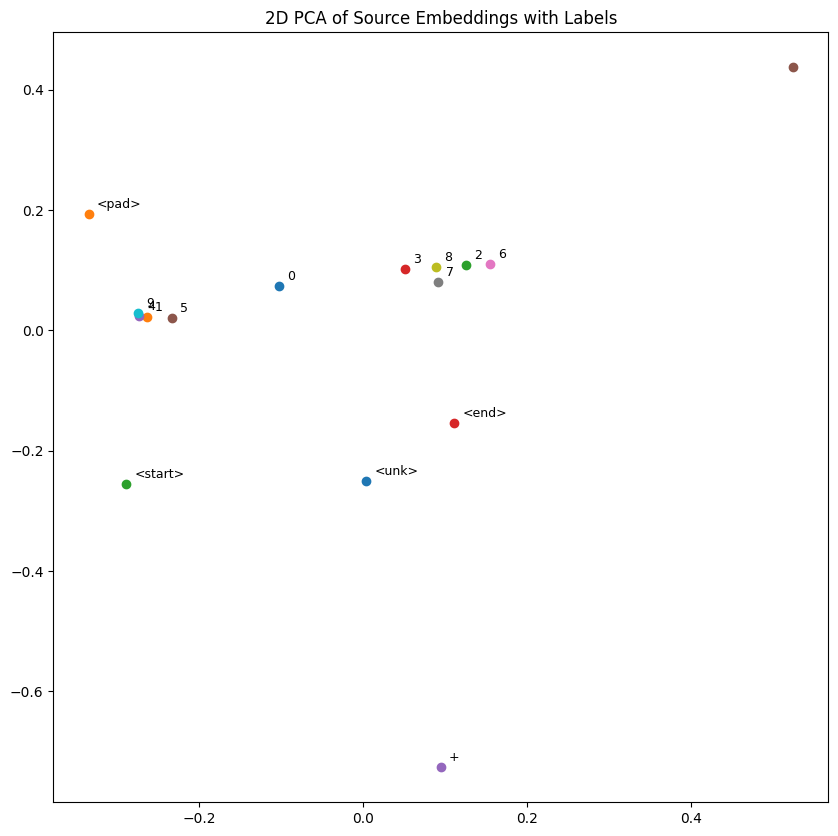

In [43]:
embedding_cpu = embedding_weight.cpu().detach()
print(embedding_cpu[: , :2])

# 逆辞書を作成してインデックスを文字に変換
reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}

# 可視化
plt.figure(figsize=(10, 10))

# 各ポイントを散布図でプロットし、対応するラベルを表示
for i, (x, y) in enumerate(embedding_cpu[:, :2]):  # [:, :2]をスライスし、次にenumerate
    label = reverse_vocab_src[i]  # インデックスを元のトークンに戻す
    plt.scatter(x, y)
    plt.text(x + 0.01, y + 0.01, label, fontsize=9)  # 各点の近くにラベルを表示

plt.title("2D PCA of Source Embeddings with Labels")
plt.show()

## Attentionを確認

In [44]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(10):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    # visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    # Memory-Attentionの可視化
    # visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    
    # Feedforward network

    # decoder linear1, 2
    tgt2 = tgt.matmul(linear1_weight.T) + linear1_bias
    tgt2 = F.relu(tgt2)
    tgt2 = tgt2.matmul(linear2_weight.T) + linear2_bias
    tgt = tgt + tgt2

    # LayerNorm
    tgt = loaded_model.decoder_layer.norm3(tgt)

    output = tgt.transpose(0, 1)
    output = loaded_model.output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"AfterLinear.shape: {tgt2.shape}")
    print(f"AfterAddTGT.shape: {tgt.shape}")
    print(f"AfterAddTGT: {tgt}")
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

text: + + 1 5 + 8 5
memory: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.0314, -0.9120, -0.4581,  0.0651]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]],

        [[ 0.3311, -2.4423, -0.4381,  0.0647]],

        [[ 0.2935,  0.2206, -1.1893,  0.4153]],

        [[-1.4872,  0.3276,  0.8991,  2.4868]],

        [[ 0.7709,  1.8344, -1.1693,  0.4143]],

        [[ 0.1908,  0.7942,  0.6945,  2.6313]],

        [[ 2.0396,  0.7288, -1.1493,  0.4129]],

        [[ 0.6020, -2.3635, -0.3782,  0.0611]],

        [[ 0.5062,  0.0352, -1.1294,  0.4111]],

        [[-0.8208,  0.2142,  1.2555,  0.7200]],

        [[ 0.5137,  1.7181, -1.1095,  0.4089]],

        [[-0.0460,  0.9478,  0.7542,  2.6253]],

        [[ 1.2130, -0.1697,  0.6231,  1.2416]]], device='cuda:0')
memory_size: torch.Size([15, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[-0.5774,  0

text: + + 1 5 + 8 5
memory: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.0314, -0.9120, -0.4581,  0.0651]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]],

        [[ 0.3311, -2.4423, -0.4381,  0.0647]],

        [[ 0.2935,  0.2206, -1.1893,  0.4153]],

        [[-1.4872,  0.3276,  0.8991,  2.4868]],

        [[ 0.7709,  1.8344, -1.1693,  0.4143]],

        [[ 0.1908,  0.7942,  0.6945,  2.6313]],

        [[ 2.0396,  0.7288, -1.1493,  0.4129]],

        [[ 0.6020, -2.3635, -0.3782,  0.0611]],

        [[ 0.5062,  0.0352, -1.1294,  0.4111]],

        [[-0.8208,  0.2142,  1.2555,  0.7200]],

        [[ 0.5137,  1.7181, -1.1095,  0.4089]],

        [[-0.0460,  0.9478,  0.7542,  2.6253]],

        [[ 1.2130, -0.1697,  0.6231,  1.2416]]], device='cuda:0')
memory_size: torch.Size([15, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[-0.5774,  0

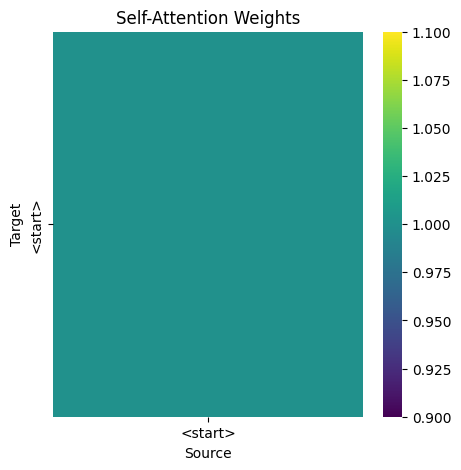

QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 1, 15])
AV.shape: torch.Size([1, 1, 4])
multi_attention: 
[[3.5348949e-01 9.3815960e-03 4.1117624e-04 9.3801759e-02 3.6457073e-02
  1.6121773e-01 6.3744779e-03 1.4332839e-03 3.0366183e-04 4.4198364e-02
  2.1681001e-02 2.5498483e-01 1.2941307e-02 2.5490080e-03 7.7521551e-04]]
[12, 14, 15, 14, 15, 1, 15, 5, 15, 14, 15, 8, 15, 5, 13]
tensor([12, 14, 15, 14, 15,  1, 15,  5, 15, 14, 15,  8, 15,  5, 13], device='cuda:0')
[12, 14, 15, 14, 15, 1, 15, 5, 15, 14, 15, 8, 15, 5, 13]


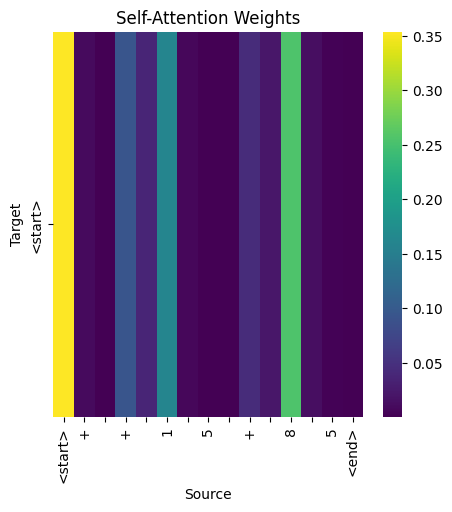

AfterLinear.shape: torch.Size([1, 1, 4])
AfterAddTGT.shape: torch.Size([1, 1, 4])
AfterAddTGT: tensor([[[ 0.7848,  0.0689,  3.8077, -4.2253]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[-6.3180, 13.4170, 12.2999,  1.1619, 11.3218, 12.5504, 13.4858, 11.1270,  8.4569,  5.2565,
          0.3240,  0.5355,  0.9083, -1.0100,  2.9381, -9.7267]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 6

------------------

iter: 1
ys: tensor([[12],
        [ 6]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]]], device='cuda:0')
now tgt: 6
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]]], device='cuda:0')
SelfAttention Layer
QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 2, 4])
WV.shape: torch.Size([1, 2, 4])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 

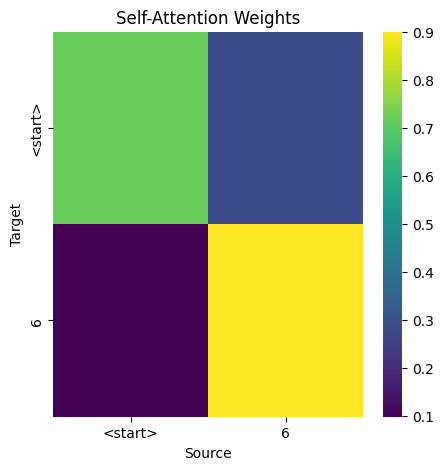

QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 2, 15])
AV.shape: torch.Size([1, 2, 4])
multi_attention: 
[[7.96932206e-02 1.35407352e-03 1.97723421e-06 7.29586899e-01
  4.01063543e-03 2.03091581e-03 1.51609702e-05 5.62758714e-07
  7.12663450e-07 1.76416561e-01 2.21196911e-03 4.62091248e-03
  5.39222492e-05 1.02247043e-06 1.50494373e-06]
 [6.56731287e-03 1.37752260e-03 4.97678639e-06 7.51787424e-01
  1.35476480e-03 5.32218255e-05 3.53354199e-06 1.13716240e-07
  1.63474829e-06 2.37656429e-01 1.06288563e-03 1.19548284e-04
  9.36966626e-06 1.34325930e-07 1.16208025e-06]]
[12, 14, 15, 14, 15, 1, 15, 5, 15, 14, 15, 8, 15, 5, 13]
tensor([12, 14, 15, 14, 15,  1, 15,  5, 15, 14, 15,  8, 15,  5, 13], device='cuda:0')
[12, 14, 15, 14, 15, 1, 15, 5, 15, 14, 15, 8, 15, 5, 13]


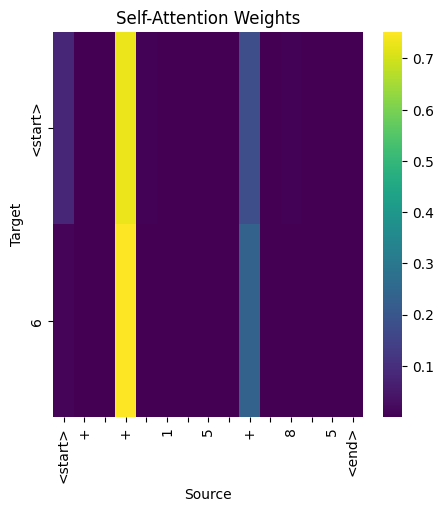

AfterLinear.shape: torch.Size([2, 1, 4])
AfterAddTGT.shape: torch.Size([2, 1, 4])
AfterAddTGT: tensor([[[-0.6709,  4.0301, -4.8023,  1.8691]],

        [[-2.8233,  2.9465, -3.6839,  3.4545]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  0.9510, -14.5994, -17.1495, -10.4630, -13.8217,  -8.8028, -14.8285,  -6.3328, -15.7098,
          -9.1350,  -1.0890,  -2.1860,  -1.9856,   0.4700,   3.1172,  13.1861]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 2
ys: tensor([[12],
        [ 6],
        [15]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]]], device='cuda:0')
now tgt: 6 
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]]], device='cuda:0')
SelfAt

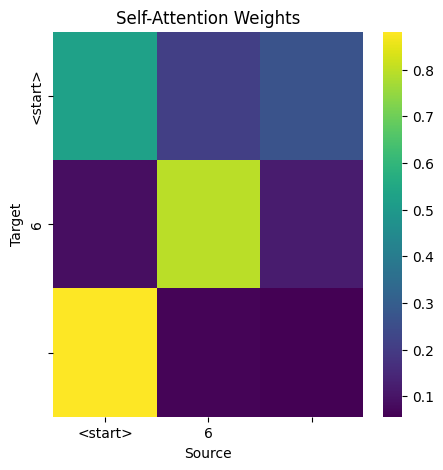

QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 3, 15])
AV.shape: torch.Size([1, 3, 4])
multi_attention: 
[[9.6526876e-02 1.5276717e-03 2.4532162e-06 7.1088237e-01 4.7535645e-03
  2.7971575e-03 2.0943477e-05 8.2063906e-07 9.1046434e-07 1.7449304e-01
  2.5967369e-03 6.3203038e-03 7.3697840e-05 1.5117229e-06 1.9886504e-06]
 [7.4095093e-03 9.6130831e-04 2.1545920e-06 7.7151453e-01 1.1222585e-03
  5.0022274e-05 2.1463845e-06 5.3777057e-08 6.6965606e-07 2.1798787e-01
  8.2167162e-04 1.2084934e-04 6.3132152e-06 6.8447655e-08 5.2896110e-07]
 [4.5055021e-06 8.2605839e-05 3.7197210e-02 1.4994841e-07 4.6307992e-05
  3.1735835e-04 1.4808461e-02 4.4600269e-01 1.0819587e-01 5.4909248e-07
  7.1293522e-05 1.3981761e-04 4.7693974e-03 3.0044982e-01 8.7913975e-02]]
[12, 14, 15, 14, 15, 1, 15, 5, 15, 14, 15, 8, 15, 5, 13]
tensor([12, 14, 15, 14, 15,  1, 15,  5, 15, 14, 15,  8, 15,  5, 13], device='cuda:0')
[12, 14, 15, 14

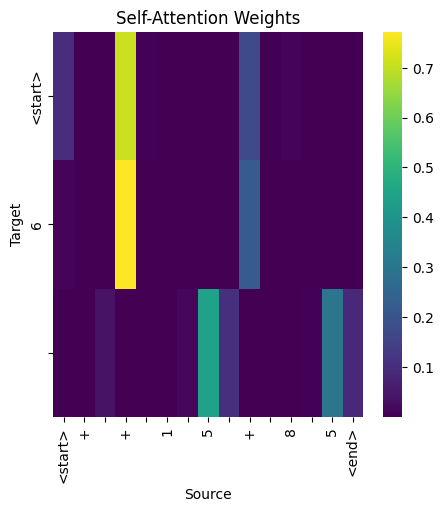

AfterLinear.shape: torch.Size([3, 1, 4])
AfterAddTGT.shape: torch.Size([3, 1, 4])
AfterAddTGT: tensor([[[-0.6136,  4.0637, -4.8134,  1.8051]],

        [[-2.7066,  3.0829, -3.7831,  3.3413]],

        [[ 0.0881,  2.8450,  2.4039, -4.6078]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[-9.0580, 13.4404,  4.0268, -6.7137,  9.8830, 15.1576,  7.4746, 10.5505, -0.3708,  3.6537,
         -0.4576, -0.0563,  0.6500, -5.1596,  9.3523, -6.8563]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 5

------------------

iter: 3
ys: tensor([[12],
        [ 6],
        [15],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]],

        [[-0.3251, -0.9497,  0.6546,  2.6333]]], device='cuda:0')
now tgt: 6 5
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.760

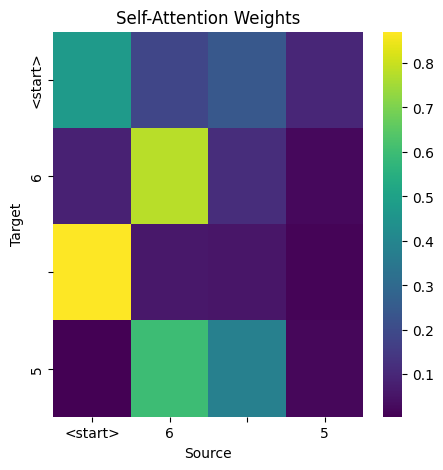

QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 4, 15])
AV.shape: torch.Size([1, 4, 4])
multi_attention: 
[[4.6016078e-02 1.2104820e-03 1.8088217e-06 7.5729442e-01 2.8849905e-03
  9.8334404e-04 8.8752631e-06 3.4393835e-07 6.2578778e-07 1.8771741e-01
  1.6920726e-03 2.1570388e-03 3.0642368e-05 5.8043616e-07 1.1780580e-06]
 [7.1370816e-03 1.0181942e-03 2.4760836e-06 7.6821905e-01 1.1464516e-03
  4.9871585e-05 2.2989791e-06 6.0690986e-08 7.7608939e-07 2.2144698e-01
  8.5093110e-04 1.1852563e-04 6.6383041e-06 7.6117310e-08 6.0326204e-07]
 [4.0220652e-06 7.9972961e-05 3.8108729e-02 1.3990619e-07 4.3382290e-05
  2.8879801e-04 1.4224052e-02 4.4561988e-01 1.1132685e-01 5.1988542e-07
  6.7570487e-05 1.2555609e-04 4.5187566e-03 2.9638487e-01 8.9206919e-02]
 [5.2812272e-03 2.3096532e-03 1.6586540e-05 7.1967065e-01 1.7227529e-03
  6.6082139e-05 7.0388596e-06 3.9060328e-07 5.9143103e-06 2.6927057e-01
  1.5034791e-03

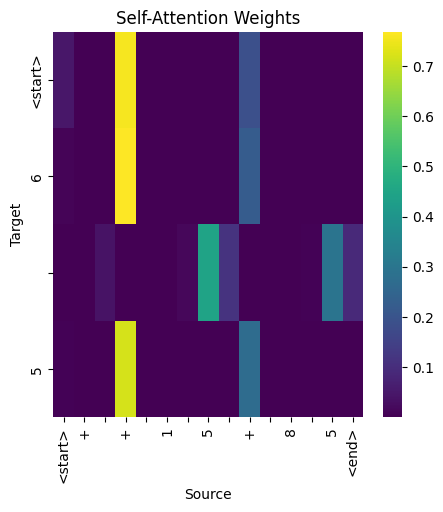

AfterLinear.shape: torch.Size([4, 1, 4])
AfterAddTGT.shape: torch.Size([4, 1, 4])
AfterAddTGT: tensor([[[-0.8008,  3.9162, -4.7795,  2.0469]],

        [[-2.7132,  3.0603, -3.7762,  3.3587]],

        [[-0.1860,  2.8689,  2.5352, -4.5284]],

        [[-2.6143,  2.8882, -3.8255,  3.4662]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  1.2083, -14.4470, -17.2400, -10.3232, -13.4986,  -8.9404, -15.1086,  -6.8053, -15.6646,
          -8.7053,  -1.1361,  -2.2459,  -2.0500,   0.0596,   3.2427,  13.0687]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 4
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]],

        [[-0.3251, -0.9497,  0.6546,  2.6333]],

        [[ 0.2935,  0.2206, -1.1893

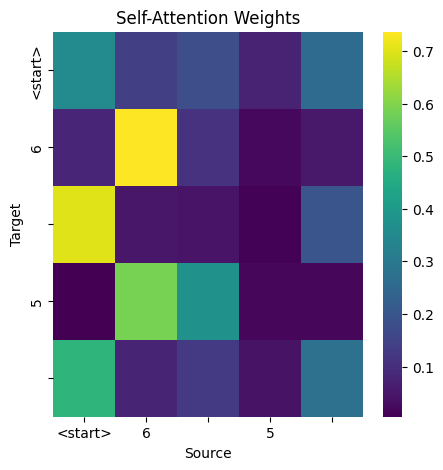

QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 5, 15])
AV.shape: torch.Size([1, 5, 4])
multi_attention: 
[[7.8949809e-02 1.6979774e-03 3.2453815e-06 7.1902484e-01 4.6333186e-03
  2.4429851e-03 2.1475400e-05 9.8353564e-07 1.2146816e-06 1.8528286e-01
  2.6448190e-03 5.2199783e-03 7.2203853e-05 1.7264551e-06 2.5520389e-06]
 [7.4695554e-03 9.5403317e-04 2.1134501e-06 7.7198690e-01 1.1207962e-03
  5.0142055e-05 2.1309770e-06 5.2900713e-08 6.5617900e-07 2.1746646e-01
  8.1875181e-04 1.2150977e-04 6.2852555e-06 6.7495669e-08 5.1927640e-07]
 [5.1135999e-06 8.8093628e-05 3.6127813e-02 1.7376583e-07 5.0167007e-05
  3.5797892e-04 1.4930507e-02 4.4741887e-01 1.0377446e-01 6.2410516e-07
  7.6553857e-05 1.5731002e-04 4.8984098e-03 3.0449370e-01 8.7620117e-02]
 [5.2815792e-03 2.3106288e-03 1.6603004e-05 7.1964824e-01 1.7233730e-03
  6.6055261e-05 7.0440797e-06 3.9071034e-07 5.9205363e-06 2.6929042e-01
  1.5040926e-03

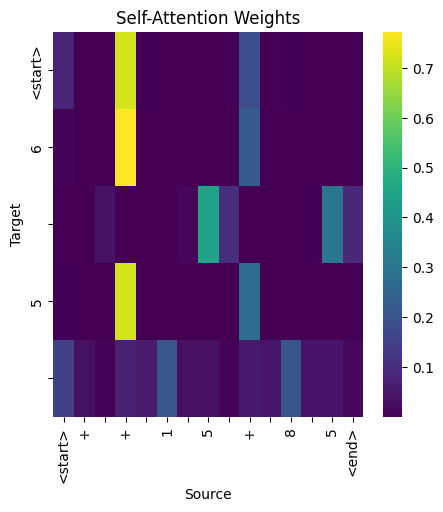

AfterLinear.shape: torch.Size([5, 1, 4])
AfterAddTGT.shape: torch.Size([5, 1, 4])
AfterAddTGT: tensor([[[-0.5951,  4.0082, -4.8313,  1.8527]],

        [[-2.7082,  3.0859, -3.7823,  3.3393]],

        [[ 0.5794,  3.9195,  1.0136, -4.5735]],

        [[-2.6159,  2.8875, -3.8242,  3.4669]],

        [[ 2.1553,  4.4107, -4.4006, -1.1294]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[ -2.2082,   3.8244, -15.1093, -13.2017,   4.1159,   4.2333, -13.6729,  -6.7020, -14.7934,
           4.6868,  -2.3961,  -2.7319,  -2.0226, -14.5150,  15.0924,   2.6053]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 14

------------------

iter: 5
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]],

        [[-0.3251, -0

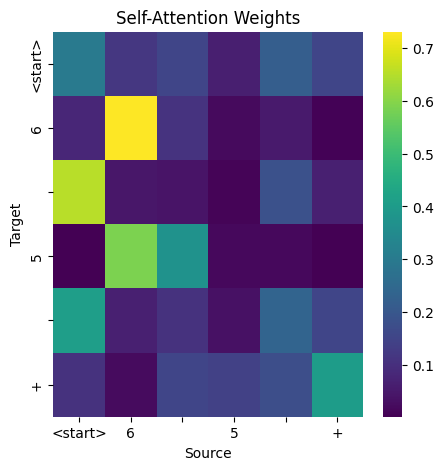

QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 6, 15])
AV.shape: torch.Size([1, 6, 4])
multi_attention: 
[[8.51742774e-02 3.32327839e-03 1.38980522e-05 6.77223086e-01
  7.49050220e-03 4.60237265e-03 6.54863979e-05 5.24808456e-06
  5.84947111e-06 2.08843634e-01 4.66526020e-03 8.37859418e-03
  1.87945901e-04 8.45295654e-06 1.20562527e-05]
 [7.42070656e-03 9.68923094e-04 2.19198182e-06 7.71154344e-01
  1.12922105e-03 5.01863324e-05 2.17536967e-06 5.45950876e-08
  6.82148141e-07 2.18315631e-01 8.27524229e-04 1.21226381e-04
  6.38664369e-06 6.94179789e-08 5.37141602e-07]
 [3.68507335e-06 8.06596436e-05 3.91084738e-02 1.42775463e-07
  4.17040828e-05 2.70513730e-04 1.33508136e-02 4.45466578e-01
  1.13745764e-01 5.35381218e-07 6.58594145e-05 1.14655559e-04
  4.20599617e-03 2.91894317e-01 9.16502848e-02]
 [5.27836569e-03 2.32255063e-03 1.67970120e-05 7.19340026e-01
  1.72888068e-03 6.62231541e-05 7.09955566e-06

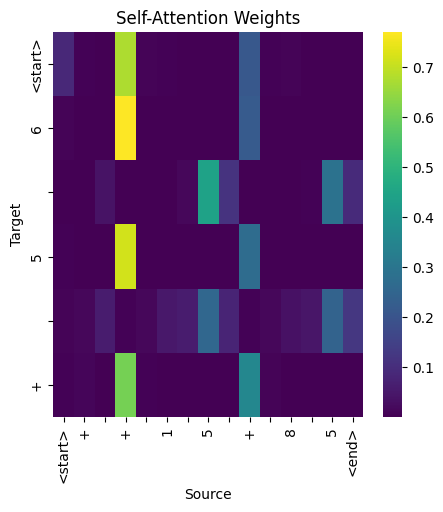

AfterLinear.shape: torch.Size([6, 1, 4])
AfterAddTGT.shape: torch.Size([6, 1, 4])
AfterAddTGT: tensor([[[-0.4184,  3.9675, -4.8933,  1.8008]],

        [[-2.7141,  3.0794, -3.7775,  3.3449]],

        [[ 0.6848,  4.2309,  0.5422, -4.4685]],

        [[-2.6165,  2.8864, -3.8237,  3.4678]],

        [[ 1.0060,  4.2034, -4.9994,  0.5459]],

        [[-3.0858,  2.4341, -3.3932,  3.8142]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  1.5315, -15.8508, -15.9946,  -9.0979, -14.8490, -10.0391, -13.9263,  -6.1283, -14.4217,
          -9.8856,  -0.8732,  -2.0473,  -1.9310,   2.1783,   1.3147,  13.4671]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 6
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15],
        [14],
        [15]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

       

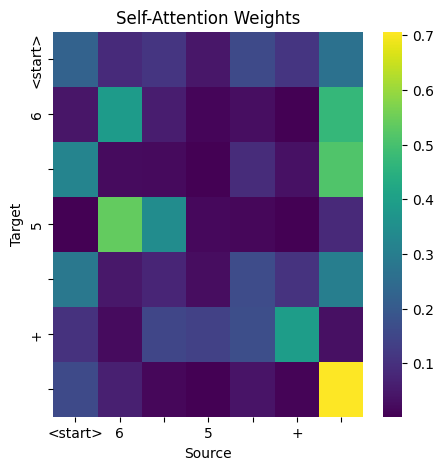

QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 7, 15])
AV.shape: torch.Size([1, 7, 4])
multi_attention: 
[[1.37117073e-01 1.81498576e-03 3.32692161e-06 6.68645144e-01
  6.30385568e-03 4.80947876e-03 3.57564204e-05 1.46852483e-06
  1.29575722e-06 1.66862577e-01 3.35974363e-03 1.09149786e-02
  1.24554848e-04 2.79379788e-06 2.98760210e-06]
 [5.58977798e-02 9.27400833e-04 1.03552895e-06 7.65243292e-01
  2.77172308e-03 4.67377162e-04 6.83620556e-06 9.53586010e-08
  3.40931280e-07 1.71685144e-01 1.51549513e-03 1.45762309e-03
  2.53572325e-05 1.69859774e-07 4.17611034e-07]
 [2.25997748e-04 4.70381667e-04 2.46104766e-02 4.90226512e-06
  5.76612598e-04 6.30577561e-03 4.51168753e-02 3.96805882e-01
  5.56253567e-02 1.07854112e-05 6.48810703e-04 3.99781158e-03
  2.31996290e-02 3.74016732e-01 6.83839768e-02]
 [5.37971128e-03 2.06145365e-03 1.28326546e-05 7.26521134e-01
  1.61074195e-03 6.18569902e-05 5.94067569e-06

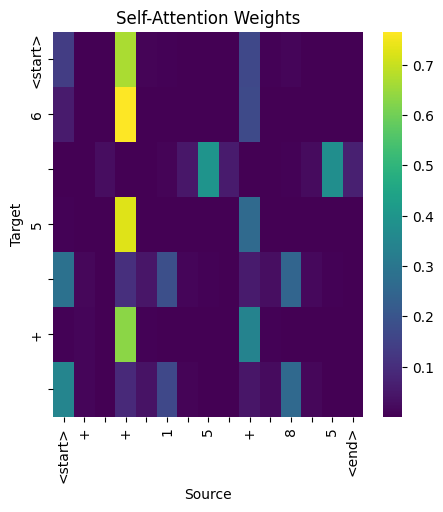

AfterLinear.shape: torch.Size([7, 1, 4])
AfterAddTGT.shape: torch.Size([7, 1, 4])
AfterAddTGT: tensor([[[-0.5525,  4.1365, -4.8146,  1.6966]],

        [[-2.3345,  3.8428, -4.0404,  2.6572]],

        [[-0.7071,  2.3920,  3.1575, -4.3016]],

        [[-2.6350,  2.9017, -3.8128,  3.4600]],

        [[ 1.5007,  5.1524, -2.5739, -2.9369]],

        [[-3.1099,  2.4724, -3.3825,  3.7922]],

        [[ 4.8622, -4.0821, -2.2642,  1.6176]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  9.2844,  -0.7596,   4.6410,  10.0762,   5.6654,  -8.8595,  -1.9023, -11.0072,   8.5042,
           9.4423,  -0.4910,  -1.7481,  -2.1447,  -3.6019,  -4.2623,  -2.6675]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 3

------------------

iter: 7
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15],
        [14],
        [15],
        [ 3]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.346

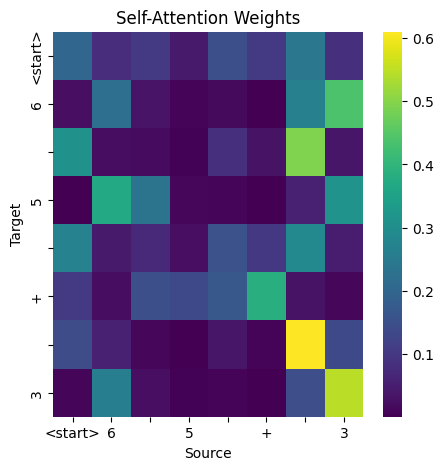

QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 8, 15])
AV.shape: torch.Size([1, 8, 4])
multi_attention: 
[[8.0881439e-02 1.2304927e-03 1.6001188e-06 7.3322678e-01 3.7935944e-03
  1.8940270e-03 1.3189883e-05 4.4481098e-07 5.6788707e-07 1.7241071e-01
  2.0588450e-03 4.4380976e-03 4.8086964e-05 8.2141690e-07 1.2011122e-06]
 [1.1462879e-02 9.6228818e-04 1.8857510e-06 7.7625030e-01 1.3805177e-03
  7.2194707e-05 2.7829012e-06 5.4989101e-08 5.9225624e-07 2.0871603e-01
  9.4964250e-04 1.9162276e-04 8.5776801e-06 7.4956041e-08 4.7650934e-07]
 [1.6120930e-04 3.9574387e-04 2.4928372e-02 3.5105495e-06 4.5847063e-04
  4.9734800e-03 4.1052315e-02 4.0484348e-01 5.7742681e-02 8.0640557e-06
  5.2836147e-04 3.0507327e-03 2.0302586e-02 3.7220752e-01 6.9343410e-02]
 [5.2135387e-03 2.9492038e-03 2.8776780e-05 7.0505315e-01 2.0243220e-03
  7.2977338e-05 1.0334398e-05 6.5332665e-07 1.0678231e-05 2.8263989e-01
  1.8333611e-03

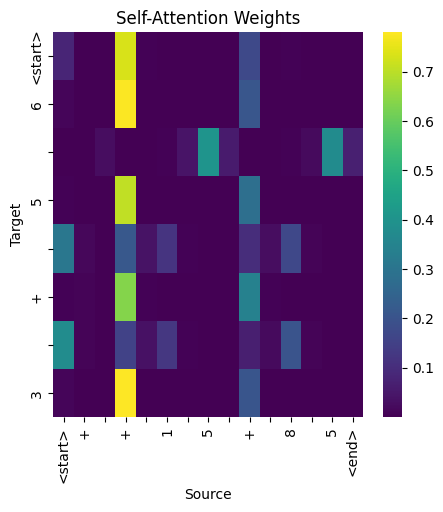

AfterLinear.shape: torch.Size([8, 1, 4])
AfterAddTGT.shape: torch.Size([8, 1, 4])
AfterAddTGT: tensor([[[-0.7089,  4.0421, -4.7873,  1.8759]],

        [[-2.8747,  3.1650, -3.6695,  3.3032]],

        [[-0.7078,  2.5672,  3.0284, -4.3226]],

        [[-2.7240,  2.8023, -3.7359,  3.5413]],

        [[ 0.8109,  4.6407, -4.7443,  0.1038]],

        [[-3.1068,  2.4787, -3.3864,  3.7882]],

        [[-0.3174,  5.9288, -2.6336, -2.0358]],

        [[-2.8197,  3.1948, -3.7121,  3.2742]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  0.5367, -14.0786, -17.5297, -11.1065, -13.5013,  -8.1395, -14.9944,  -6.1127, -16.2371,
          -9.0200,  -1.1524,  -2.2058,  -1.9660,  -0.0407,   3.8263,  13.0776]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 8
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15],
        [14],
        [15],
        [ 3],
        [15]], device=

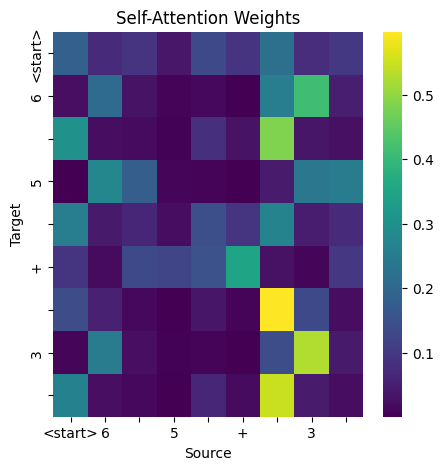

QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 9, 15])
AV.shape: torch.Size([1, 9, 4])
multi_attention: 
[[8.56327340e-02 1.25583110e-03 1.64890446e-06 7.28717208e-01
  3.94993927e-03 2.05346430e-03 1.41653545e-05 4.78153709e-07
  5.88714840e-07 1.71363756e-01 2.13273126e-03 4.82353894e-03
  5.16779728e-05 8.88611623e-07 1.25738825e-06]
 [1.23732891e-02 8.49797216e-04 1.39552390e-06 7.82612026e-01
  1.31370174e-03 7.41822587e-05 2.39255974e-06 4.33508944e-08
  4.30578439e-07 2.01684549e-01 8.78057152e-04 2.02113064e-04
  7.67367692e-06 6.09951414e-08 3.64172962e-07]
 [1.84324599e-04 4.24097379e-04 2.45711412e-02 4.05117135e-06
  5.01142000e-04 5.52210491e-03 4.21266742e-02 4.02481824e-01
  5.62752634e-02 9.13561325e-06 5.72173449e-04 3.41286557e-03
  2.11916938e-02 3.73772085e-01 6.89514875e-02]
 [5.38383052e-03 2.07668915e-03 1.30487470e-05 7.26125777e-01
  1.61991967e-03 6.18115446e-05 6.01474039e-06

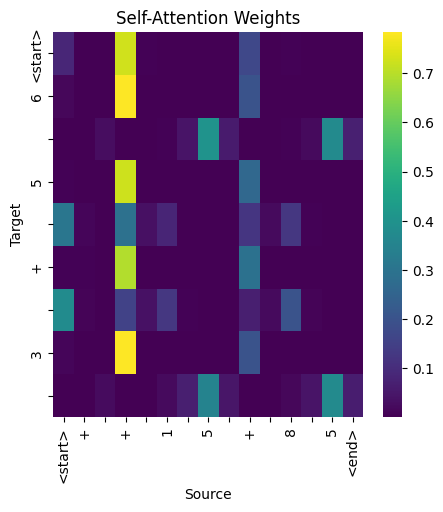

AfterLinear.shape: torch.Size([9, 1, 4])
AfterAddTGT.shape: torch.Size([9, 1, 4])
AfterAddTGT: tensor([[[-0.6985,  4.0536, -4.7883,  1.8589]],

        [[-2.8033,  3.2340, -3.7268,  3.2426]],

        [[-0.8237,  2.6435,  3.0210, -4.2837]],

        [[-2.6489,  2.8952, -3.8022,  3.4666]],

        [[ 0.4072,  4.4647, -4.8676,  0.6946]],

        [[-3.0078,  2.6656, -3.5017,  3.6630]],

        [[-0.1952,  5.8765, -2.9129, -1.8276]],

        [[-2.7744,  3.2421, -3.7482,  3.2326]],

        [[-0.4238,  2.3526,  3.0582, -4.4061]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[-8.9906, 12.4746,  5.9132, -5.3023,  8.8349, 14.5127,  9.3647, 11.8054,  1.3463,  2.5209,
         -0.1390,  0.2278,  0.8584, -2.8265,  7.3176, -6.8364]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 5

------------------

iter: 9
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15],
        [14],
        [15],
    

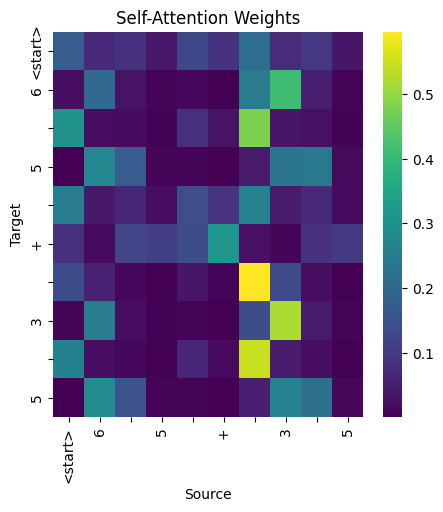

QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 10, 15])
AV.shape: torch.Size([1, 10, 4])
multi_attention: 
[[6.64896220e-02 1.13471481e-03 1.41302746e-06 7.47298777e-01
  3.28061124e-03 1.41828193e-03 1.01816595e-05 3.37746769e-07
  4.90599177e-07 1.75208062e-01 1.80910644e-03 3.30968527e-03
  3.71175156e-05 6.11206588e-07 1.00092632e-06]
 [1.20482417e-02 8.55827413e-04 1.42991269e-06 7.82092035e-01
  1.30387500e-03 7.24269994e-05 2.38170742e-06 4.37392202e-08
  4.41367263e-07 2.02543259e-01 8.75689788e-04 1.96340377e-04
  7.60290823e-06 6.12105779e-08 3.71014039e-07]
 [1.74552799e-04 4.12613823e-04 2.46096794e-02 3.84451278e-06
  4.82953736e-04 5.31838182e-03 4.14454304e-02 4.03817296e-01
  5.65763675e-02 8.72914643e-06 5.53571619e-04 3.26788332e-03
  2.07208917e-02 3.73492360e-01 6.91155642e-02]
 [5.35775675e-03 2.14126310e-03 1.39856638e-05 7.24298477e-01
  1.64987647e-03 6.27596091e-05 6.29689293e

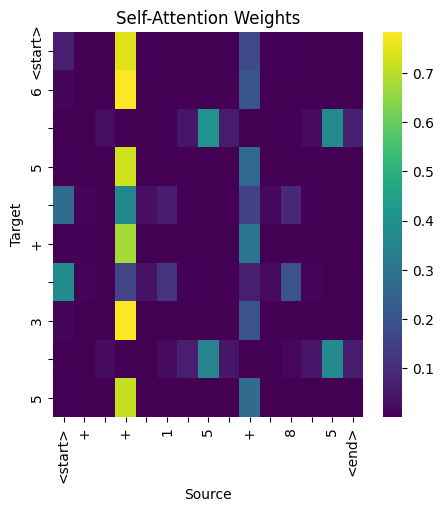

AfterLinear.shape: torch.Size([10, 1, 4])
AfterAddTGT.shape: torch.Size([10, 1, 4])
AfterAddTGT: tensor([[[-0.7566,  4.0041, -4.7789,  1.9380]],

        [[-2.8068,  3.2228, -3.7235,  3.2515]],

        [[-0.8330,  2.6737,  3.0019, -4.2829]],

        [[-2.6492,  2.8892, -3.8012,  3.4709]],

        [[ 0.2220,  4.2869, -4.9326,  1.0534]],

        [[-2.9154,  2.6579, -3.5710,  3.6597]],

        [[-0.1384,  5.8441, -3.0440, -1.7231]],

        [[-2.7761,  3.2355, -3.7465,  3.2378]],

        [[-0.4824,  2.3988,  3.0517, -4.3901]],

        [[-2.7126,  2.8323, -3.7484,  3.5193]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  1.2244, -14.6864, -17.0655, -10.1723, -13.7517,  -9.0926, -14.9169,  -6.6541, -15.5057,
          -8.9420,  -1.0927,  -2.2108,  -2.0259,   0.4214,   2.9480,  13.1554]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 10
ys: tensor([[12],
        [ 6],
     

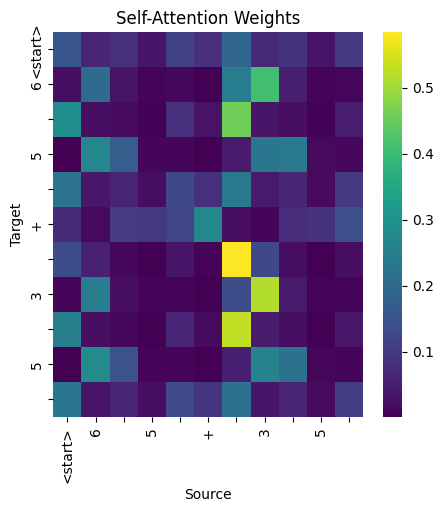

QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 11, 15])
AV.shape: torch.Size([1, 11, 4])
multi_attention: 
[[7.57718235e-02 1.30613241e-03 1.85217607e-06 7.34172881e-01
  3.82492389e-03 1.85952487e-03 1.38449122e-05 5.04426964e-07
  6.62085483e-07 1.76638007e-01 2.11354066e-03 4.24455479e-03
  4.94255473e-05 9.13728513e-07 1.38520761e-06]
 [1.21906511e-02 8.49490054e-04 1.40113730e-06 7.82519817e-01
  1.30434637e-03 7.30749744e-05 2.37031304e-06 4.31885780e-08
  4.32111733e-07 2.01978162e-01 8.73607700e-04 1.98629670e-04
  7.59056638e-06 6.06248278e-08 3.64720876e-07]
 [1.44928214e-04 3.76534852e-04 2.46929228e-02 3.23885661e-06
  4.25755919e-04 4.69122594e-03 3.90051752e-02 4.08517420e-01
  5.74516766e-02 7.52420647e-06 4.94748703e-04 2.81939236e-03
  1.91050824e-02 3.72533590e-01 6.97307438e-02]
 [5.35651203e-03 2.14472297e-03 1.40368384e-05 7.24202394e-01
  1.65149453e-03 6.28083944e-05 6.31222383e

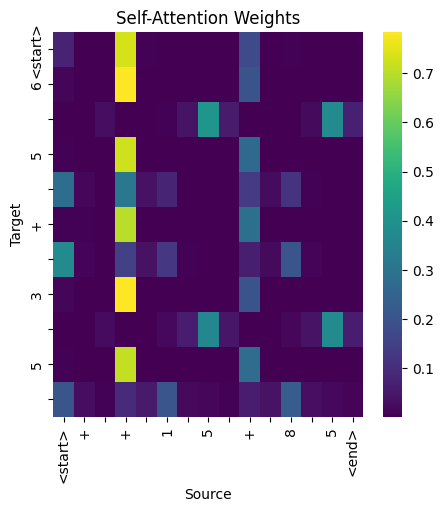

AfterLinear.shape: torch.Size([11, 1, 4])
AfterAddTGT.shape: torch.Size([11, 1, 4])
AfterAddTGT: tensor([[[-0.6889,  4.0218, -4.7982,  1.8866]],

        [[-2.8026,  3.2293, -3.7270,  3.2461]],

        [[-0.8961,  2.7991,  2.9316, -4.2678]],

        [[-2.6493,  2.8888, -3.8011,  3.4711]],

        [[ 0.3925,  4.3213, -4.9357,  0.8890]],

        [[-2.9156,  2.7148, -3.5808,  3.6225]],

        [[-0.1012,  5.8528, -2.8991, -1.8979]],

        [[-2.7736,  3.2393, -3.7485,  3.2346]],

        [[-0.7231,  2.5864,  3.0206, -4.3185]],

        [[-2.7128,  2.8320, -3.7483,  3.5195]],

        [[ 2.0140,  4.5815, -4.2594, -1.2884]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[ -2.6928,   4.1718, -15.0771, -13.6102,   4.1962,   4.8511, -13.3750,  -6.0968, -14.9846,
           4.5002,  -2.3866,  -2.6794,  -1.9430, -14.4919,  15.3980,   2.4972]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 14

-----------------

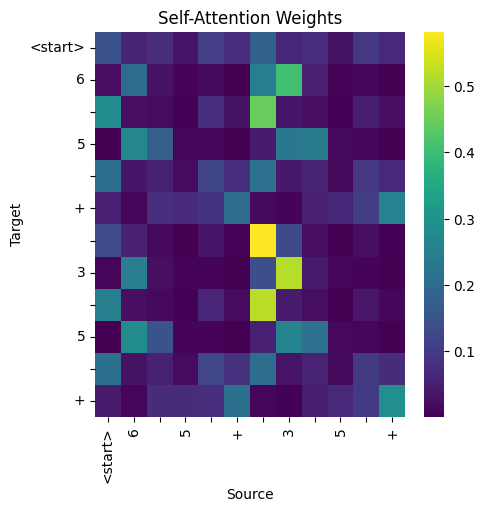

QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 12, 15])
AV.shape: torch.Size([1, 12, 4])
multi_attention: 
[[7.60517642e-02 1.63968070e-03 3.03657862e-06 7.22908318e-01
  4.44910489e-03 2.27223849e-03 1.98165653e-05 8.88442969e-07
  1.12798216e-06 1.85165584e-01 2.54017697e-03 4.87747230e-03
  6.69471483e-05 1.55791031e-06 2.35405287e-06]
 [1.21698640e-02 8.51504388e-04 1.40931490e-06 7.82398999e-01
  1.30543148e-03 7.30157626e-05 2.37679160e-06 4.33806093e-08
  4.34777121e-07 2.02115759e-01 8.74844496e-04 1.98364651e-04
  7.60533339e-06 6.08551431e-08 3.66599068e-07]
 [9.74647483e-05 3.09552328e-04 2.52402388e-02 2.21124628e-06
  3.26420733e-04 3.52672301e-03 3.48827131e-02 4.16790992e-01
  6.03863783e-02 5.40510928e-06 3.90500121e-04 2.03998201e-03
  1.63148828e-02 3.68655711e-01 7.10308254e-02]
 [5.35476860e-03 2.14963546e-03 1.41097253e-05 7.24066138e-01
  1.65379362e-03 6.28769994e-05 6.33405079e

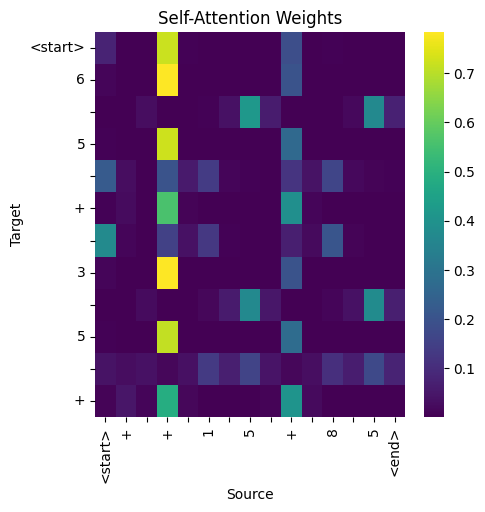

AfterLinear.shape: torch.Size([12, 1, 4])
AfterAddTGT.shape: torch.Size([12, 1, 4])
AfterAddTGT: tensor([[[-0.6111,  4.0029, -4.8274,  1.8663]],

        [[-2.8040,  3.2279, -3.7259,  3.2473]],

        [[-0.4075,  3.2952,  2.2808, -4.4570]],

        [[-2.6495,  2.8883, -3.8009,  3.4715]],

        [[ 0.9030,  4.3002, -4.9542,  0.5075]],

        [[-3.0359,  2.3562, -3.4148,  3.8579]],

        [[-0.0813,  5.8542, -2.8167, -1.9934]],

        [[-2.7740,  3.2390, -3.7482,  3.2349]],

        [[-0.9307,  2.6608,  3.0529, -4.2409]],

        [[-2.7129,  2.8316, -3.7481,  3.5198]],

        [[ 1.8131,  4.3617, -4.6912, -0.5346]],

        [[-3.3459,  2.0372, -3.0739,  4.0496]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  1.8551, -16.7313, -14.8950,  -8.0134, -15.6305, -10.8416, -12.9637,  -5.7040, -13.2949,
         -10.5472,  -0.6796,  -1.9024,  -1.8494,   3.6550,  -0.1437,  13.6027]], device='cuda:0',
       grad_fn=<

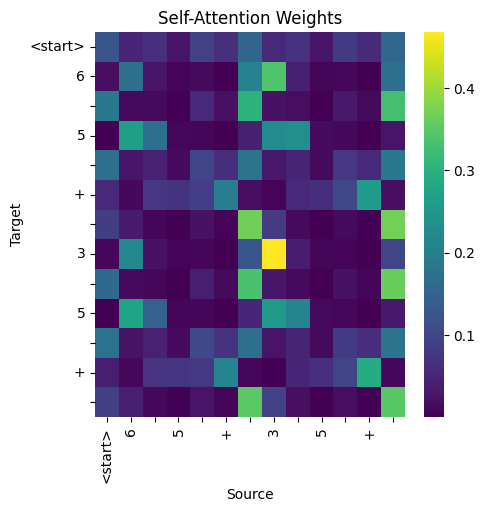

QV.shape: torch.Size([1, 13, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 13, 15])
AV.shape: torch.Size([1, 13, 4])
multi_attention: 
[[1.01801708e-01 1.44605304e-03 2.15089449e-06 7.09425211e-01
  4.70382534e-03 2.82065757e-03 1.99683327e-05 7.29237797e-07
  7.92938522e-07 1.70647874e-01 2.52980809e-03 6.52656518e-03
  7.15738934e-05 1.36582207e-06 1.74515139e-06]
 [2.14343984e-02 8.20711721e-04 1.07835103e-06 7.85788655e-01
  1.65122212e-03 1.33177513e-04 3.13604573e-06 4.73844075e-08
  3.36278418e-07 1.88749045e-01 1.01569330e-03 3.91392008e-04
  1.07857577e-05 7.33170893e-08 3.20987766e-07]
 [5.76546416e-04 7.68909173e-04 2.36889534e-02 1.27980975e-05
  1.09231949e-03 1.21460622e-02 5.75054027e-02 3.71579677e-01
  4.98204418e-02 2.49366676e-05 1.15228863e-03 8.39656498e-03
  3.29985470e-02 3.74530166e-01 6.57064244e-02]
 [5.38357021e-03 2.09090067e-03 1.32516170e-05 7.25742161e-01
  1.62762741e-03 6.18931081e-05 6.08084156e

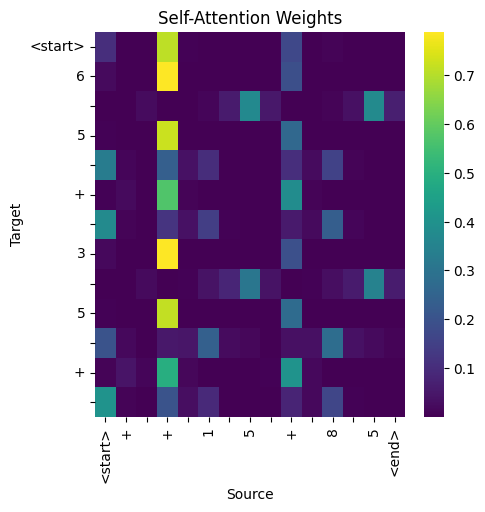

AfterLinear.shape: torch.Size([13, 1, 4])
AfterAddTGT.shape: torch.Size([13, 1, 4])
AfterAddTGT: tensor([[[-0.6365,  4.0819, -4.8020,  1.7981]],

        [[-2.6979,  3.4569, -3.8117,  3.0539]],

        [[-0.4512,  1.7669,  3.4718, -4.2945]],

        [[-2.6558,  2.8914, -3.7969,  3.4703]],

        [[ 0.6038,  4.6675, -4.7440,  0.2504]],

        [[-3.0498,  2.3740, -3.4080,  3.8481]],

        [[-2.4755,  2.2611,  3.7834, -3.3452]],

        [[-2.7223,  3.3501, -3.7912,  3.1421]],

        [[ 3.6565, -3.4895, -3.1549,  2.9583]],

        [[-2.7209,  2.8351, -3.7429,  3.5185]],

        [[ 4.5542,  0.8292, -4.8145,  0.2503]],

        [[-3.3400,  2.0639, -3.0869,  4.0352]],

        [[-0.5881,  5.6869, -3.7061, -0.5995]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[ -4.7502,  -0.4509, -17.9098, -16.8589,  -1.9793,   4.1290, -13.9692,  -3.1488, -18.6848,
          -1.6188,  -2.1063,  -2.3971,  -1.6095, -10.3702,  14.55

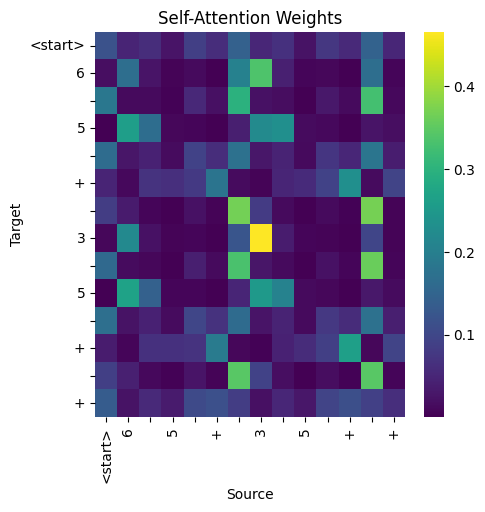

QV.shape: torch.Size([1, 14, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 14, 15])
AV.shape: torch.Size([1, 14, 4])
multi_attention: 
[[9.82441083e-02 1.54416985e-03 2.50109224e-06 7.08999097e-01
  4.82758135e-03 2.87981611e-03 2.15703985e-05 8.49051219e-07
  9.30724298e-07 1.74261302e-01 2.63471180e-03 6.50393870e-03
  7.58328606e-05 1.56612600e-06 2.03896820e-06]
 [2.13269237e-02 8.20260262e-04 1.07882374e-06 7.85822690e-01
  1.64681883e-03 1.32377041e-04 3.12394923e-06 4.72462141e-08
  3.36343049e-07 1.88832670e-01 1.01362693e-03 3.88850545e-04
  1.07396254e-05 7.30491934e-08 3.20716794e-07]
 [5.08664350e-04 7.19198317e-04 2.37380043e-02 1.12586376e-05
  1.00181065e-03 1.11695193e-02 5.55539206e-02 3.75498831e-01
  5.04006296e-02 2.22899980e-05 1.06582441e-03 7.62196723e-03
  3.14262211e-02 3.75202447e-01 6.60593584e-02]
 [5.36482083e-03 2.13729218e-03 1.39268823e-05 7.24432230e-01
  1.64913805e-03 6.25689427e-05 6.28391444e

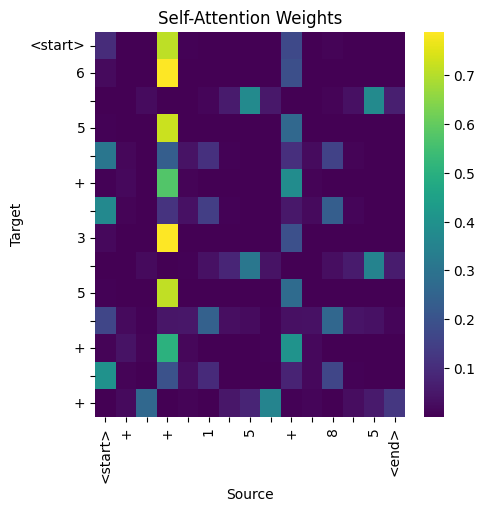

AfterLinear.shape: torch.Size([14, 1, 4])
AfterAddTGT.shape: torch.Size([14, 1, 4])
AfterAddTGT: tensor([[[-0.6089,  4.0669, -4.8141,  1.7994]],

        [[-2.6990,  3.4550, -3.8109,  3.0556]],

        [[-0.5775,  2.0021,  3.3730, -4.2911]],

        [[-2.6561,  2.8870, -3.7961,  3.4734]],

        [[ 0.6986,  4.5790, -4.7986,  0.2976]],

        [[-3.0189,  2.3932, -3.4368,  3.8345]],

        [[-2.4447,  2.2821,  3.7648, -3.3699]],

        [[-2.7219,  3.3503, -3.7914,  3.1419]],

        [[ 4.1365, -3.6319, -2.9853,  2.5231]],

        [[-2.7210,  2.8315, -3.7423,  3.5210]],

        [[ 4.0050,  2.9253, -4.1585, -1.6465]],

        [[-3.3005,  2.1052, -3.1326,  4.0124]],

        [[-0.5493,  5.6801, -3.7152, -0.6169]],

        [[-3.9139, -2.8776,  2.0864,  3.6599]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  3.1932, -14.9145,   5.3513,   6.6541, -13.3441, -11.4763,   5.0164,   2.8645,   5.8042,
         -10.508

In [45]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(15):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    self_attn_weights_np = self_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"self_attention: \n{self_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = tgt_tokens_
    print(f"tgt_tokens: {tgt_tokens_}")
    # Self-Attentionの可視化
    visualize_attention(self_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    multi_attn_weights_np = multi_attn_weights.squeeze(0).detach().cpu().numpy()
    print(f"multi_attention: \n{multi_attn_weights_np}")
    tgt_tokens_ = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)
    src_tokens_ = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)
    # Memory-Attentionの可視化
    visualize_attention(multi_attn_weights_np, src_tokens_, tgt_tokens_, title="Self-Attention Weights")

    
    # Feedforward network

    # decoder linear1, 2
    tgt2 = tgt.matmul(linear1_weight.T) + linear1_bias
    tgt2 = F.relu(tgt2)
    tgt2 = tgt2.matmul(linear2_weight.T) + linear2_bias
    tgt = tgt + tgt2

    # LayerNorm
    tgt = loaded_model.decoder_layer.norm3(tgt)

    output = tgt.transpose(0, 1)
    output = loaded_model.output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"AfterLinear.shape: {tgt2.shape}")
    print(f"AfterAddTGT.shape: {tgt.shape}")
    print(f"AfterAddTGT: {tgt}")
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

## TGTのベクトル移動を観察

tensor([[-0.1027,  0.0730],
        [-0.2641,  0.0220],
        [ 0.1258,  0.1088],
        [ 0.0510,  0.1013],
        [-0.2728,  0.0246],
        [-0.2331,  0.0202],
        [ 0.1550,  0.1099],
        [ 0.0919,  0.0811],
        [ 0.0896,  0.1049],
        [-0.2750,  0.0292],
        [ 0.0038, -0.2498],
        [-0.3348,  0.1928],
        [-0.2887, -0.2560],
        [ 0.1112, -0.1532],
        [ 0.0950, -0.7262],
        [ 0.5251,  0.4371]])


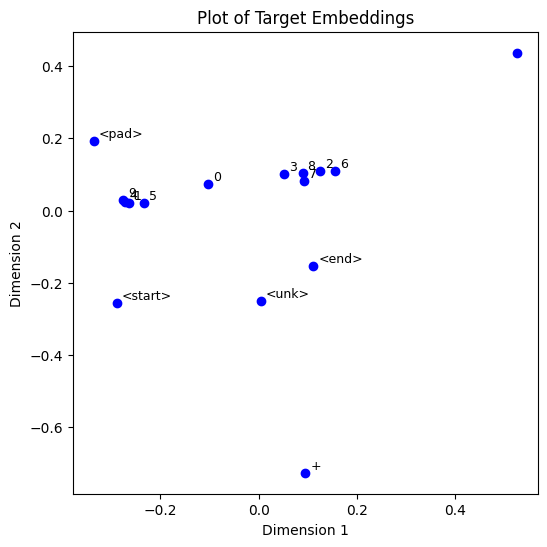

In [52]:
import numpy as np
embedding_cpu_01dim = embedding_weight.cpu().detach()[: , :2]
print(embedding_cpu_01dim)

reverse_vocab_src = {idx: token for token, idx in vocab_src.items()}
reverse_vocab_tgt = {idx: token for token, idx in vocab_tgt.items()}

def plot_embedding_tgt_2d(ys=None, tgt_embed=None, src=None, title="Target Embeddings"):
    plt.figure(figsize=(6, 6))

    # 事前Embedding
    for i, (x, y) in enumerate(embedding_cpu_01dim):
        label = reverse_vocab_src[i]
        plt.scatter(x, y, color='blue')
        plt.text(x + 0.01, y + 0.01, label, fontsize=9) 

    if tgt_embed is not None:
        tgt_embed = tgt_embed.detach().cpu().numpy()
        print(tgt_embed)
        print(tgt_embed.shape)
        if len(tgt_embed.shape) > 2:
            if tgt_embed.shape[0] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=0)
            elif tgt_embed.shape[1] == 1:
                tgt_embed = np.squeeze(tgt_embed, axis=1)
        tgt_embed_2d = tgt_embed[:, :2]
        print(tgt_embed_2d)
        for i, (x, y) in enumerate(tgt_embed_2d):
            if src is not None:
                label = convert_indexes_to_list(src.squeeze(1).tolist(), vocab_src)[i] + f"({i})"
            else:
                label = convert_indexes_to_list(ys.squeeze(1).tolist(), vocab_tgt)[i] + f"({i})"
            plt.scatter(x, y, color='green', s=100, marker='x')
            plt.text(x + 0.01, y + 0.01, str(i)+label, fontsize=9)

    plt.title(f"Plot of {title}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()


plot_embedding_tgt_2d()

text: + + 1 5 + 8 5
memory: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.0314, -0.9120, -0.4581,  0.0651]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]],

        [[ 0.3311, -2.4423, -0.4381,  0.0647]],

        [[ 0.2935,  0.2206, -1.1893,  0.4153]],

        [[-1.4872,  0.3276,  0.8991,  2.4868]],

        [[ 0.7709,  1.8344, -1.1693,  0.4143]],

        [[ 0.1908,  0.7942,  0.6945,  2.6313]],

        [[ 2.0396,  0.7288, -1.1493,  0.4129]],

        [[ 0.6020, -2.3635, -0.3782,  0.0611]],

        [[ 0.5062,  0.0352, -1.1294,  0.4111]],

        [[-0.8208,  0.2142,  1.2555,  0.7200]],

        [[ 0.5137,  1.7181, -1.1095,  0.4089]],

        [[-0.0460,  0.9478,  0.7542,  2.6253]],

        [[ 1.2130, -0.1697,  0.6231,  1.2416]]], device='cuda:0')
memory_size: torch.Size([15, 1, 4])

------------------

iter: 0
ys: tensor([[12]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]]], device='cuda:0')
now tgt: 
tgt_embed: tensor([[[-0.5774,  0

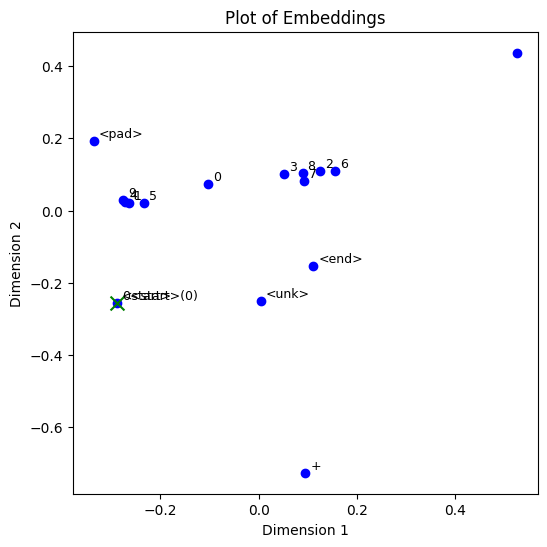

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]]
(1, 1, 4)
[[-0.5773521   0.48808908]]


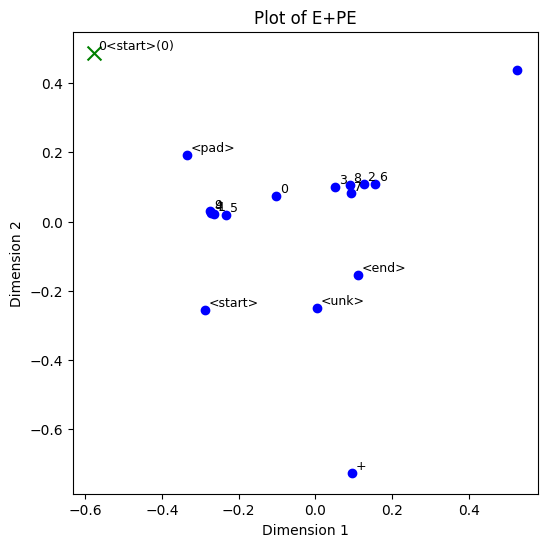

SelfAttention Layer
QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 1, 4])
WV.shape: torch.Size([1, 1, 4])
attn_weight.shape: torch.Size([1, 1, 1])
AV.shape: torch.Size([1, 1, 4])
[[[0.7114342  0.28344676 0.88825536 0.07920831]]]
(1, 1, 4)
[[0.7114342  0.28344676]]


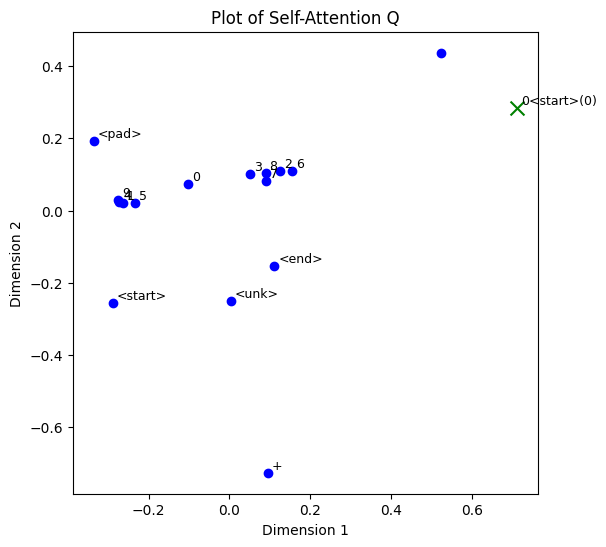

[[[ 1.3043206   0.17599078  0.46306953 -0.8162733 ]]]
(1, 1, 4)
[[1.3043206  0.17599078]]


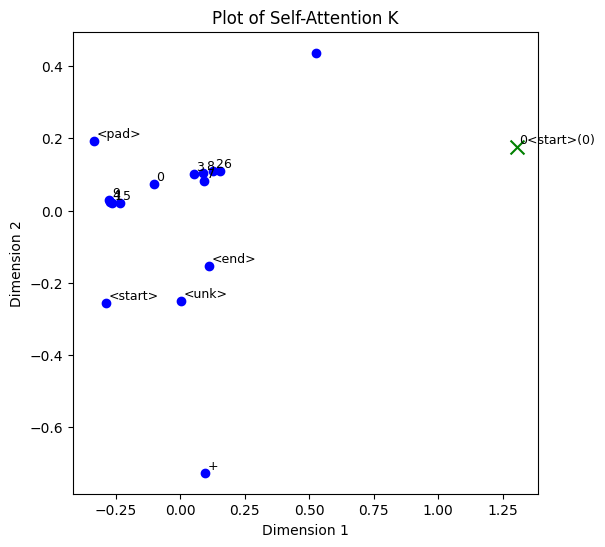

[[[-0.36121717  0.70498306 -0.00340728 -0.08988198]]]
(1, 1, 4)
[[-0.36121717  0.70498306]]


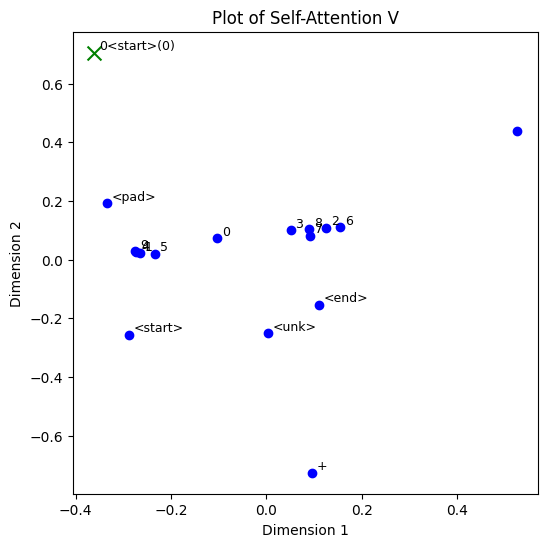

[[[-0.36121717  0.70498306 -0.00340728 -0.08988198]]]
(1, 1, 4)
[[-0.36121717  0.70498306]]


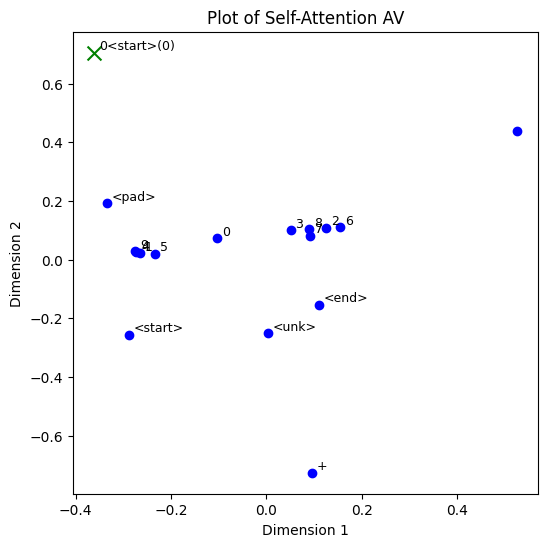

[[[ 0.21401761  0.3884038   0.8890478  -0.81734395]]]
(1, 1, 4)
[[0.21401761 0.3884038 ]]


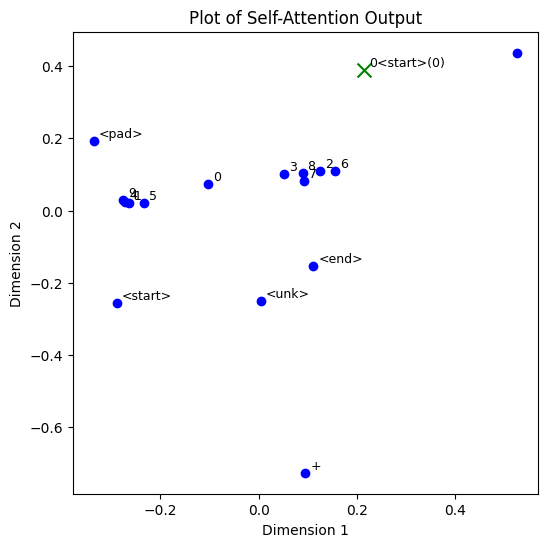

[[[-0.8866727   1.0658913   0.06324957 -1.1190953 ]]]
(1, 1, 4)
[[-0.8866727  1.0658913]]


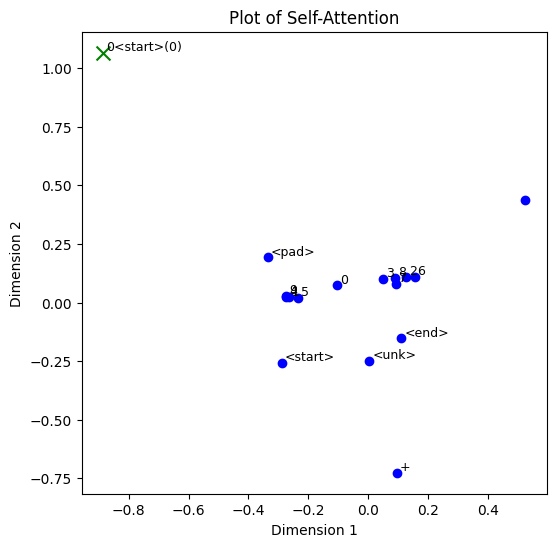

QV.shape: torch.Size([1, 1, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 1, 15])
AV.shape: torch.Size([1, 1, 4])
[[[-2.294246   -2.0609188   1.2717247  -0.48420772]]]
(1, 1, 4)
[[-2.294246  -2.0609188]]


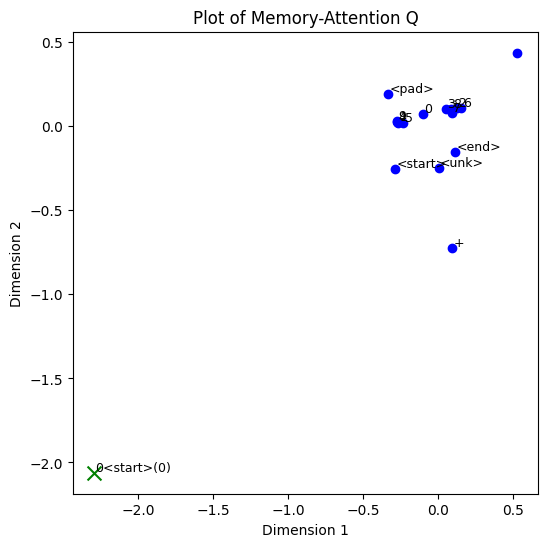

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

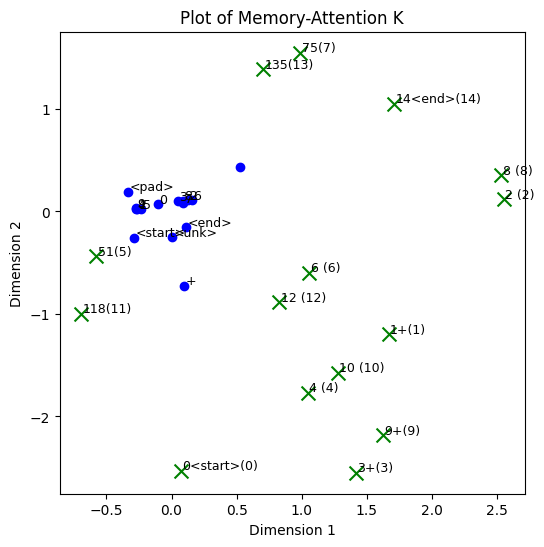

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

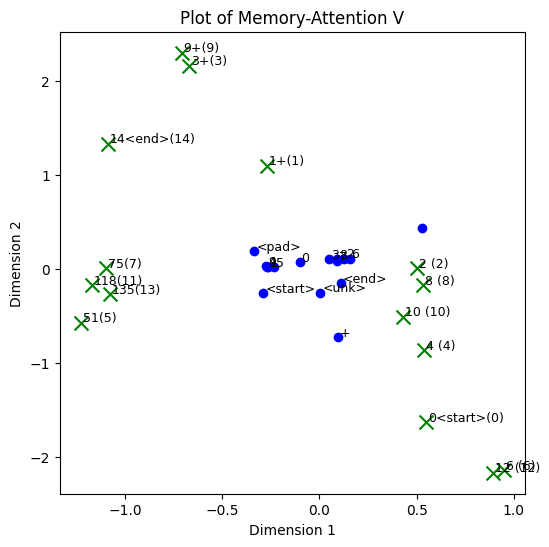

[[-0.35790607 -0.47992307 -0.21128401 -0.04298493]]
(1, 4)
[[-0.35790607 -0.47992307]]


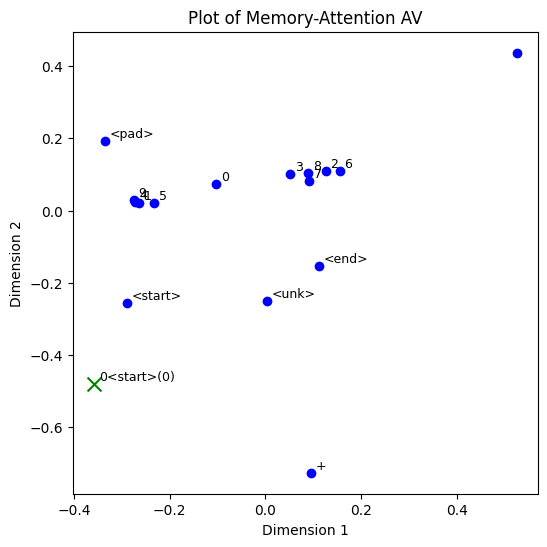

[[[ 0.21401761  0.3884038   0.8890478  -0.81734395]]]
(1, 1, 4)
[[0.21401761 0.3884038 ]]


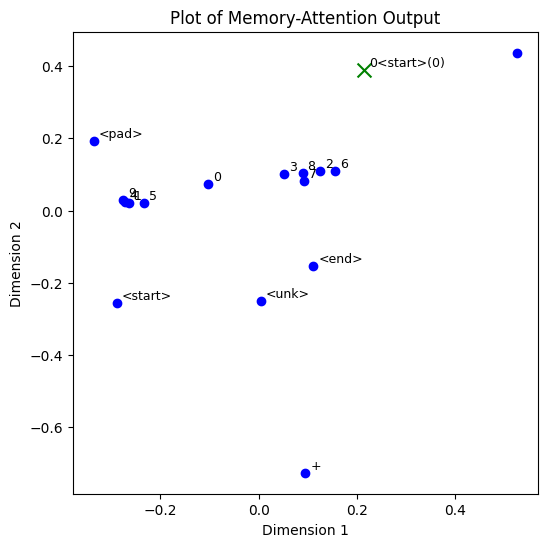

[[[ 0.0719564   0.15815096  1.2035879  -1.2492702 ]]]
(1, 1, 4)
[[0.0719564  0.15815096]]


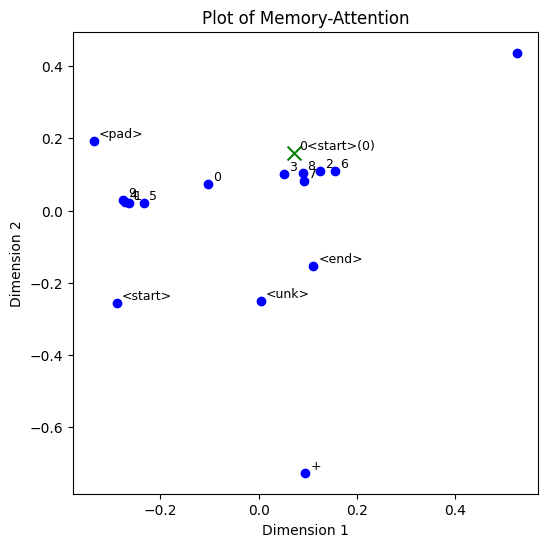

AfterLinear.shape: torch.Size([1, 1, 4])
AfterAddTGT.shape: torch.Size([1, 1, 4])
AfterAddTGT: tensor([[[ 0.7848,  0.0689,  3.8077, -4.2253]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[-6.3180, 13.4170, 12.2999,  1.1619, 11.3218, 12.5504, 13.4858, 11.1270,  8.4569,  5.2565,
          0.3240,  0.5355,  0.9083, -1.0100,  2.9381, -9.7267]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 6

------------------

iter: 1
ys: tensor([[12],
        [ 6]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]]], device='cuda:0')
now tgt: 6
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]]], device='cuda:0')
[[[-0.28867605 -0.25595546 -0.4976523  -0.3269529 ]]

 [[ 0.1549954   0.10985845  0.38566774 -0.06405345]]]
(2, 1, 4)
[[-0.28867605 -0.25595546]
 [ 0.1549954   0.10985845]]


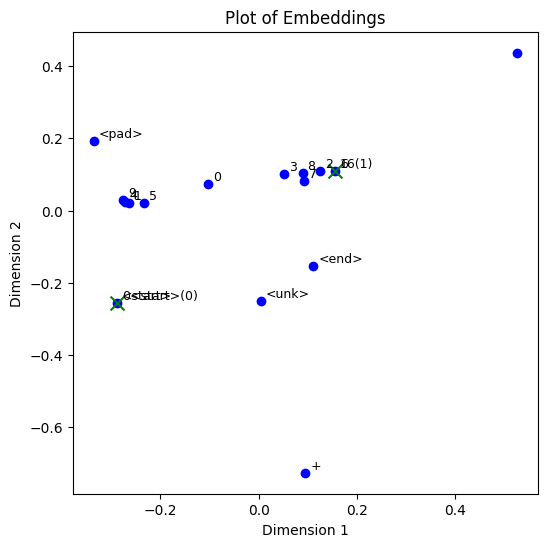

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]]
(2, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]]


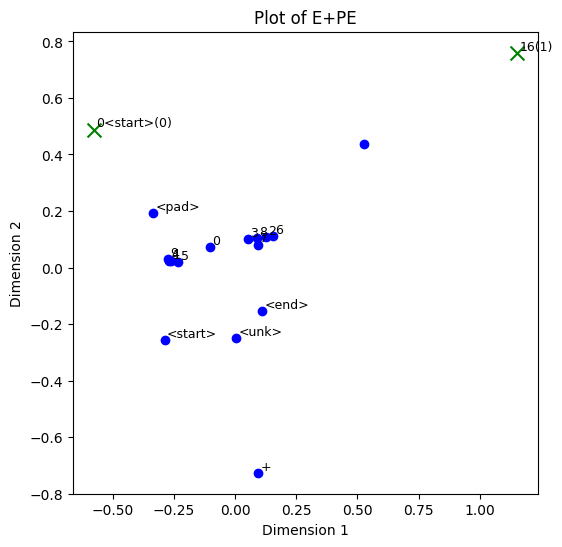

SelfAttention Layer
QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 2, 4])
WV.shape: torch.Size([1, 2, 4])
attn_weight.shape: torch.Size([1, 2, 2])
AV.shape: torch.Size([1, 2, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]]]
(1, 2, 4)
[[ 0.7114342  0.2834468]
 [ 0.505927  -2.0341296]]


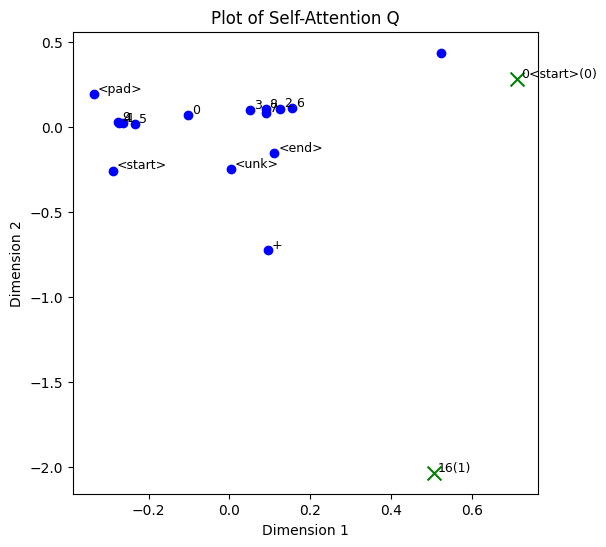

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]]]
(1, 2, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]]


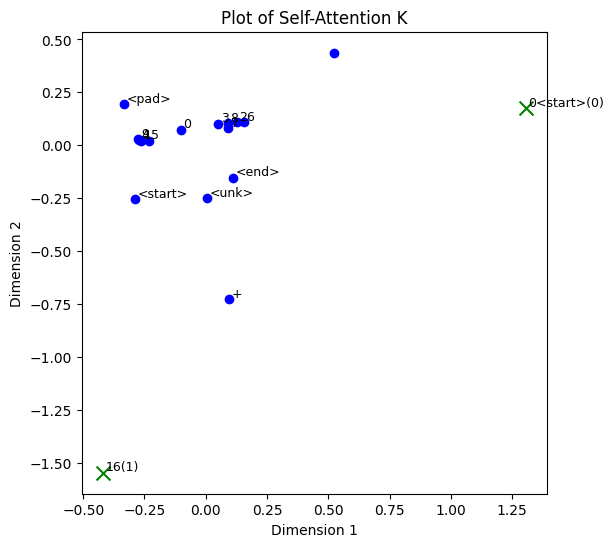

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]]]
(1, 2, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]]


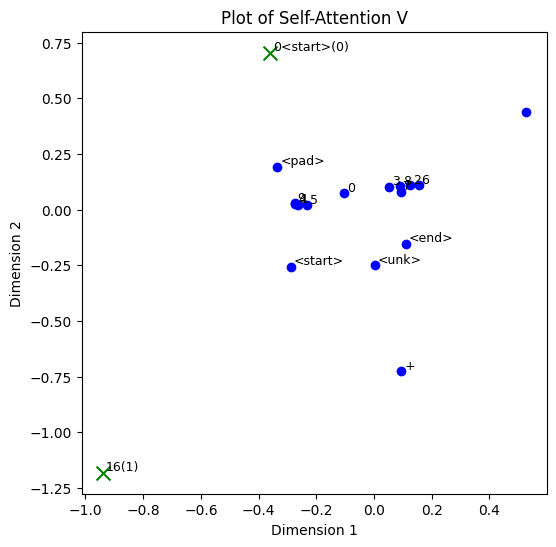

[[[-0.52533424  0.16996509 -0.3320676  -0.31763262]
  [-0.88283306 -0.9954732  -1.0479937  -0.81374556]]]
(1, 2, 4)
[[-0.52533424  0.16996509]
 [-0.88283306 -0.9954732 ]]


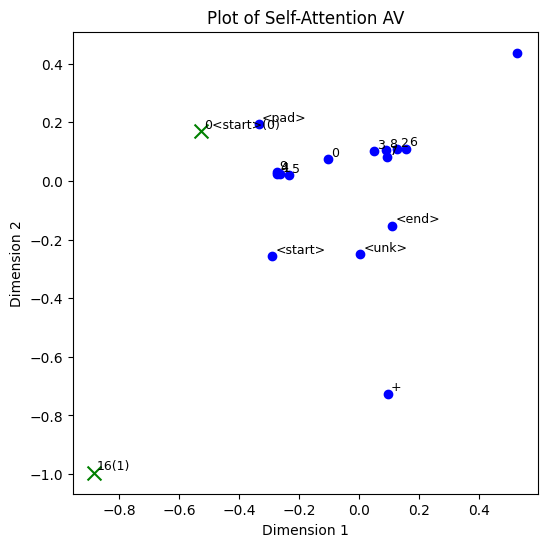

[[[-0.28278208  0.15879762  1.0075096  -0.13728018]]

 [[-1.3649689  -0.3413572   1.2655568   1.3441137 ]]]
(2, 1, 4)
[[-0.28278208  0.15879762]
 [-1.3649689  -0.3413572 ]]


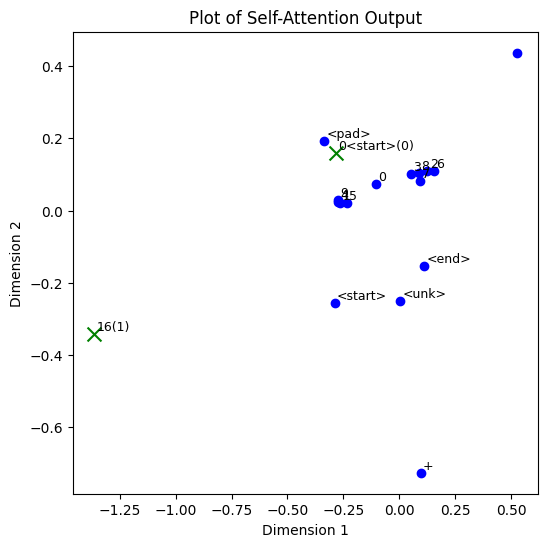

[[[-2.106609    0.65610635  0.2463078   0.47642356]]

 [[-1.7169929  -0.85544413  1.0975237   1.3550334 ]]]
(2, 1, 4)
[[-2.106609    0.65610635]
 [-1.7169929  -0.85544413]]


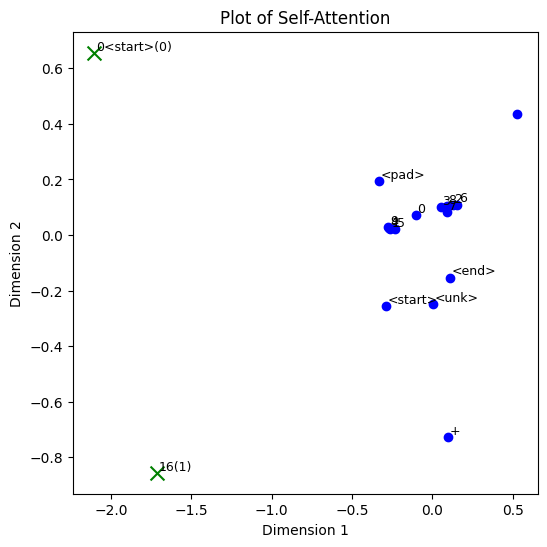

QV.shape: torch.Size([1, 2, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 2, 15])
AV.shape: torch.Size([1, 2, 4])
[[[-1.2958683 -3.9721203  4.091608   1.1523172]
  [ 0.7474808 -3.4450955  3.9246898  2.5394094]]]
(1, 2, 4)
[[-1.2958683 -3.9721203]
 [ 0.7474808 -3.4450955]]


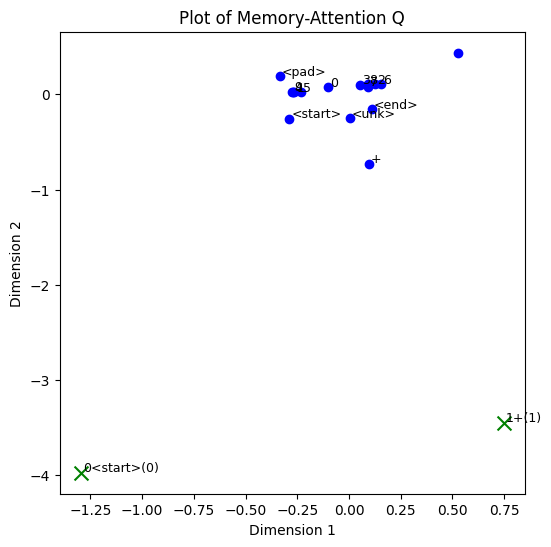

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

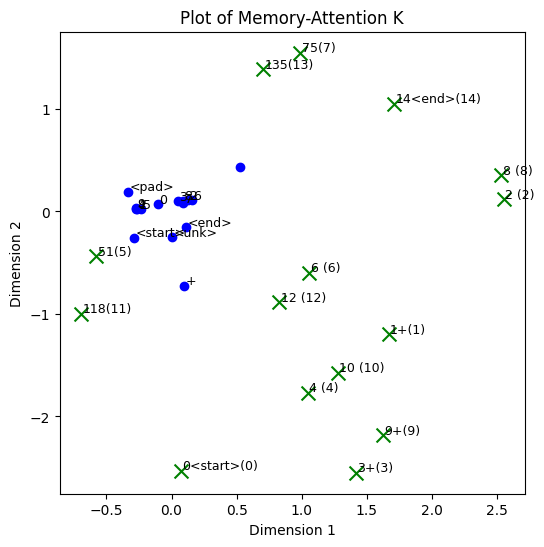

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

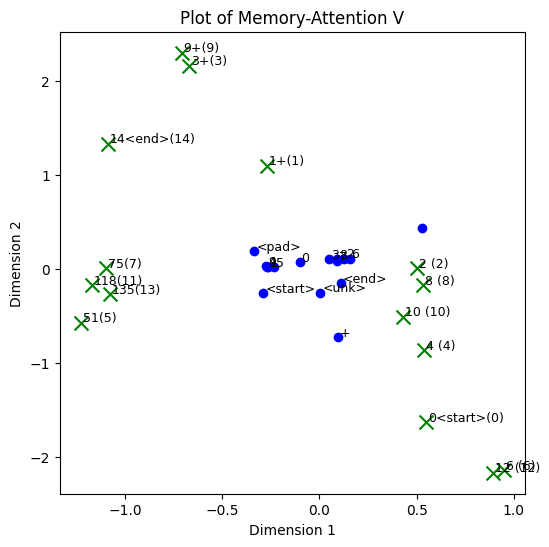

[[-0.57737404  1.8461113   2.0754263   0.6501498 ]
 [-0.6703204   2.158418    2.352285    0.6760269 ]]
(2, 4)
[[-0.57737404  1.8461113 ]
 [-0.6703204   2.158418  ]]


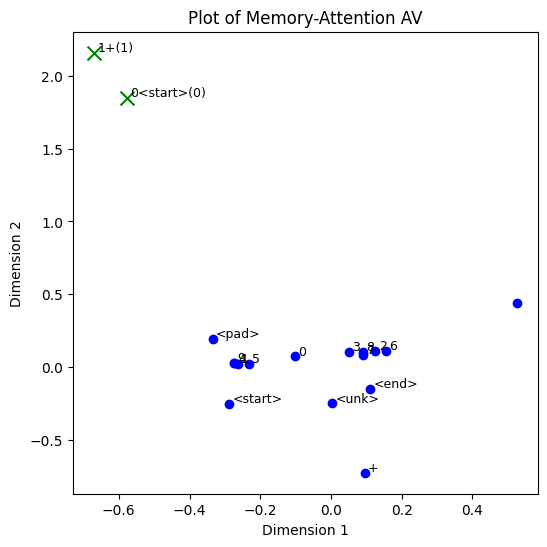

[[[-0.28278208  0.15879762  1.0075096  -0.13728018]]

 [[-1.3649689  -0.3413572   1.2655568   1.3441137 ]]]
(2, 1, 4)
[[-0.28278208  0.15879762]
 [-1.3649689  -0.3413572 ]]


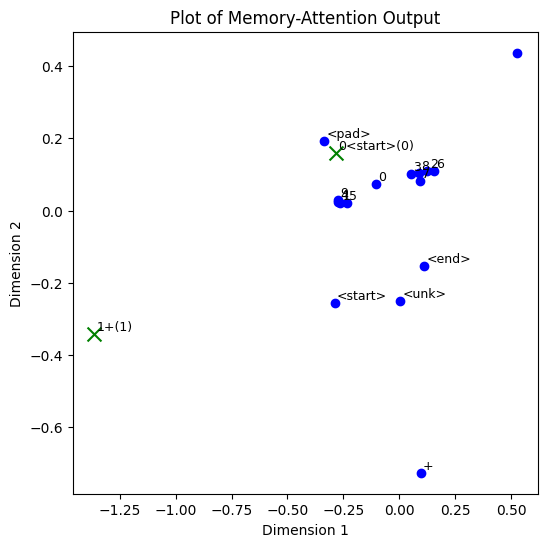

[[[-1.6417298   0.47789252  0.3979439   0.63129926]]

 [[-1.674124    0.15476823  0.5469404   0.78898656]]]
(2, 1, 4)
[[-1.6417298   0.47789252]
 [-1.674124    0.15476823]]


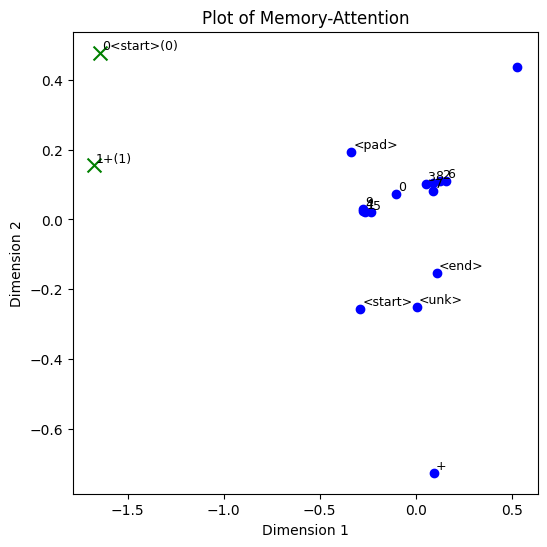

AfterLinear.shape: torch.Size([2, 1, 4])
AfterAddTGT.shape: torch.Size([2, 1, 4])
AfterAddTGT: tensor([[[-0.6709,  4.0301, -4.8023,  1.8691]],

        [[-2.8233,  2.9465, -3.6839,  3.4545]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  0.9510, -14.5994, -17.1495, -10.4630, -13.8217,  -8.8028, -14.8285,  -6.3328, -15.7098,
          -9.1350,  -1.0890,  -2.1860,  -1.9856,   0.4700,   3.1172,  13.1861]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 2
ys: tensor([[12],
        [ 6],
        [15]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]]], device='cuda:0')
now tgt: 6 
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]]], device='cuda:0')
[[[-0.

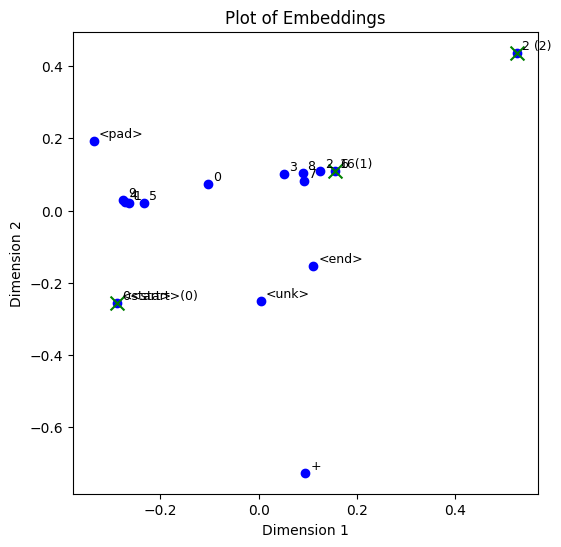

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]]
(3, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]]


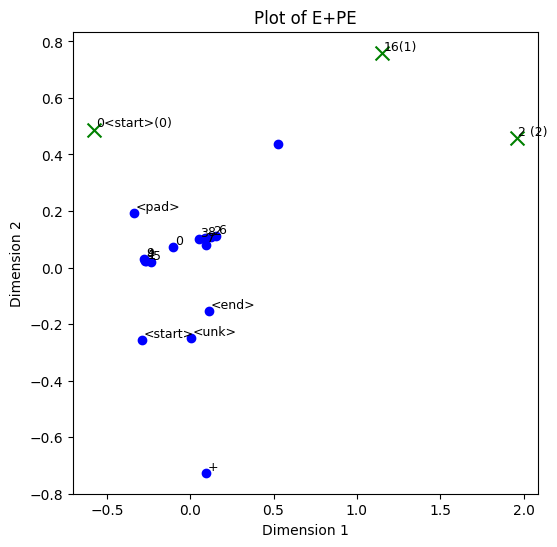

SelfAttention Layer
QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 3, 4])
WV.shape: torch.Size([1, 3, 4])
attn_weight.shape: torch.Size([1, 3, 3])
AV.shape: torch.Size([1, 3, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]]]
(1, 3, 4)
[[ 0.7114342  0.2834468]
 [ 0.505927  -2.0341296]
 [ 1.9474189 -0.9667186]]


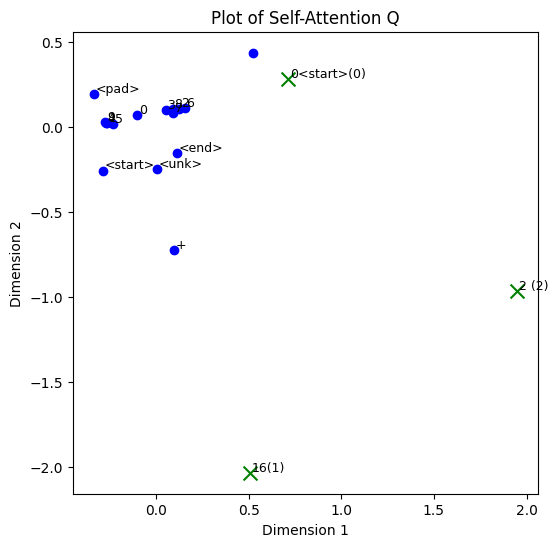

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]]]
(1, 3, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]]


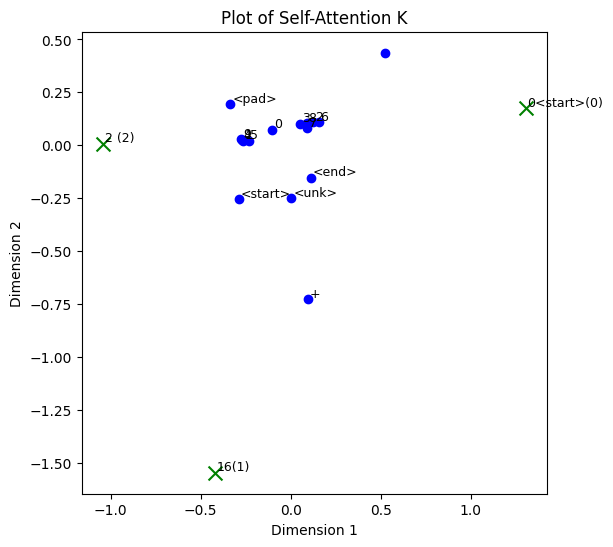

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]]]
(1, 3, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]]


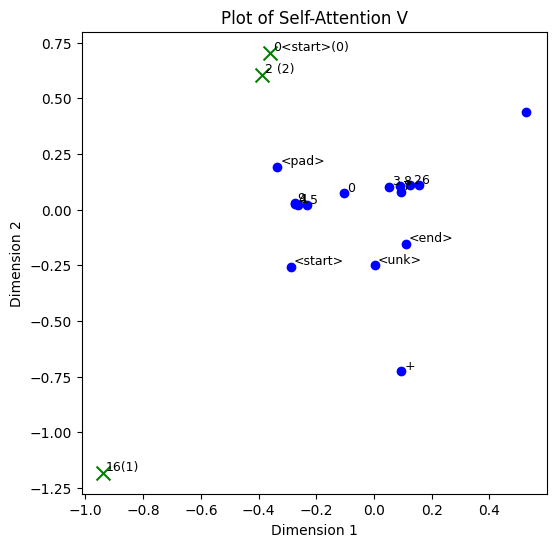

[[[-0.48856276  0.28588003 -0.50030816 -0.5950328 ]
  [-0.8242582  -0.80627614 -1.0379437  -0.8780885 ]
  [-0.3989659   0.5810924  -0.12974375 -0.21116446]]]
(1, 3, 4)
[[-0.48856276  0.28588003]
 [-0.8242582  -0.80627614]
 [-0.3989659   0.5810924 ]]


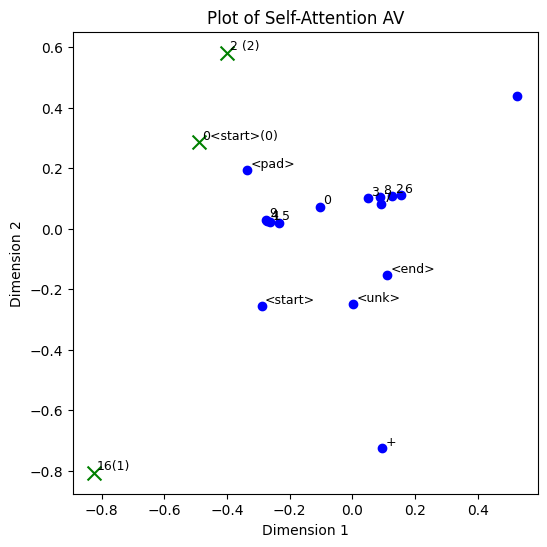

[[[-0.5204585   0.5234693   1.07615    -0.0509962 ]]

 [[-1.3424016  -0.12052038  1.2654815   1.2072159 ]]

 [[ 0.02653816  0.40130004  0.9362624  -0.6108567 ]]]
(3, 1, 4)
[[-0.5204585   0.5234693 ]
 [-1.3424016  -0.12052038]
 [ 0.02653816  0.40130004]]


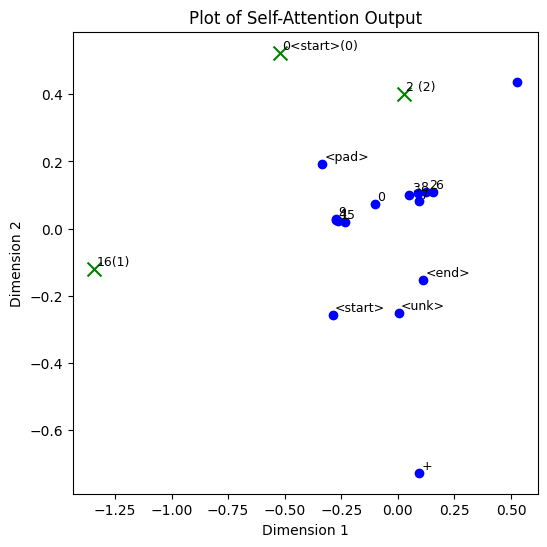

[[[-2.0672388   0.7065892   0.23889963  0.36798313]]

 [[-1.8548878  -0.733665    1.1384869   1.2424648 ]]

 [[ 1.9854283  -0.07058607 -0.6894973  -1.1229931 ]]]
(3, 1, 4)
[[-2.0672388   0.7065892 ]
 [-1.8548878  -0.733665  ]
 [ 1.9854283  -0.07058607]]


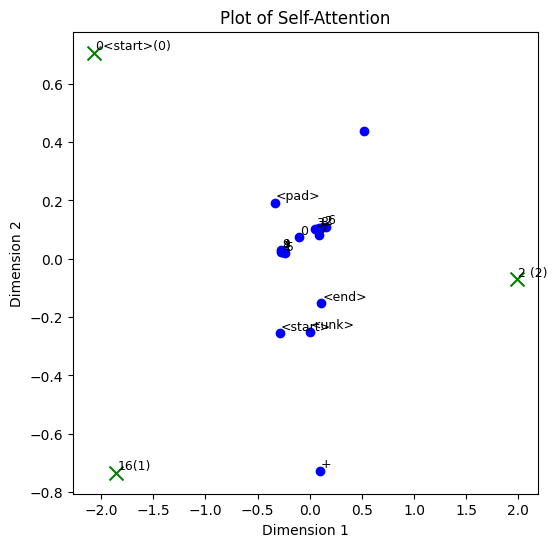

QV.shape: torch.Size([1, 3, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 3, 15])
AV.shape: torch.Size([1, 3, 4])
[[[-1.4060951  -3.927314    3.9787798   1.0543417 ]
  [ 0.47387373 -3.7637713   4.137649    2.518041  ]
  [ 0.27325654  3.7887292  -4.0263166  -1.7511153 ]]]
(1, 3, 4)
[[-1.4060951  -3.927314  ]
 [ 0.47387373 -3.7637713 ]
 [ 0.27325654  3.7887292 ]]


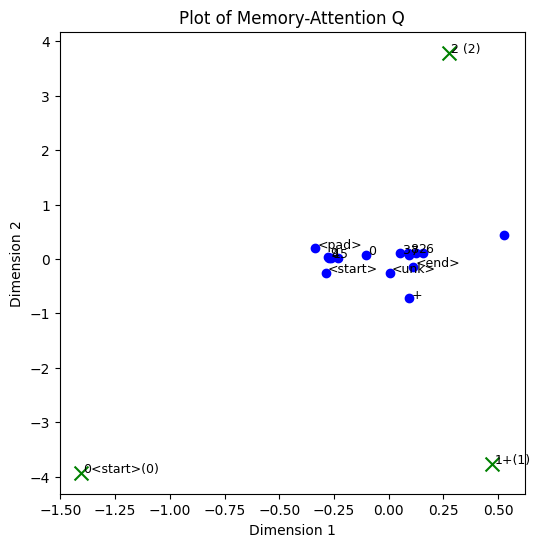

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

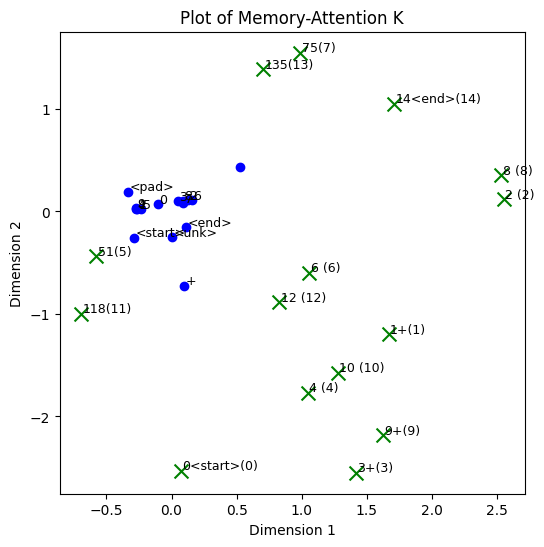

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

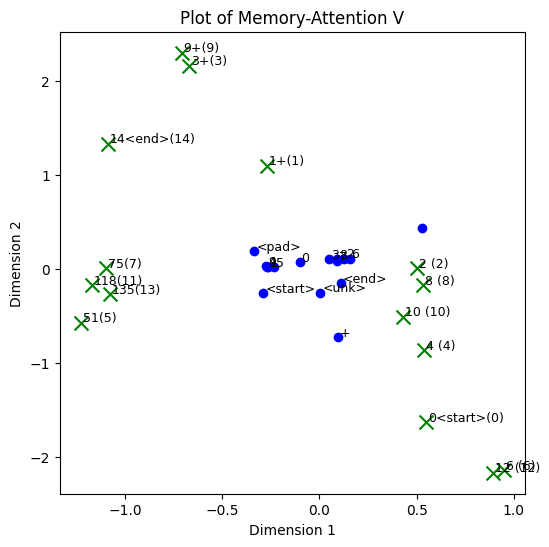

[[-0.55655295  1.7725242   2.0117493   0.642139  ]
 [-0.66927785  2.154354    2.3449013   0.6766317 ]
 [-0.8150784  -0.01867766  1.2128541   0.2077616 ]]
(3, 4)
[[-0.55655295  1.7725242 ]
 [-0.66927785  2.154354  ]
 [-0.8150784  -0.01867766]]


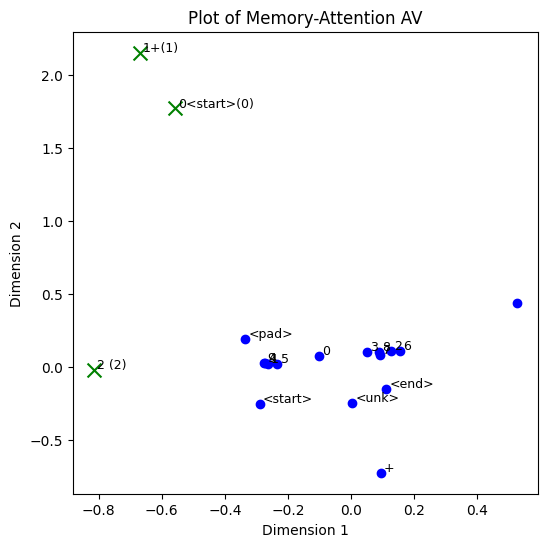

[[[-0.5204585   0.5234693   1.07615    -0.0509962 ]]

 [[-1.3424016  -0.12052038  1.2654815   1.2072159 ]]

 [[ 0.02653816  0.40130004  0.9362624  -0.6108567 ]]]
(3, 1, 4)
[[-0.5204585   0.5234693 ]
 [-1.3424016  -0.12052038]
 [ 0.02653816  0.40130004]]


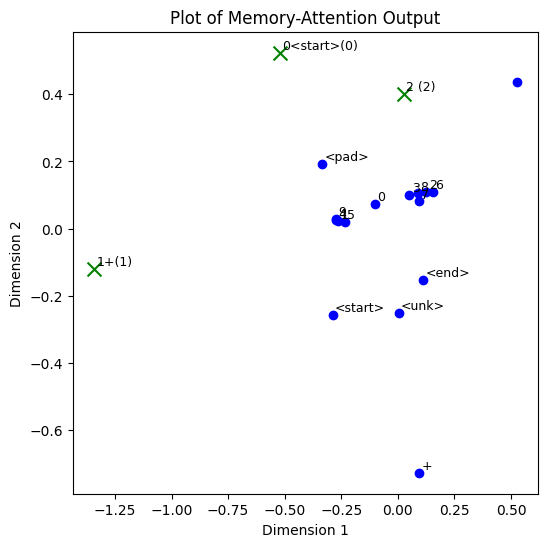

[[[-1.6409179   0.49313307  0.40340897  0.61423206]]

 [[-1.6776421   0.17966522  0.55702716  0.76430905]]

 [[ 0.06047494  0.2739825   1.1128225  -1.2553658 ]]]
(3, 1, 4)
[[-1.6409179   0.49313307]
 [-1.6776421   0.17966522]
 [ 0.06047494  0.2739825 ]]


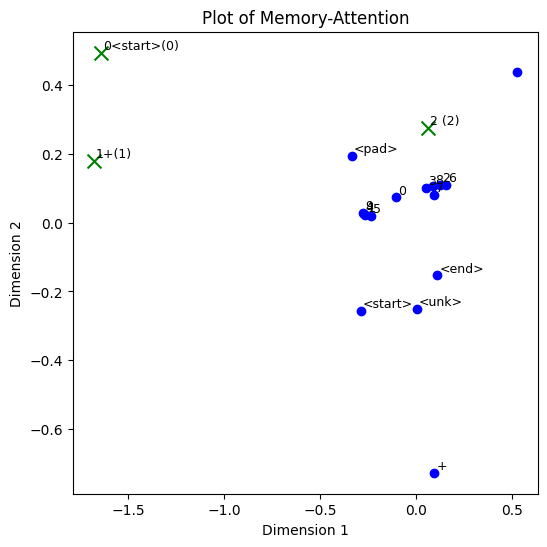

AfterLinear.shape: torch.Size([3, 1, 4])
AfterAddTGT.shape: torch.Size([3, 1, 4])
AfterAddTGT: tensor([[[-0.6136,  4.0637, -4.8134,  1.8051]],

        [[-2.7066,  3.0829, -3.7831,  3.3413]],

        [[ 0.0881,  2.8450,  2.4039, -4.6078]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[-9.0580, 13.4404,  4.0268, -6.7137,  9.8830, 15.1576,  7.4746, 10.5505, -0.3708,  3.6537,
         -0.4576, -0.0563,  0.6500, -5.1596,  9.3523, -6.8563]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 5

------------------

iter: 3
ys: tensor([[12],
        [ 6],
        [15],
        [ 5]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]],

        [[-0.3251, -0.9497,  0.6546,  2.6333]]], device='cuda:0')
now tgt: 6 5
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.760

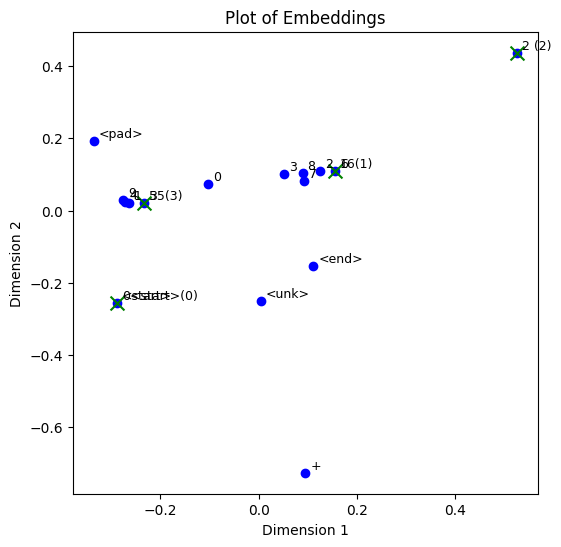

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]]
(4, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]]


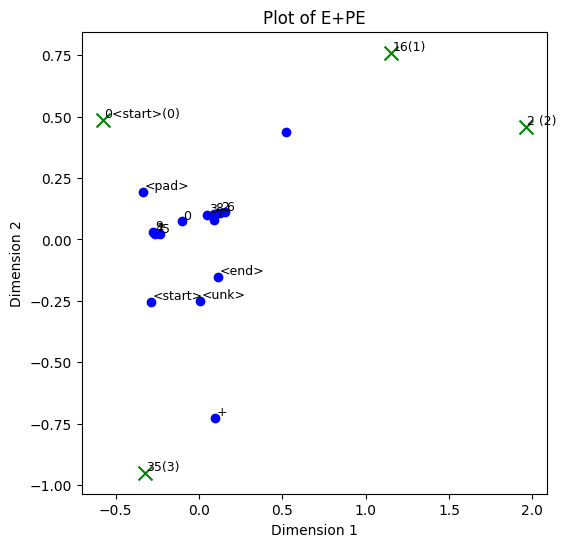

SelfAttention Layer
QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 4, 4])
WV.shape: torch.Size([1, 4, 4])
attn_weight.shape: torch.Size([1, 4, 4])
AV.shape: torch.Size([1, 4, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]]]
(1, 4, 4)
[[ 0.7114342  0.2834468]
 [ 0.505927  -2.0341296]
 [ 1.9474189 -0.9667186]
 [-2.532358  -1.0347031]]


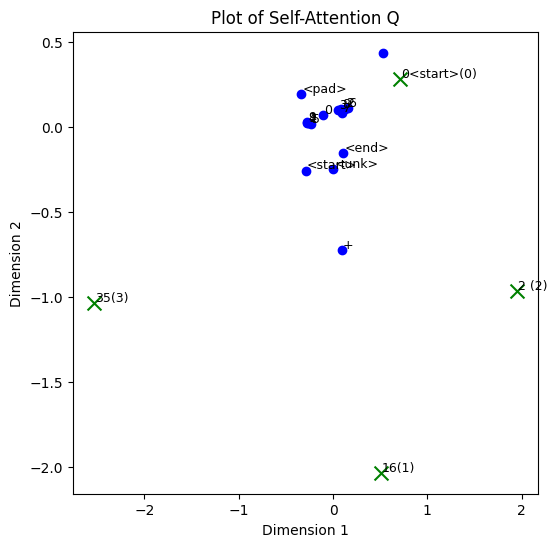

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]]]
(1, 4, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]]


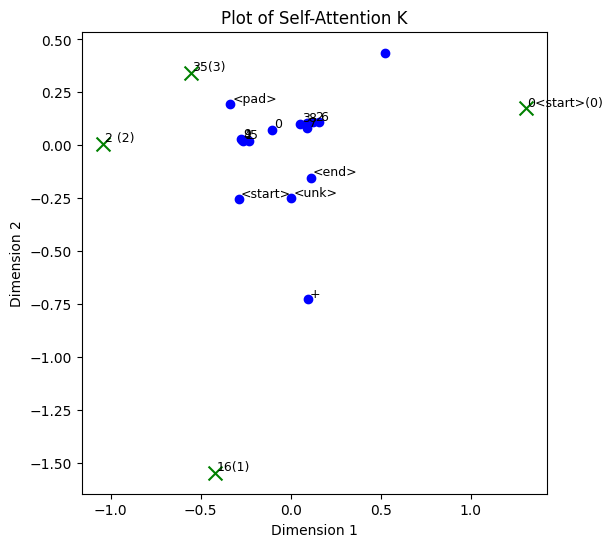

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]]]
(1, 4, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]]


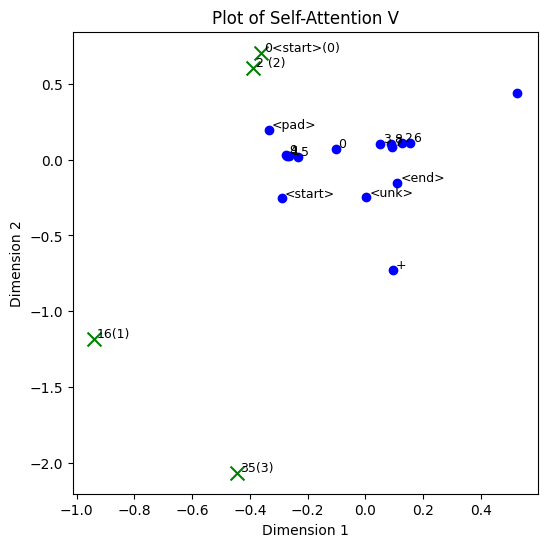

[[[-0.48422882  0.05322914 -0.5290055  -0.60174775]
  [-0.81586695 -0.8341069  -1.0324672  -0.87332976]
  [-0.39954305  0.5477549  -0.13806601 -0.21685582]
  [-0.7184289  -0.51138353 -1.0743695  -1.0613426 ]]]
(1, 4, 4)
[[-0.48422882  0.05322914]
 [-0.81586695 -0.8341069 ]
 [-0.39954305  0.5477549 ]
 [-0.7184289  -0.51138353]]


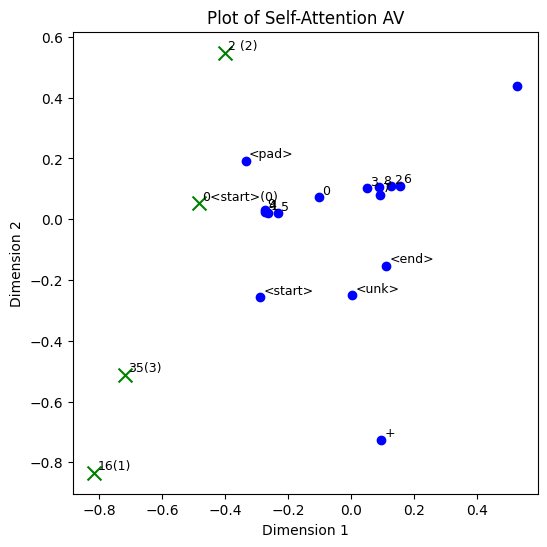

[[[-0.6223067   0.31832913  0.9926122   0.20801377]]

 [[-1.3469824  -0.15211448  1.2426305   1.2372643 ]]

 [[ 0.00668038  0.37672356  0.92739016 -0.57082915]]

 [[-1.3917997   0.30060127  1.2690344   1.0586406 ]]]
(4, 1, 4)
[[-0.6223067   0.31832913]
 [-1.3469824  -0.15211448]
 [ 0.00668038  0.37672356]
 [-1.3917997   0.30060127]]


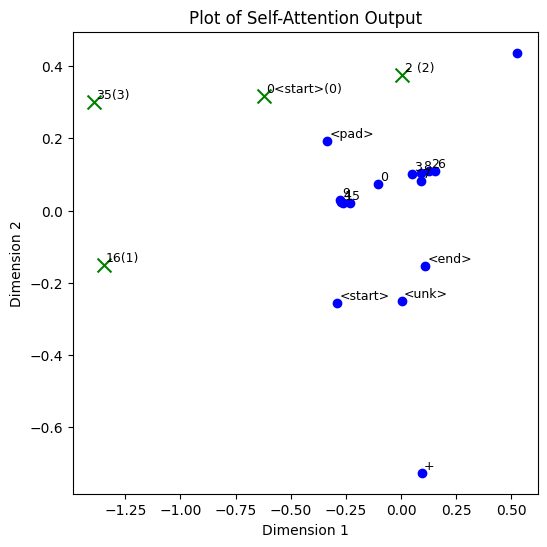

[[[-2.1470068   0.50520706  0.17494479  0.84953547]]

 [[-1.8363702  -0.7506674   1.1154917   1.2818834 ]]

 [[ 1.9956998  -0.08576518 -0.71126056 -1.0800496 ]]

 [[-1.5997663  -0.8690487   0.7368478   1.7419953 ]]]
(4, 1, 4)
[[-2.1470068   0.50520706]
 [-1.8363702  -0.7506674 ]
 [ 1.9956998  -0.08576518]
 [-1.5997663  -0.8690487 ]]


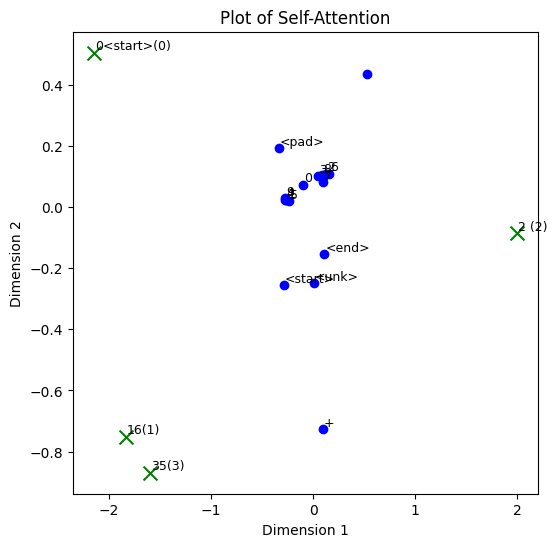

QV.shape: torch.Size([1, 4, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 4, 15])
AV.shape: torch.Size([1, 4, 4])
[[[-0.8694128  -3.89187     4.2878866   1.380938  ]
  [ 0.53433436 -3.7035027   4.1141744   2.5233803 ]
  [ 0.33061945  3.8338227  -4.033469   -1.740299  ]
  [ 1.2030443  -2.8989282   3.778216    2.479538  ]]]
(1, 4, 4)
[[-0.8694128  -3.89187   ]
 [ 0.53433436 -3.7035027 ]
 [ 0.33061945  3.8338227 ]
 [ 1.2030443  -2.8989282 ]]


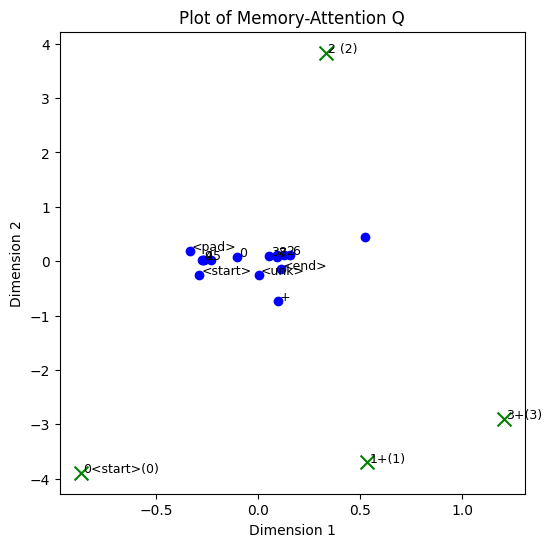

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

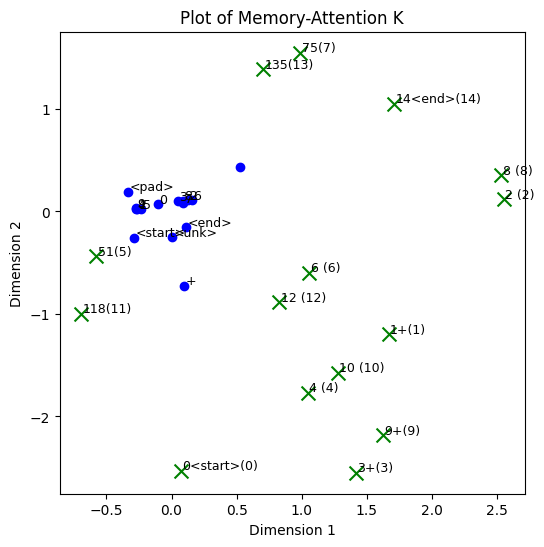

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

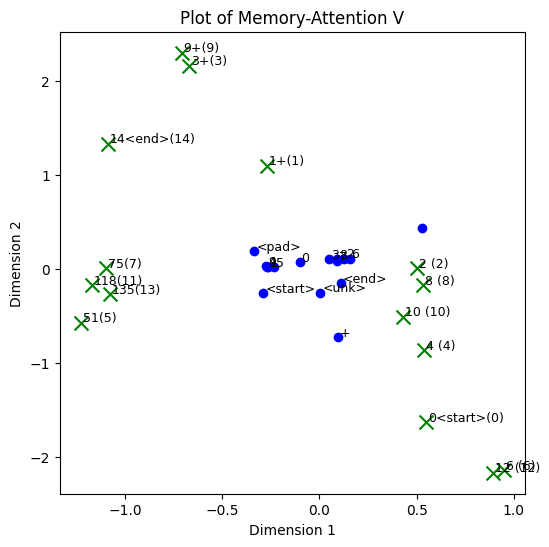

[[-0.61921734  1.9887705   2.1995344   0.6636607 ]
 [-0.66965383  2.1556509   2.3466606   0.6765617 ]
 [-0.8102777  -0.01458019  1.222248    0.2107384 ]
 [-0.6717492   2.164215    2.3637512   0.67494816]]
(4, 4)
[[-0.61921734  1.9887705 ]
 [-0.66965383  2.1556509 ]
 [-0.8102777  -0.01458019]
 [-0.6717492   2.164215  ]]


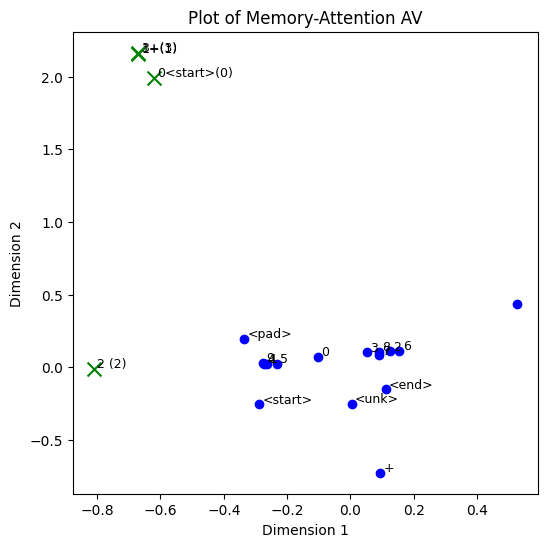

[[[-0.6223067   0.31832913  0.9926122   0.20801377]]

 [[-1.3469824  -0.15211448  1.2426305   1.2372643 ]]

 [[ 0.00668038  0.37672356  0.92739016 -0.57082915]]

 [[-1.3917997   0.30060127  1.2690344   1.0586406 ]]]
(4, 1, 4)
[[-0.6223067   0.31832913]
 [-1.3469824  -0.15211448]
 [ 0.00668038  0.37672356]
 [-1.3917997   0.30060127]]


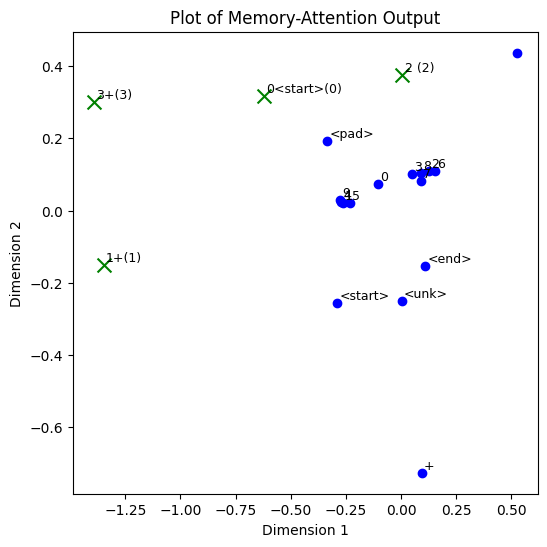

[[[-1.638997    0.43511426  0.3663444   0.68823993]]

 [[-1.6763511   0.17551002  0.5511763   0.7712413 ]]

 [[ 0.04800128  0.28792286  1.1093454  -1.2526942 ]]

 [[-1.6539416   0.143916    0.4586643   0.8525311 ]]]
(4, 1, 4)
[[-1.638997    0.43511426]
 [-1.6763511   0.17551002]
 [ 0.04800128  0.28792286]
 [-1.6539416   0.143916  ]]


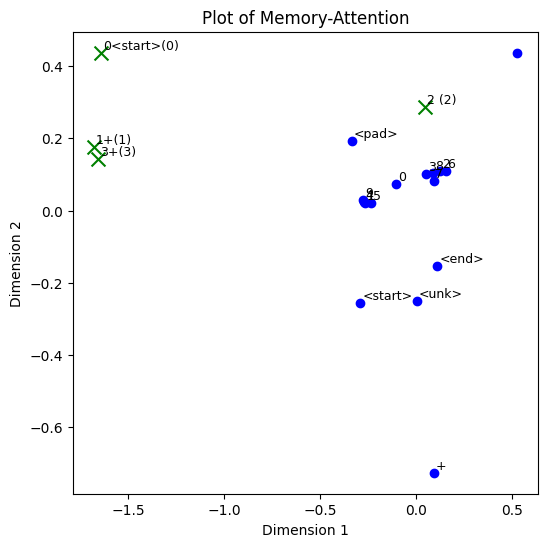

AfterLinear.shape: torch.Size([4, 1, 4])
AfterAddTGT.shape: torch.Size([4, 1, 4])
AfterAddTGT: tensor([[[-0.8008,  3.9162, -4.7795,  2.0469]],

        [[-2.7132,  3.0603, -3.7762,  3.3587]],

        [[-0.1860,  2.8689,  2.5352, -4.5284]],

        [[-2.6143,  2.8882, -3.8255,  3.4662]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  1.2083, -14.4470, -17.2400, -10.3232, -13.4986,  -8.9404, -15.1086,  -6.8053, -15.6646,
          -8.7053,  -1.1361,  -2.2459,  -2.0500,   0.0596,   3.2427,  13.0687]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 4
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]],

        [[-0.3251, -0.9497,  0.6546,  2.6333]],

        [[ 0.2935,  0.2206, -1.1893

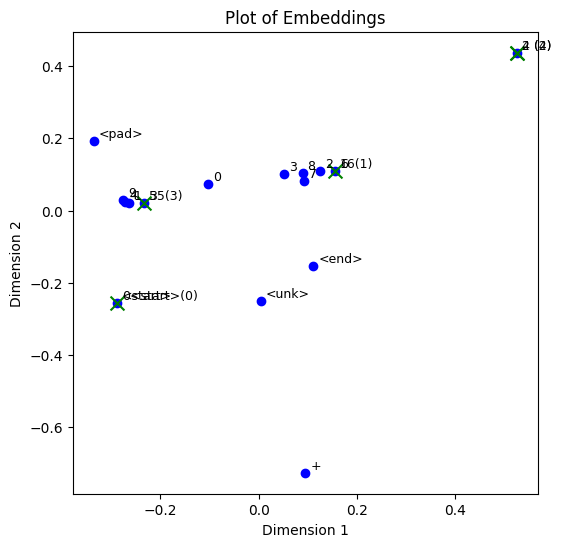

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]

 [[ 0.29346734  0.22062886 -1.1892636   0.41529012]]]
(5, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]
 [ 0.29346734  0.22062886]]


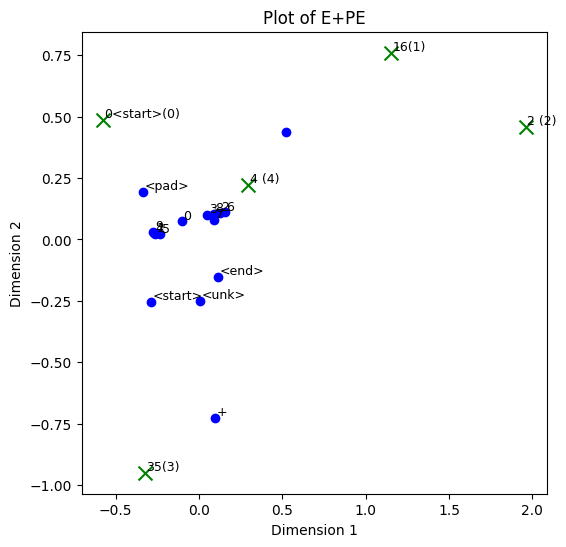

SelfAttention Layer
QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 5, 4])
WV.shape: torch.Size([1, 5, 4])
attn_weight.shape: torch.Size([1, 5, 5])
AV.shape: torch.Size([1, 5, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]
  [ 0.965866    0.07053957  1.4842246  -0.3846688 ]]]
(1, 5, 4)
[[ 0.7114342   0.2834468 ]
 [ 0.505927   -2.0341296 ]
 [ 1.9474189  -0.9667186 ]
 [-2.532358   -1.0347031 ]
 [ 0.965866    0.07053957]]


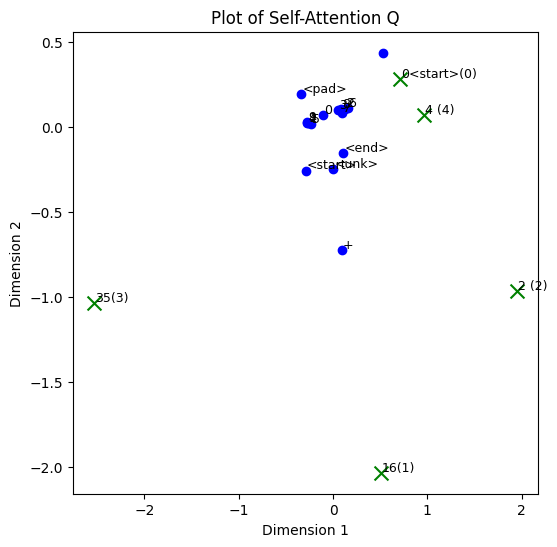

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]
  [ 0.33235416  0.45209563  0.41340655 -0.4876575 ]]]
(1, 5, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]
 [ 0.33235416  0.45209563]]


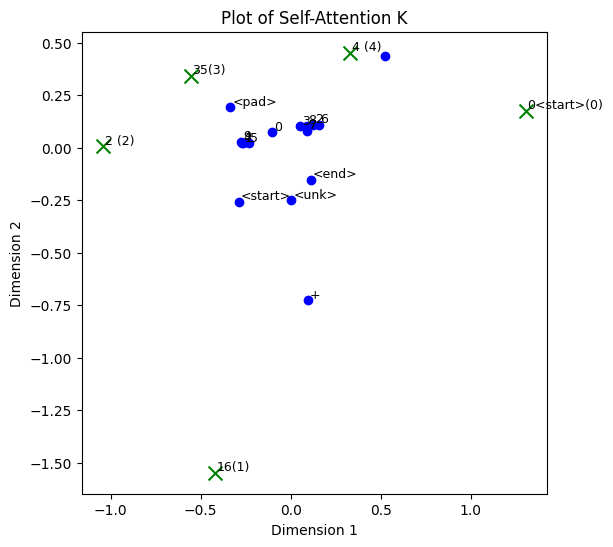

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]
  [-0.22209424  0.71188325 -0.25376043 -0.5252558 ]]]
(1, 5, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]
 [-0.22209424  0.71188325]]


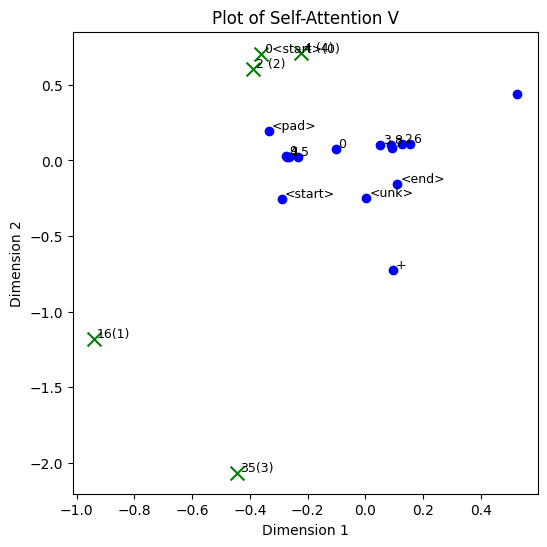

[[[-0.4169517   0.22227326 -0.4583636  -0.58211595]
  [-0.7848143  -0.753256   -0.9917431  -0.8551265 ]
  [-0.36476415  0.57992303 -0.16074139 -0.27730027]
  [-0.71009326 -0.4908396  -1.060588   -1.0523394 ]
  [-0.37484095  0.4317059  -0.31560162 -0.45493942]]]
(1, 5, 4)
[[-0.4169517   0.22227326]
 [-0.7848143  -0.753256  ]
 [-0.36476415  0.57992303]
 [-0.71009326 -0.4908396 ]
 [-0.37484095  0.4317059 ]]


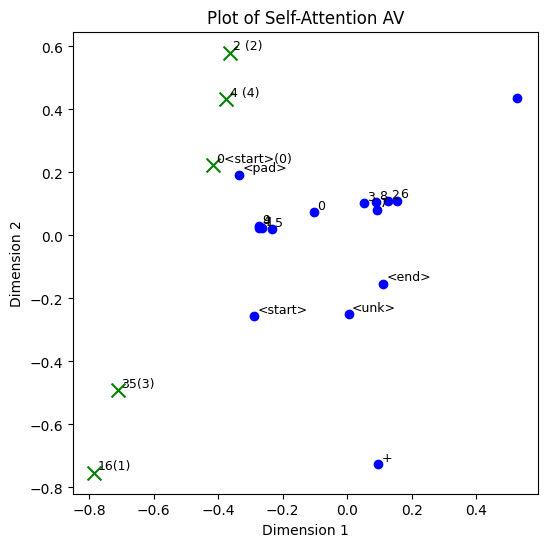

[[[-0.5202352   0.44001684  0.94911724  0.03678482]]

 [[-1.288285   -0.10271552  1.2206924   1.1485465 ]]

 [[-0.03864932  0.45820662  0.906958   -0.5489414 ]]

 [[-1.3721974   0.30886188  1.2615459   1.0331504 ]]

 [[-0.29058728  0.498103    0.9231588  -0.26506054]]]
(5, 1, 4)
[[-0.5202352   0.44001684]
 [-1.288285   -0.10271552]
 [-0.03864932  0.45820662]
 [-1.3721974   0.30886188]
 [-0.29058728  0.498103  ]]


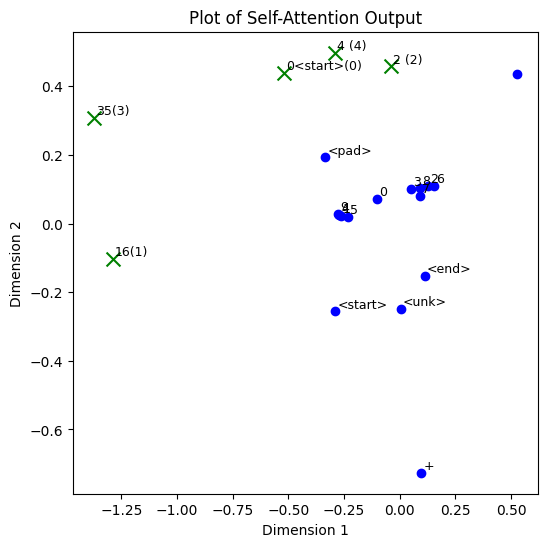

[[[-2.0549507   0.6695852   0.11288127  0.58219326]]

 [[-1.8566363  -0.73205346  1.1447055   1.2333486 ]]

 [[ 1.9373201  -0.01730518 -0.75434947 -1.0740488 ]]

 [[-1.5992615  -0.869849    0.73805314  1.7411652 ]]

 [[-0.5686043   0.9829579  -0.9003478  -0.01633094]]]
(5, 1, 4)
[[-2.0549507   0.6695852 ]
 [-1.8566363  -0.73205346]
 [ 1.9373201  -0.01730518]
 [-1.5992615  -0.869849  ]
 [-0.5686043   0.9829579 ]]


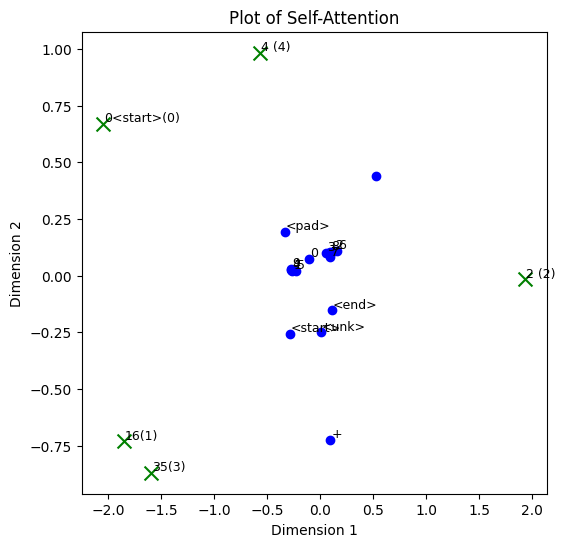

QV.shape: torch.Size([1, 5, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 5, 15])
AV.shape: torch.Size([1, 5, 4])
[[[-1.1694479  -3.7660458   4.008535    1.0998024 ]
  [ 0.46298683 -3.7734337   4.1387663   2.5171406 ]
  [ 0.2556485   3.7498438  -3.9370346  -1.7640934 ]
  [ 1.2030766  -2.898916    3.7772808   2.479917  ]
  [-0.9786221  -0.57108045  0.8976927  -0.5921389 ]]]
(1, 5, 4)
[[-1.1694479  -3.7660458 ]
 [ 0.46298683 -3.7734337 ]
 [ 0.2556485   3.7498438 ]
 [ 1.2030766  -2.898916  ]
 [-0.9786221  -0.57108045]]


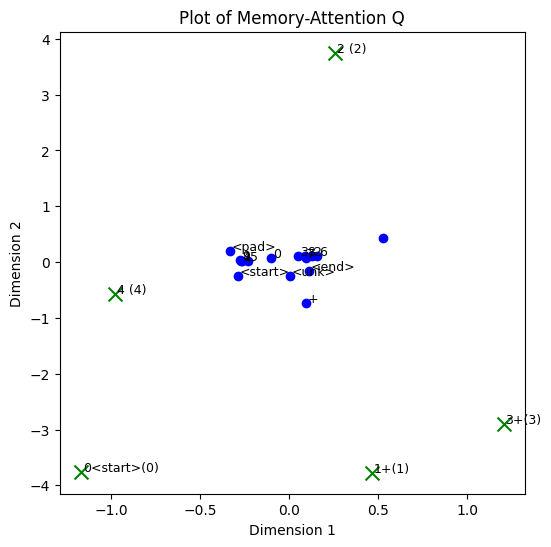

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

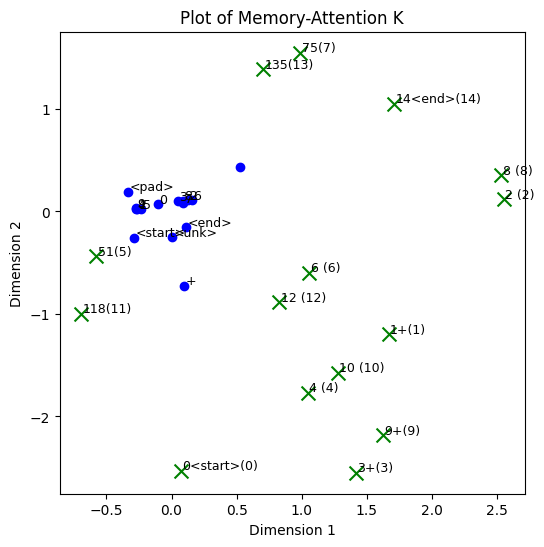

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

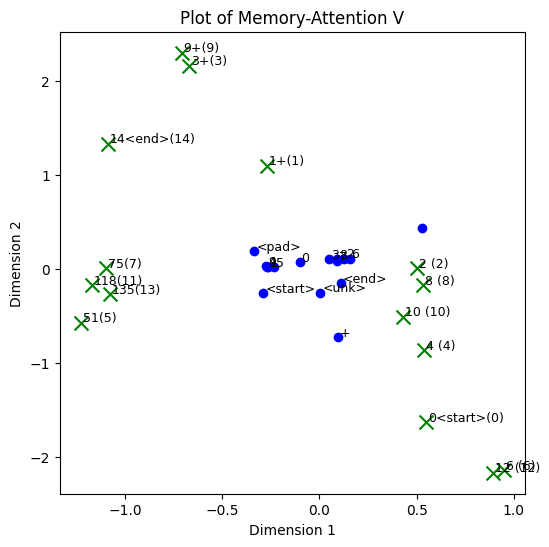

[[-0.5777362   1.8441023   2.0753329   0.64850545]
 [-0.6691934   2.1540737   2.344568    0.676637  ]
 [-0.82341266 -0.01996095  1.2037752   0.20330144]
 [-0.6717476   2.164212    2.3637536   0.67494726]
 [-0.4838802  -0.30440497  0.12529291 -0.00723923]]
(5, 4)
[[-0.5777362   1.8441023 ]
 [-0.6691934   2.1540737 ]
 [-0.82341266 -0.01996095]
 [-0.6717476   2.164212  ]
 [-0.4838802  -0.30440497]]


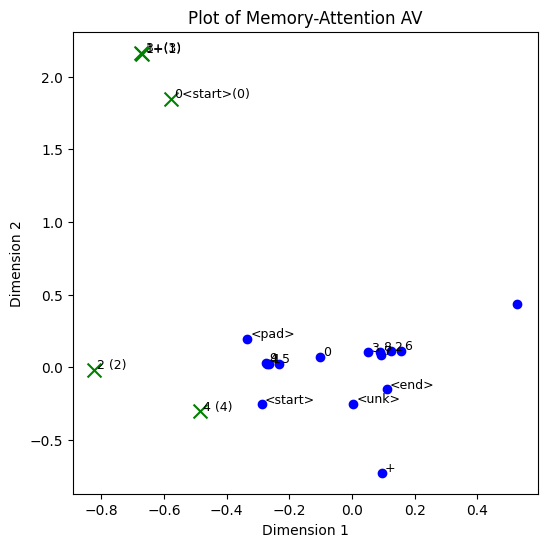

[[[-0.5202352   0.44001684  0.94911724  0.03678482]]

 [[-1.288285   -0.10271552  1.2206924   1.1485465 ]]

 [[-0.03864932  0.45820662  0.906958   -0.5489414 ]]

 [[-1.3721974   0.30886188  1.2615459   1.0331504 ]]

 [[-0.29058728  0.498103    0.9231588  -0.26506054]]]
(5, 1, 4)
[[-0.5202352   0.44001684]
 [-1.288285   -0.10271552]
 [-0.03864932  0.45820662]
 [-1.3721974   0.30886188]
 [-0.29058728  0.498103  ]]


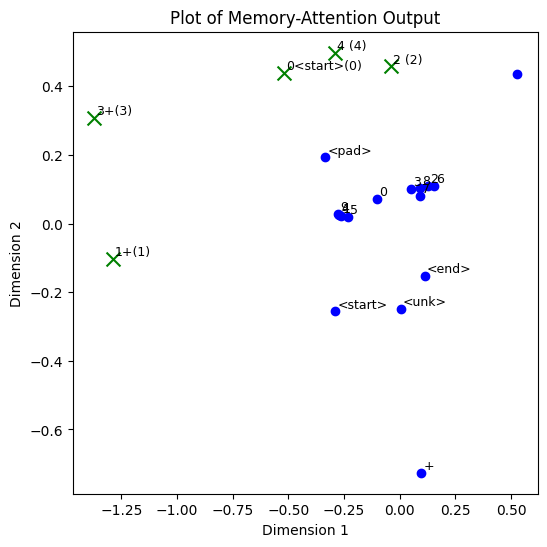

[[[-1.6348848   0.48025432  0.36500338  0.65059775]]

 [[-1.6779511   0.18021442  0.55861485  0.76284385]]

 [[ 0.01679051  0.3769164   1.0496671  -1.2464257 ]]

 [[-1.6539983   0.14378364  0.45895147  0.85244733]]

 [[-0.7330566   1.2016183   0.3748059  -0.69348526]]]
(5, 1, 4)
[[-1.6348848   0.48025432]
 [-1.6779511   0.18021442]
 [ 0.01679051  0.3769164 ]
 [-1.6539983   0.14378364]
 [-0.7330566   1.2016183 ]]


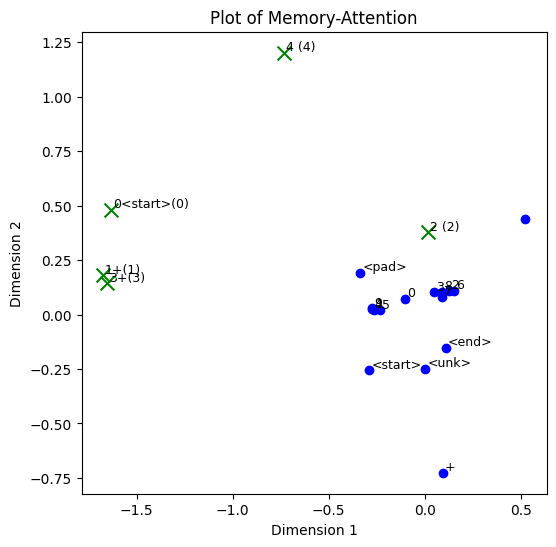

AfterLinear.shape: torch.Size([5, 1, 4])
AfterAddTGT.shape: torch.Size([5, 1, 4])
AfterAddTGT: tensor([[[-0.5951,  4.0082, -4.8313,  1.8527]],

        [[-2.7082,  3.0859, -3.7823,  3.3393]],

        [[ 0.5794,  3.9195,  1.0136, -4.5735]],

        [[-2.6159,  2.8875, -3.8242,  3.4669]],

        [[ 2.1553,  4.4107, -4.4006, -1.1294]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[ -2.2082,   3.8244, -15.1093, -13.2017,   4.1159,   4.2333, -13.6729,  -6.7020, -14.7934,
           4.6868,  -2.3961,  -2.7319,  -2.0226, -14.5150,  15.0924,   2.6053]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 14

------------------

iter: 5
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15],
        [14]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

        [[ 1.9596,  0.4581, -1.2093,  0.4159]],

        [[-0.3251, -0

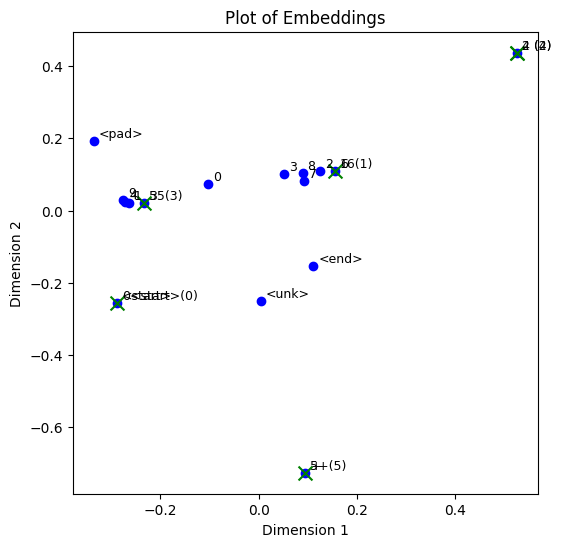

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]

 [[ 0.29346734  0.22062886 -1.1892636   0.41529012]]

 [[-0.768994   -1.168677   -0.41812384  0.06390113]]]
(6, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]
 [ 0.29346734  0.22062886]
 [-0.768994   -1.168677  ]]


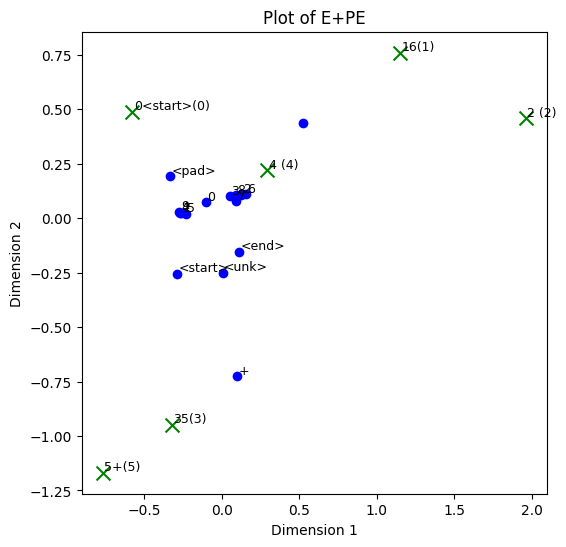

SelfAttention Layer
QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 6, 4])
WV.shape: torch.Size([1, 6, 4])
attn_weight.shape: torch.Size([1, 6, 6])
AV.shape: torch.Size([1, 6, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]
  [ 0.965866    0.07053957  1.4842246  -0.3846688 ]
  [-0.83484656  1.4373012   0.5792201  -0.5744088 ]]]
(1, 6, 4)
[[ 0.7114342   0.2834468 ]
 [ 0.505927   -2.0341296 ]
 [ 1.9474189  -0.9667186 ]
 [-2.532358   -1.0347031 ]
 [ 0.965866    0.07053957]
 [-0.83484656  1.4373012 ]]


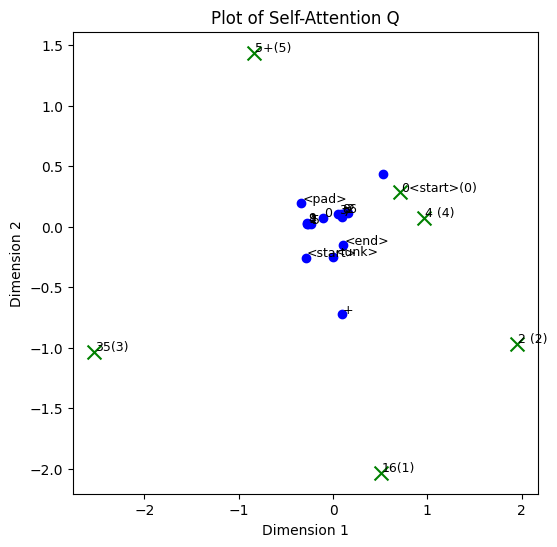

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]
  [ 0.33235416  0.45209563  0.41340655 -0.4876575 ]
  [ 0.3828183   1.4692954  -0.64528066 -1.9975775 ]]]
(1, 6, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]
 [ 0.33235416  0.45209563]
 [ 0.3828183   1.4692954 ]]


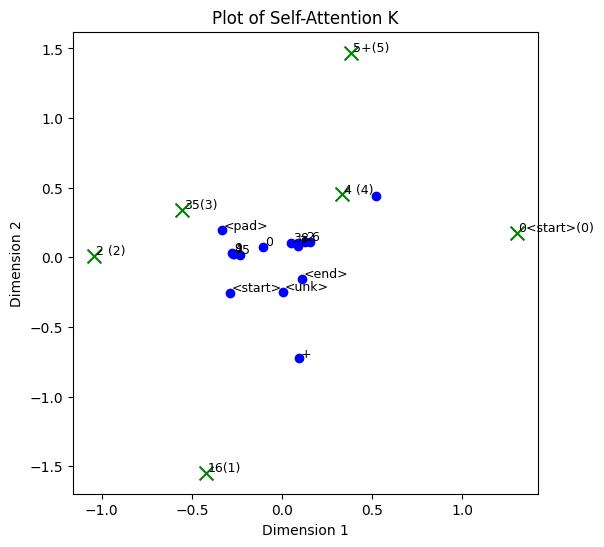

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]
  [-0.22209424  0.71188325 -0.25376043 -0.5252558 ]
  [ 0.5861341   0.13321787  0.69309384  0.43203232]]]
(1, 6, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]
 [-0.22209424  0.71188325]
 [ 0.5861341   0.13321787]]


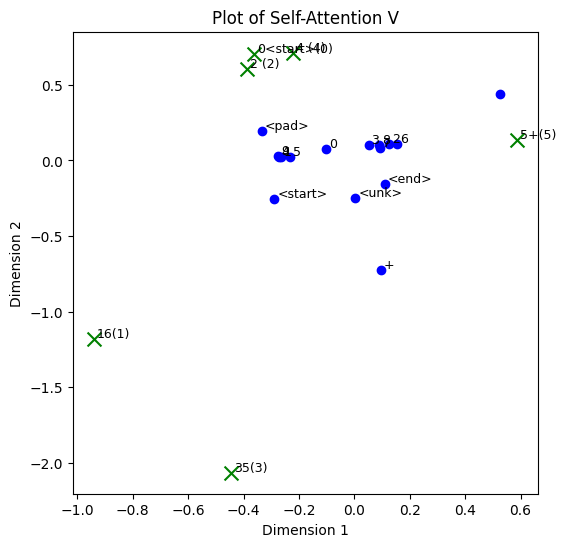

[[[-0.26563212  0.20883891 -0.28466153 -0.42912754]
  [-0.7739991  -0.74626285 -0.9784517  -0.8449724 ]
  [-0.30092376  0.54993266 -0.10341749 -0.22967786]
  [-0.7071248  -0.48941046 -1.0565721  -1.0489402 ]
  [-0.2298602   0.38667348 -0.16342136 -0.32112345]
  [ 0.01509078  0.02512029 -0.05153434 -0.24923755]]]
(1, 6, 4)
[[-0.26563212  0.20883891]
 [-0.7739991  -0.74626285]
 [-0.30092376  0.54993266]
 [-0.7071248  -0.48941046]
 [-0.2298602   0.38667348]
 [ 0.01509078  0.02512029]]


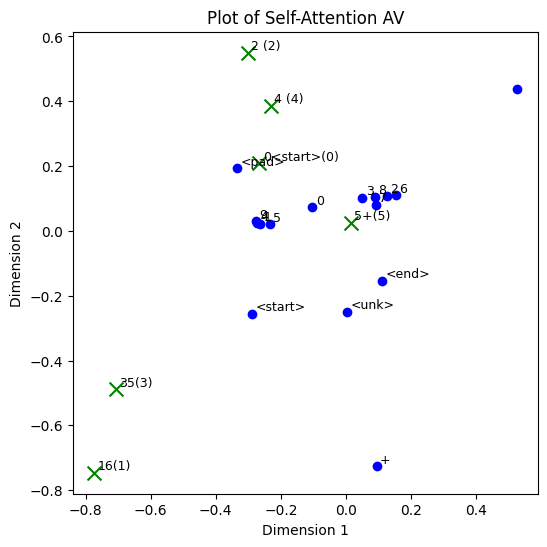

[[[-0.35179946  0.2619231   0.68771607  0.00308626]]

 [[-1.2734178  -0.10774735  1.20488     1.1380138 ]]

 [[ 0.00398008  0.37772563  0.79345304 -0.52461493]]

 [[-1.3676895   0.30645874  1.2568622   1.0303571 ]]

 [[-0.15678217  0.31122896  0.6656491  -0.25322336]]

 [[-0.21084414 -0.11452886  0.1784857   0.18664815]]]
(6, 1, 4)
[[-0.35179946  0.2619231 ]
 [-1.2734178  -0.10774735]
 [ 0.00398008  0.37772563]
 [-1.3676895   0.30645874]
 [-0.15678217  0.31122896]
 [-0.21084414 -0.11452886]]


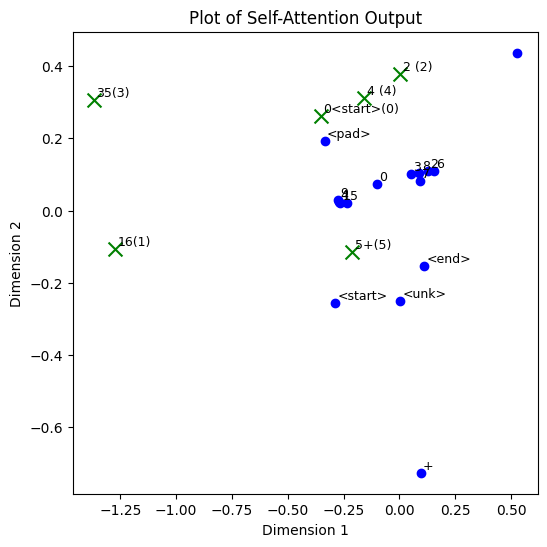

[[[-1.875617    0.6965225  -0.18726939  0.7638674 ]]

 [[-1.8506045  -0.73789775  1.1430268   1.2389407 ]]

 [[ 1.9715765  -0.07088515 -0.8039118  -0.95677733]]

 [[-1.5974394  -0.87092614  0.73711157  1.7423433 ]]

 [[ 0.1876303   0.6726857  -1.3077095   0.27837634]]

 [[-0.9365148  -1.2819221   0.7490296   1.7316041 ]]]
(6, 1, 4)
[[-1.875617    0.6965225 ]
 [-1.8506045  -0.73789775]
 [ 1.9715765  -0.07088515]
 [-1.5974394  -0.87092614]
 [ 0.1876303   0.6726857 ]
 [-0.9365148  -1.2819221 ]]


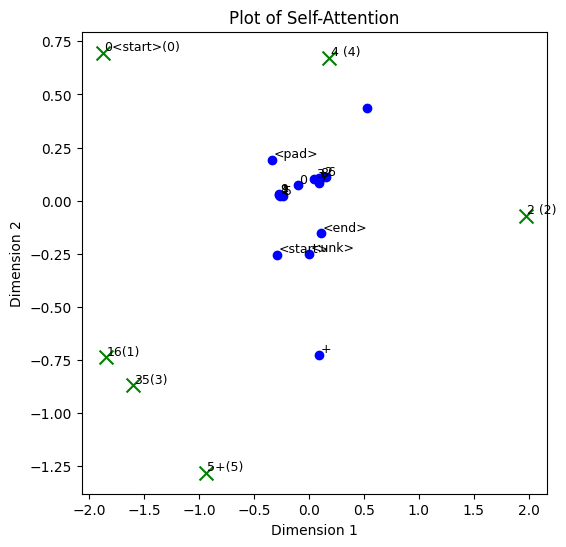

QV.shape: torch.Size([1, 6, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 6, 15])
AV.shape: torch.Size([1, 6, 4])
[[[-0.8960632  -3.200758    3.6878498   0.925975  ]
  [ 0.47592056 -3.75935     4.1297293   2.5186937 ]
  [ 0.4239226   3.8791175  -3.9653578  -1.7266359 ]
  [ 1.2060615  -2.8945744   3.7742577   2.479591  ]
  [-0.0119881   1.1796887  -0.43409127 -0.8922088 ]
  [ 1.881244   -1.6564139   2.594138    2.3520176 ]]]
(1, 6, 4)
[[-0.8960632  -3.200758  ]
 [ 0.47592056 -3.75935   ]
 [ 0.4239226   3.8791175 ]
 [ 1.2060615  -2.8945744 ]
 [-0.0119881   1.1796887 ]
 [ 1.881244   -1.6564139 ]]


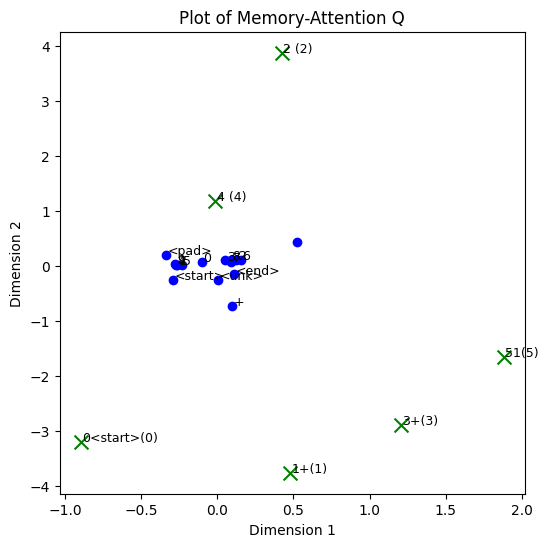

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

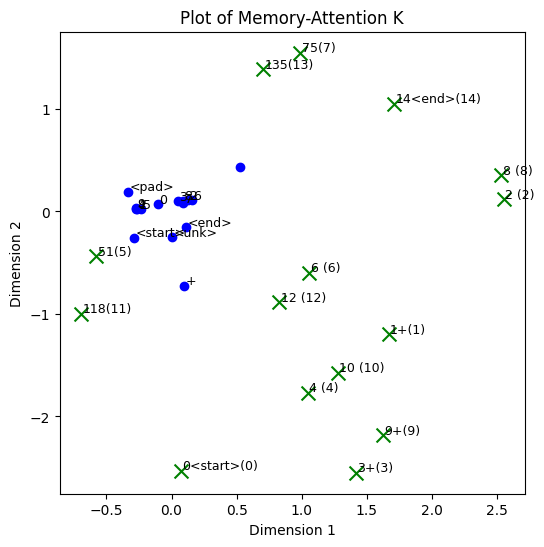

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

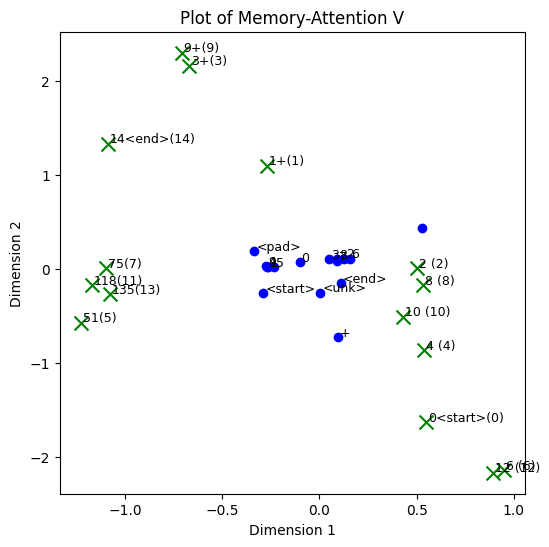

[[-0.5671896   1.7940098   2.0370672   0.63815767]
 [-0.6692586   2.1543097   2.3449337   0.67661494]
 [-0.807204   -0.00796267  1.233026    0.21293016]
 [-0.67174387  2.1642163   2.3638225   0.6749347 ]
 [-0.6012289  -0.16962473  1.007579    0.18832429]
 [-0.6597499   2.1368518   2.3700159   0.66945904]]
(6, 4)
[[-0.5671896   1.7940098 ]
 [-0.6692586   2.1543097 ]
 [-0.807204   -0.00796267]
 [-0.67174387  2.1642163 ]
 [-0.6012289  -0.16962473]
 [-0.6597499   2.1368518 ]]


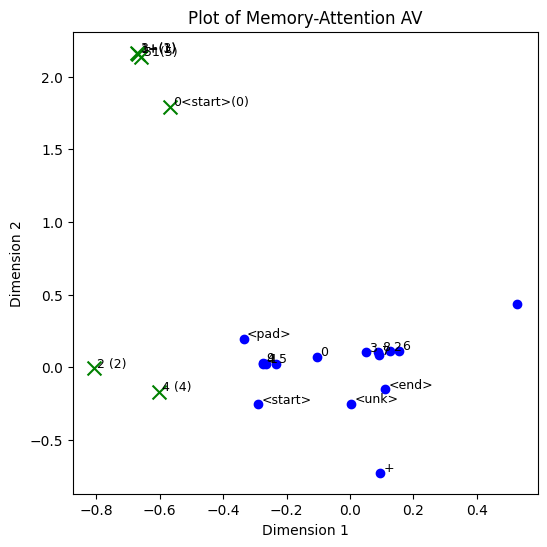

[[[-0.35179946  0.2619231   0.68771607  0.00308626]]

 [[-1.2734178  -0.10774735  1.20488     1.1380138 ]]

 [[ 0.00398008  0.37772563  0.79345304 -0.52461493]]

 [[-1.3676895   0.30645874  1.2568622   1.0303571 ]]

 [[-0.15678217  0.31122896  0.6656491  -0.25322336]]

 [[-0.21084414 -0.11452886  0.1784857   0.18664815]]]
(6, 1, 4)
[[-0.35179946  0.2619231 ]
 [-1.2734178  -0.10774735]
 [ 0.00398008  0.37772563]
 [-1.3676895   0.30645874]
 [-0.15678217  0.31122896]
 [-0.21084414 -0.11452886]]


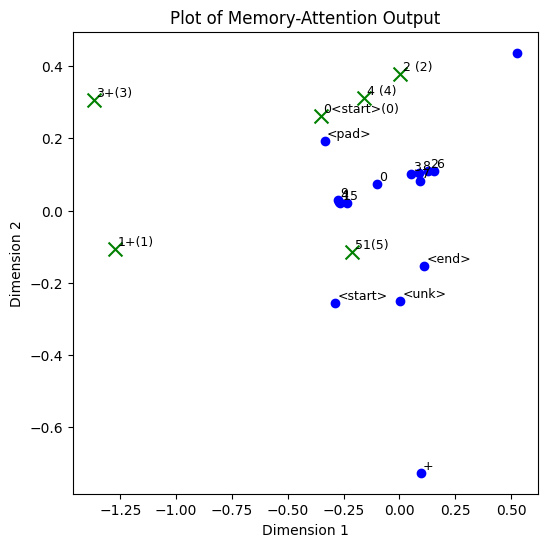

[[[-1.6170892   0.48891783  0.2924281   0.6880895 ]]

 [[-1.6778058   0.1790079   0.55818206  0.76401544]]

 [[-0.0278463   0.4150513   1.0447949  -1.2339072 ]]

 [[-1.6539204   0.1435698   0.4587267   0.85273176]]

 [[-1.4797949   0.86698085  0.11244185  0.42300564]]

 [[-1.6465092   0.06631659  0.46844432  0.89867747]]]
(6, 1, 4)
[[-1.6170892   0.48891783]
 [-1.6778058   0.1790079 ]
 [-0.0278463   0.4150513 ]
 [-1.6539204   0.1435698 ]
 [-1.4797949   0.86698085]
 [-1.6465092   0.06631659]]


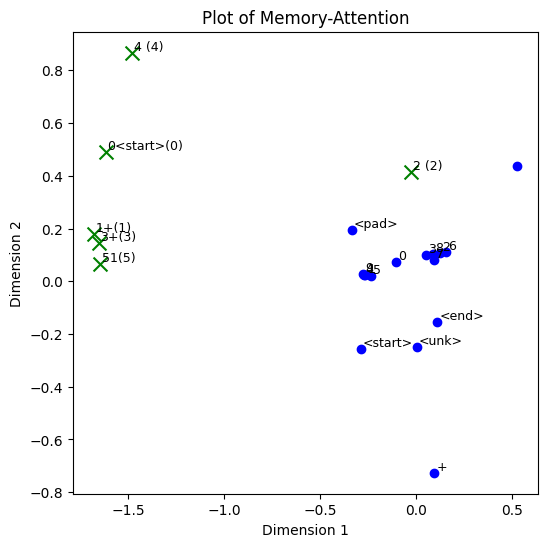

AfterLinear.shape: torch.Size([6, 1, 4])
AfterAddTGT.shape: torch.Size([6, 1, 4])
AfterAddTGT: tensor([[[-0.4184,  3.9675, -4.8933,  1.8008]],

        [[-2.7141,  3.0794, -3.7775,  3.3449]],

        [[ 0.6848,  4.2309,  0.5422, -4.4685]],

        [[-2.6165,  2.8864, -3.8237,  3.4678]],

        [[ 1.0060,  4.2034, -4.9994,  0.5459]],

        [[-3.0858,  2.4341, -3.3932,  3.8142]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  1.5315, -15.8508, -15.9946,  -9.0979, -14.8490, -10.0391, -13.9263,  -6.1283, -14.4217,
          -9.8856,  -0.8732,  -2.0473,  -1.9310,   2.1783,   1.3147,  13.4671]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 6
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15],
        [14],
        [15]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.3461]],

        [[ 1.1515,  0.7600,  0.7813,  0.8718]],

       

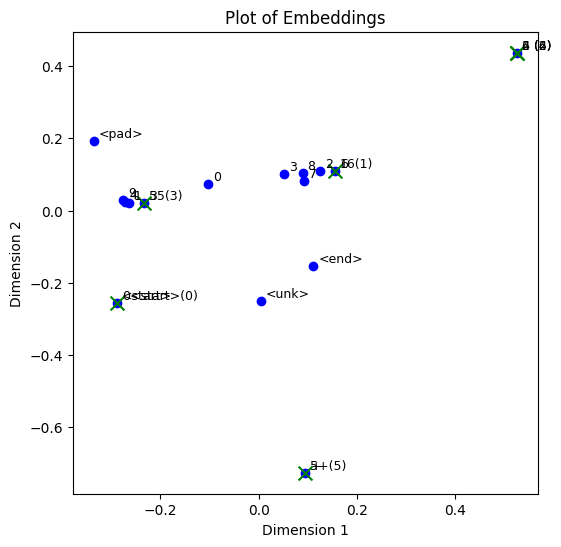

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]

 [[ 0.29346734  0.22062886 -1.1892636   0.41529012]]

 [[-0.768994   -1.168677   -0.41812384  0.06390113]]

 [[ 0.77085435  1.8344427  -1.1692889   0.41429055]]]
(7, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]
 [ 0.29346734  0.22062886]
 [-0.768994   -1.168677  ]
 [ 0.77085435  1.8344427 ]]


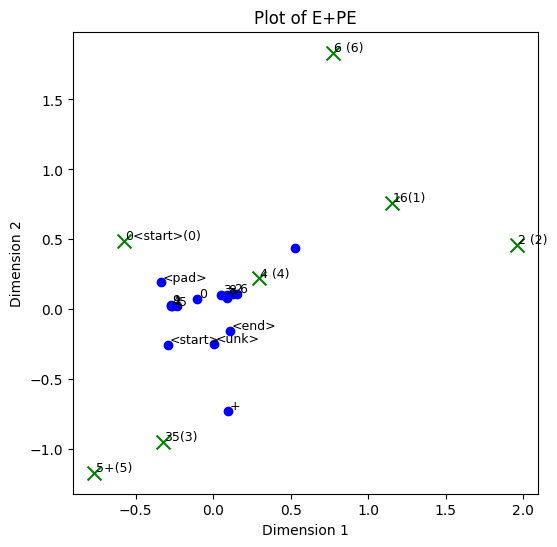

SelfAttention Layer
QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 7, 4])
WV.shape: torch.Size([1, 7, 4])
attn_weight.shape: torch.Size([1, 7, 7])
AV.shape: torch.Size([1, 7, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]
  [ 0.965866    0.07053957  1.4842246  -0.3846688 ]
  [-0.83484656  1.4373012   0.5792201  -0.5744088 ]
  [ 2.4699285  -1.335511    1.4578295   0.2476317 ]]]
(1, 7, 4)
[[ 0.7114342   0.2834468 ]
 [ 0.505927   -2.0341296 ]
 [ 1.9474189  -0.9667186 ]
 [-2.532358   -1.0347031 ]
 [ 0.965866    0.07053957]
 [-0.83484656  1.4373012 ]
 [ 2.4699285  -1.335511  ]]


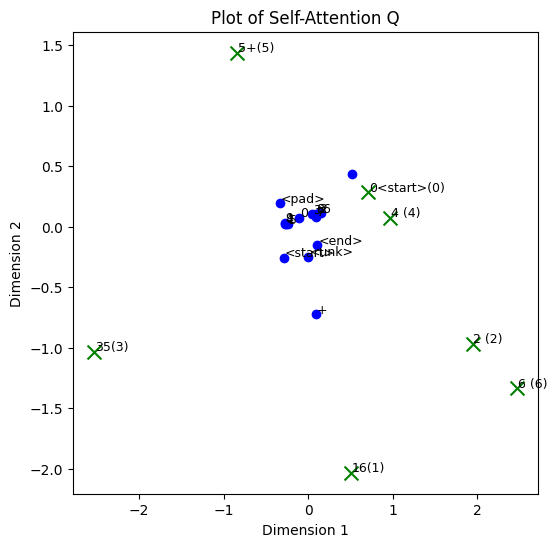

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]
  [ 0.33235416  0.45209563  0.41340655 -0.4876575 ]
  [ 0.3828183   1.4692954  -0.64528066 -1.9975775 ]
  [ 0.95665556 -1.2246394   1.414116    1.4234873 ]]]
(1, 7, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]
 [ 0.33235416  0.45209563]
 [ 0.3828183   1.4692954 ]
 [ 0.95665556 -1.2246394 ]]


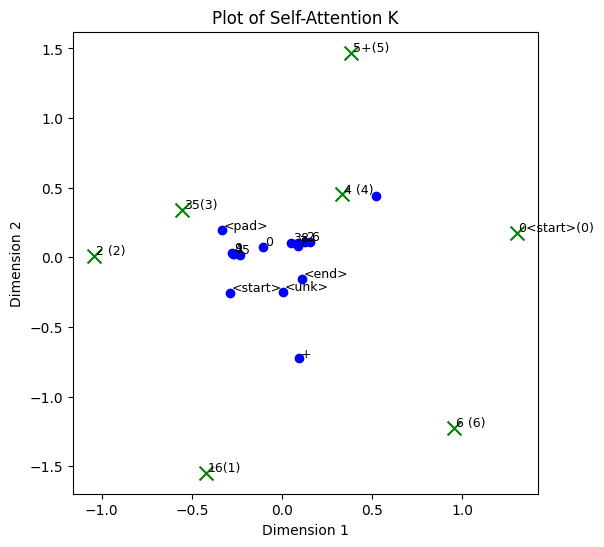

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]
  [-0.22209424  0.71188325 -0.25376043 -0.5252558 ]
  [ 0.5861341   0.13321787  0.69309384  0.43203232]
  [-1.1467686   0.8873743  -0.9800878  -0.97567254]]]
(1, 7, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]
 [-0.22209424  0.71188325]
 [ 0.5861341   0.13321787]
 [-1.1467686   0.8873743 ]]


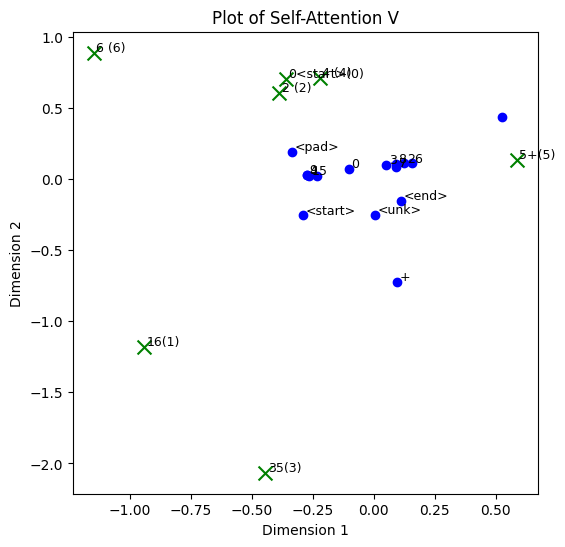

[[[-0.499331    0.38880306 -0.46910554 -0.57408464]
  [-0.94921356  0.02160272 -0.97922075 -0.9064059 ]
  [-0.7336142   0.7225503  -0.5518767  -0.6112901 ]
  [-0.7440532  -0.37376612 -1.0501478  -1.0427859 ]
  [-0.5065482   0.537766   -0.40986016 -0.5186414 ]
  [-0.01988965  0.0510804  -0.07949059 -0.2711085 ]
  [-0.9408486   0.6962713  -0.78995323 -0.80199707]]]
(1, 7, 4)
[[-0.499331    0.38880306]
 [-0.94921356  0.02160272]
 [-0.7336142   0.7225503 ]
 [-0.7440532  -0.37376612]
 [-0.5065482   0.537766  ]
 [-0.01988965  0.0510804 ]
 [-0.9408486   0.6962713 ]]


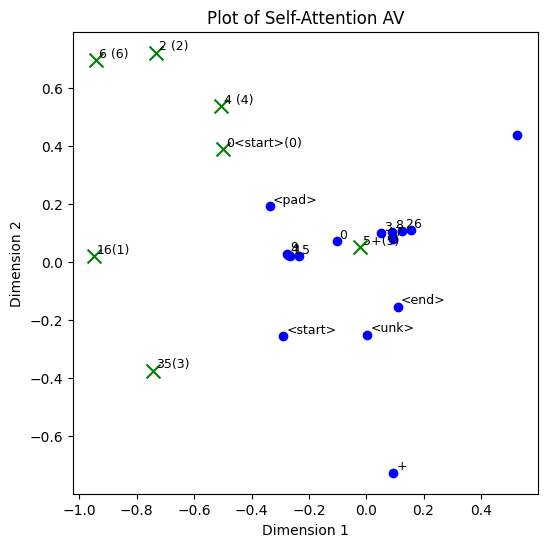

[[[-0.45082974  0.593722    1.1190559  -0.18274592]]

 [[-1.0157285   0.6540289   1.7262216   0.27522448]]

 [[-0.36902183  0.9584398   1.5713048  -0.6130918 ]]

 [[-1.3137215   0.40779778  1.3456607   0.8852178 ]]

 [[-0.3283037   0.67385805  1.1630697  -0.38731155]]

 [[-0.22632949 -0.06553039  0.24278131  0.16002662]]

 [[-0.60443354  1.147958    1.909689   -0.53109246]]]
(7, 1, 4)
[[-0.45082974  0.593722  ]
 [-1.0157285   0.6540289 ]
 [-0.36902183  0.9584398 ]
 [-1.3137215   0.40779778]
 [-0.3283037   0.67385805]
 [-0.22632949 -0.06553039]
 [-0.60443354  1.147958  ]]


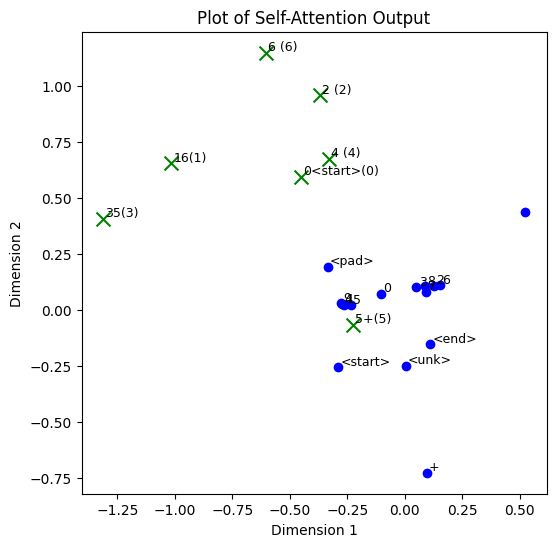

[[[-1.9939773   0.7830496   0.27823064  0.12317916]]

 [[-1.8520163  -0.19690137  1.6185024  -0.24818043]]

 [[ 1.407533    0.38289306 -0.3383272  -1.7435796 ]]

 [[-1.6325145  -0.85952574  0.78520185  1.6945616 ]]

 [[-0.8658673   1.1078986  -0.37007105 -0.6293515 ]]

 [[-1.0281101  -1.2571459   0.8350972   1.667302  ]]

 [[-0.86746085  1.0642393   0.06609173 -1.1390151 ]]]
(7, 1, 4)
[[-1.9939773   0.7830496 ]
 [-1.8520163  -0.19690137]
 [ 1.407533    0.38289306]
 [-1.6325145  -0.85952574]
 [-0.8658673   1.1078986 ]
 [-1.0281101  -1.2571459 ]
 [-0.86746085  1.0642393 ]]


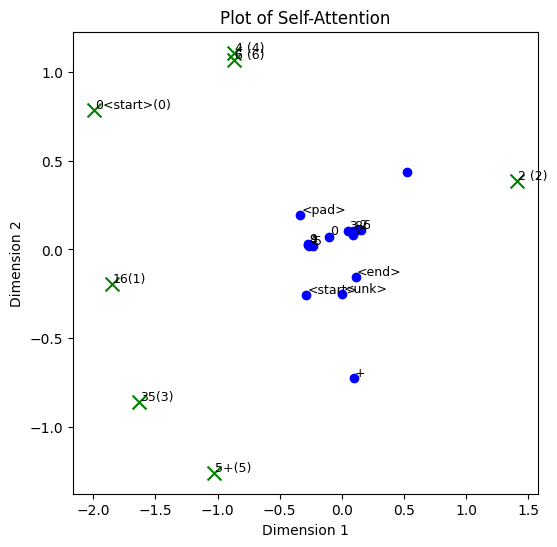

QV.shape: torch.Size([1, 7, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 7, 15])
AV.shape: torch.Size([1, 7, 4])
[[[-1.6415017  -3.8874173   3.7648742   0.8881776 ]
  [-1.290964   -4.494206    3.681254    1.816511  ]
  [-0.9804573   2.3051987  -3.1484985  -1.7887502 ]
  [ 1.1303823  -3.002935    3.8299077   2.49434   ]
  [-1.8373663  -1.6237131   1.319207   -0.5133689 ]
  [ 1.7447586  -1.8981786   2.7531404   2.4004035 ]
  [-2.299888   -2.032444    1.2306027  -0.50067407]]]
(1, 7, 4)
[[-1.6415017 -3.8874173]
 [-1.290964  -4.494206 ]
 [-0.9804573  2.3051987]
 [ 1.1303823 -3.002935 ]
 [-1.8373663 -1.6237131]
 [ 1.7447586 -1.8981786]
 [-2.299888  -2.032444 ]]


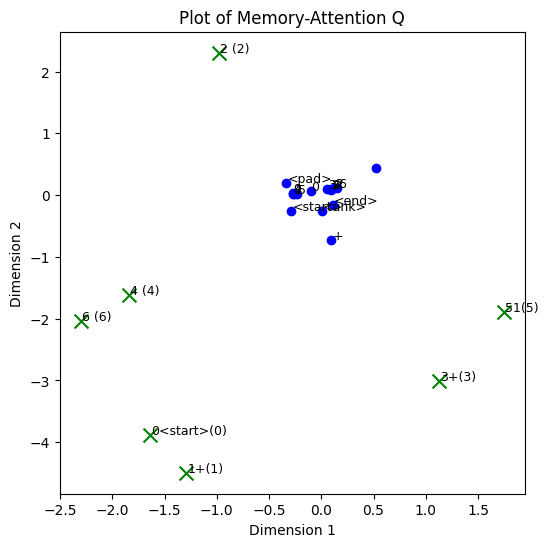

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

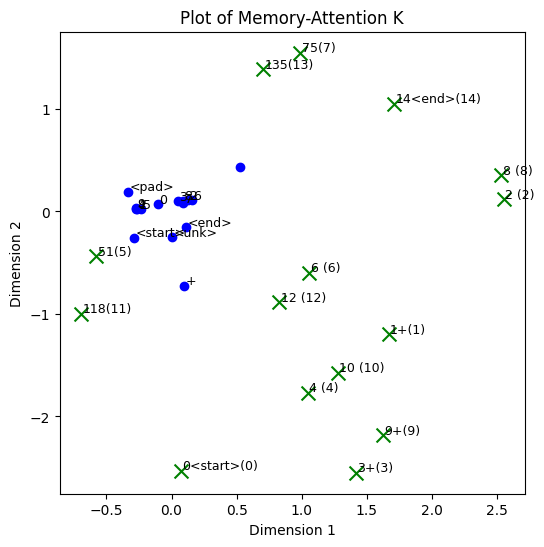

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

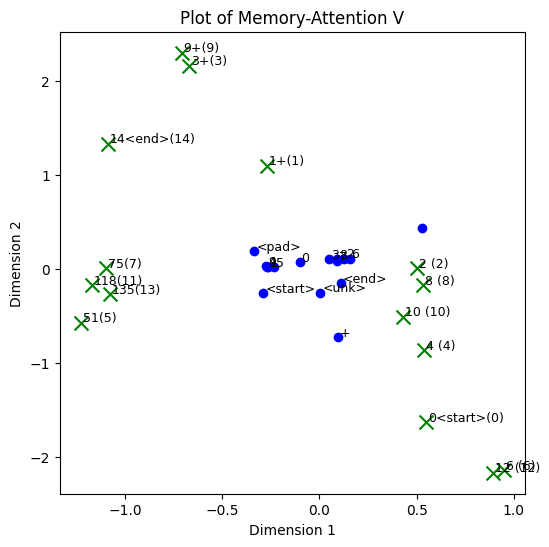

[[-0.5070957   1.5943582   1.8560967   0.6218078 ]
 [-0.60635     1.9533712   2.167662    0.66366845]
 [-0.81976926 -0.16559757  0.9969005   0.16204105]
 [-0.67176557  2.1639404   2.3620882   0.6752238 ]
 [-0.42088354 -0.3590704  -0.09111913 -0.03664244]
 [-0.66343415  2.1455536   2.370203    0.67067015]
 [-0.36529288 -0.49267936 -0.22832528 -0.0549213 ]]
(7, 4)
[[-0.5070957   1.5943582 ]
 [-0.60635     1.9533712 ]
 [-0.81976926 -0.16559757]
 [-0.67176557  2.1639404 ]
 [-0.42088354 -0.3590704 ]
 [-0.66343415  2.1455536 ]
 [-0.36529288 -0.49267936]]


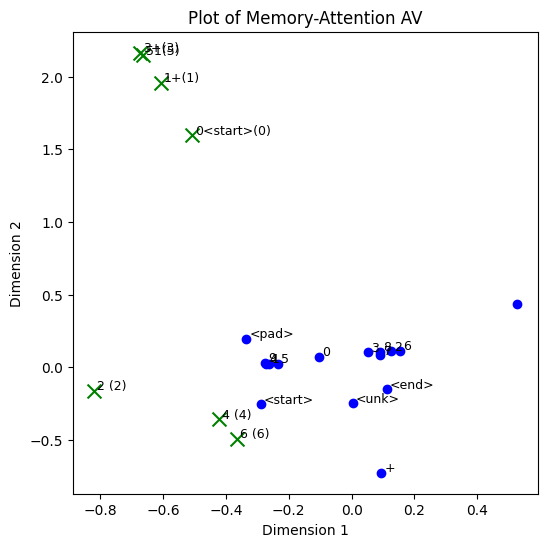

[[[-0.45082974  0.593722    1.1190559  -0.18274592]]

 [[-1.0157285   0.6540289   1.7262216   0.27522448]]

 [[-0.36902183  0.9584398   1.5713048  -0.6130918 ]]

 [[-1.3137215   0.40779778  1.3456607   0.8852178 ]]

 [[-0.3283037   0.67385805  1.1630697  -0.38731155]]

 [[-0.22632949 -0.06553039  0.24278131  0.16002662]]

 [[-0.60443354  1.147958    1.909689   -0.53109246]]]
(7, 1, 4)
[[-0.45082974  0.593722  ]
 [-1.0157285   0.6540289 ]
 [-0.36902183  0.9584398 ]
 [-1.3137215   0.40779778]
 [-0.3283037   0.67385805]
 [-0.22632949 -0.06553039]
 [-0.60443354  1.147958  ]]


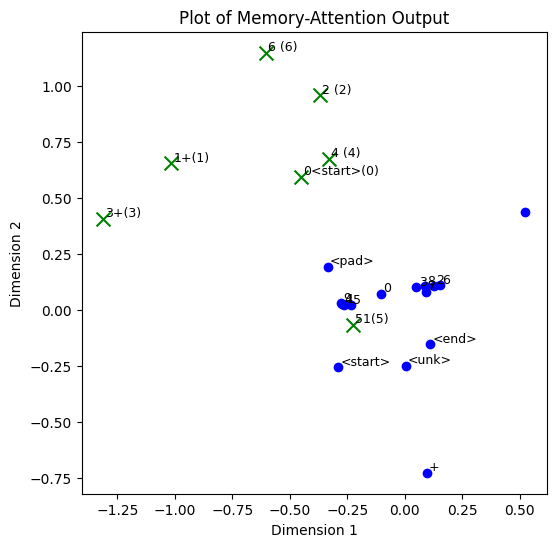

[[[-1.6419063   0.5196867   0.43268946  0.5703548 ]]

 [[-1.6900265   0.3263151   0.7310998   0.51778585]]

 [[ 0.02740588  0.24823326  1.1588063  -1.2446275 ]]

 [[-1.6569947   0.14642051  0.47021762  0.84372175]]

 [[-0.30611187  0.66543996  0.9638332  -1.12426   ]]

 [[-1.6526717   0.07337767  0.48893216  0.8816536 ]]

 [[ 0.12198249  0.12387265  1.1958688  -1.2590938 ]]]
(7, 1, 4)
[[-1.6419063   0.5196867 ]
 [-1.6900265   0.3263151 ]
 [ 0.02740588  0.24823326]
 [-1.6569947   0.14642051]
 [-0.30611187  0.66543996]
 [-1.6526717   0.07337767]
 [ 0.12198249  0.12387265]]


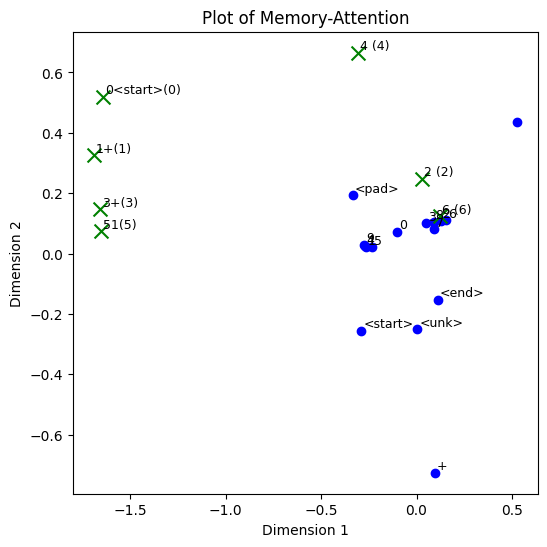

AfterLinear.shape: torch.Size([7, 1, 4])
AfterAddTGT.shape: torch.Size([7, 1, 4])
AfterAddTGT: tensor([[[-0.5525,  4.1365, -4.8146,  1.6966]],

        [[-2.3345,  3.8428, -4.0404,  2.6572]],

        [[-0.7071,  2.3920,  3.1575, -4.3016]],

        [[-2.6350,  2.9017, -3.8128,  3.4600]],

        [[ 1.5007,  5.1524, -2.5739, -2.9369]],

        [[-3.1099,  2.4724, -3.3825,  3.7922]],

        [[ 4.8622, -4.0821, -2.2642,  1.6176]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  9.2844,  -0.7596,   4.6410,  10.0762,   5.6654,  -8.8595,  -1.9023, -11.0072,   8.5042,
           9.4423,  -0.4910,  -1.7481,  -2.1447,  -3.6019,  -4.2623,  -2.6675]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 3

------------------

iter: 7
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15],
        [14],
        [15],
        [ 3]], device='cuda:0')
tgt_embed: tensor([[[-0.5774,  0.4881, -0.9953,  0.346

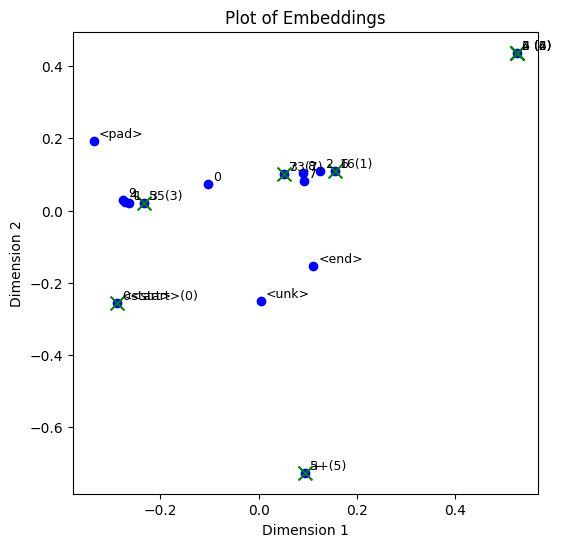

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]

 [[ 0.29346734  0.22062886 -1.1892636   0.41529012]]

 [[-0.768994   -1.168677   -0.41812384  0.06390113]]

 [[ 0.77085435  1.8344427  -1.1692889   0.41429055]]

 [[ 0.7590668   0.956551    1.3100457   0.77085614]]]
(8, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]
 [ 0.29346734  0.22062886]
 [-0.768994   -1.168677  ]
 [ 0.77085435  1.8344427 ]
 [ 0.7590668   0.956551  ]]


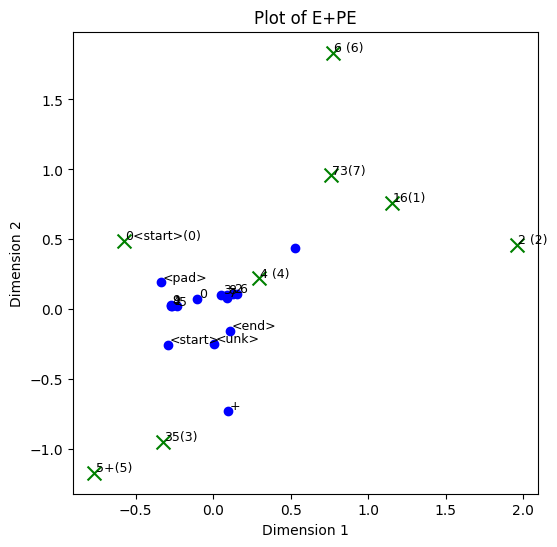

SelfAttention Layer
QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 8, 4])
WV.shape: torch.Size([1, 8, 4])
attn_weight.shape: torch.Size([1, 8, 8])
AV.shape: torch.Size([1, 8, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]
  [ 0.965866    0.07053957  1.4842246  -0.3846688 ]
  [-0.83484656  1.4373012   0.5792201  -0.5744088 ]
  [ 2.4699285  -1.335511    1.4578295   0.2476317 ]
  [ 0.26438832 -2.173289    0.09268427  1.0571992 ]]]
(1, 8, 4)
[[ 0.7114342   0.2834468 ]
 [ 0.505927   -2.0341296 ]
 [ 1.9474189  -0.9667186 ]
 [-2.532358   -1.0347031 ]
 [ 0.965866    0.07053957]
 [-0.83484656  1.4373012 ]
 [ 2.4699285  -1.335511  ]
 [ 0.26438832 -2.173289  ]]


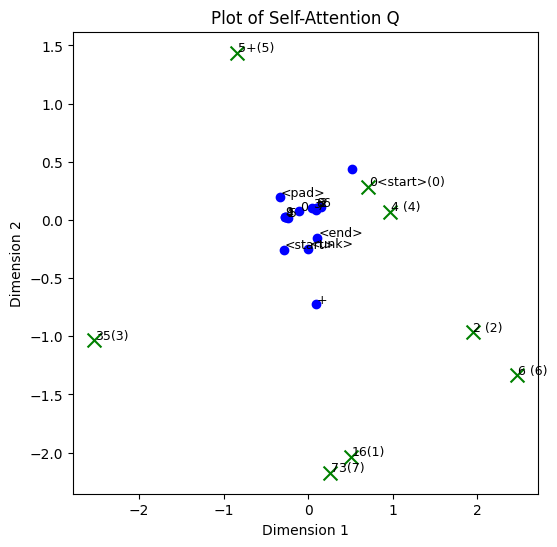

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]
  [ 0.33235416  0.45209563  0.41340655 -0.4876575 ]
  [ 0.3828183   1.4692954  -0.64528066 -1.9975775 ]
  [ 0.95665556 -1.2246394   1.414116    1.4234873 ]
  [ 0.03392431 -2.040095   -0.02586579  2.6158478 ]]]
(1, 8, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]
 [ 0.33235416  0.45209563]
 [ 0.3828183   1.4692954 ]
 [ 0.95665556 -1.2246394 ]
 [ 0.03392431 -2.040095  ]]


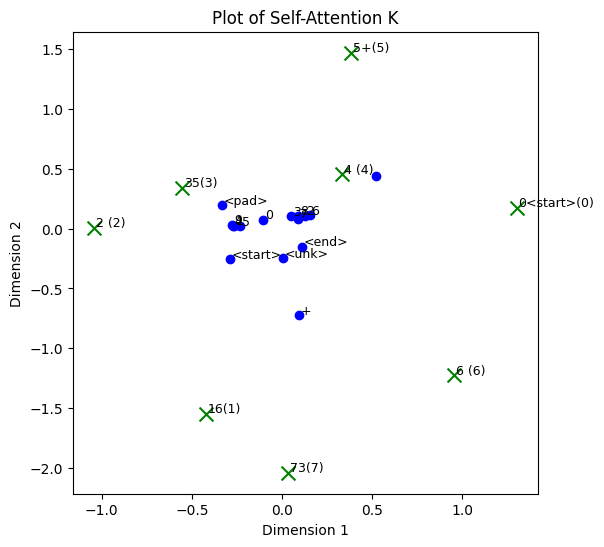

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]
  [-0.22209424  0.71188325 -0.25376043 -0.5252558 ]
  [ 0.5861341   0.13321787  0.69309384  0.43203232]
  [-1.1467686   0.8873743  -0.9800878  -0.97567254]
  [-1.0836861  -1.5115368  -1.0895604  -0.61330616]]]
(1, 8, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]
 [-0.22209424  0.71188325]
 [ 0.5861341   0.13321787]
 [-1.1467686   0.8873743 ]
 [-1.0836861  -1.5115368 ]]


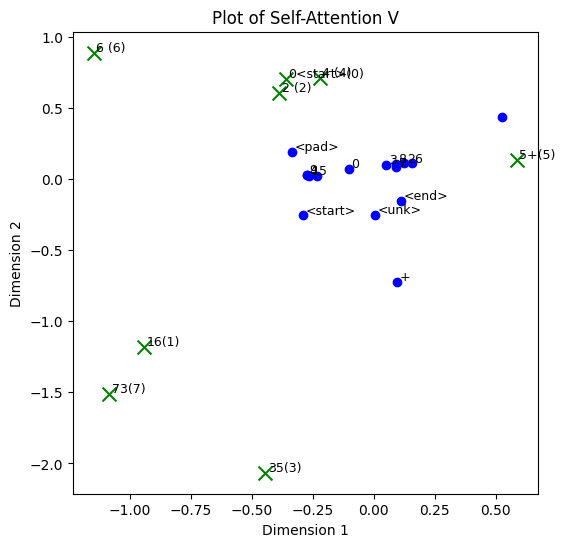

[[[-0.54959434  0.22534534 -0.52247393 -0.57745826]
  [-1.0080191  -0.6488463  -1.0274729  -0.7782321 ]
  [-0.7462095   0.6421697  -0.5712221  -0.6113627 ]
  [-0.8506114  -0.73073626 -1.0625134  -0.90803874]
  [-0.53470016  0.43780383 -0.44301495 -0.523259  ]
  [-0.03200909  0.03327809 -0.09099792 -0.27500704]
  [-0.9603477   0.39487678 -0.83085346 -0.7762383 ]
  [-1.0197946  -0.9897589  -1.0690054  -0.74982107]]]
(1, 8, 4)
[[-0.54959434  0.22534534]
 [-1.0080191  -0.6488463 ]
 [-0.7462095   0.6421697 ]
 [-0.8506114  -0.73073626]
 [-0.53470016  0.43780383]
 [-0.03200909  0.03327809]
 [-0.9603477   0.39487678]
 [-1.0197946  -0.9897589 ]]


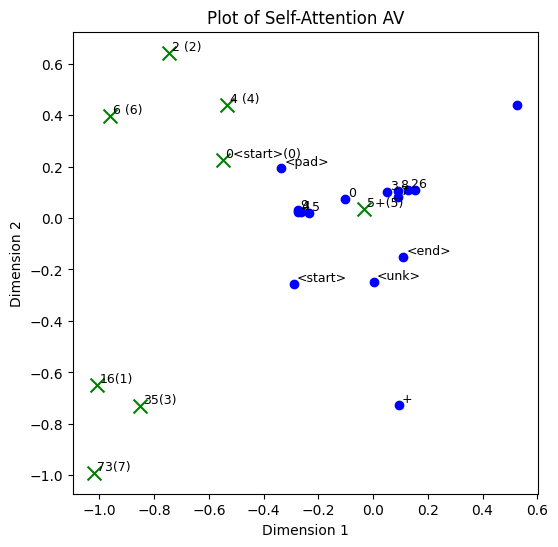

[[[-0.5336987   0.4604654   1.1361632  -0.0221316 ]]

 [[-1.1900059  -0.04982644  1.5476799   0.8915237 ]]

 [[-0.40662846  0.88957787  1.5621889  -0.530425  ]]

 [[-1.3452634  -0.01993099  1.3369646   1.1360008 ]]

 [[-0.38127485  0.59438     1.170624   -0.28624958]]

 [[-0.23986307 -0.07566951  0.25503027  0.17739479]]

 [[-0.71498466  0.8608084   1.8289082  -0.2286302 ]]

 [[-1.3142943  -0.3756455   1.4419985   1.2382116 ]]]
(8, 1, 4)
[[-0.5336987   0.4604654 ]
 [-1.1900059  -0.04982644]
 [-0.40662846  0.88957787]
 [-1.3452634  -0.01993099]
 [-0.38127485  0.59438   ]
 [-0.23986307 -0.07566951]
 [-0.71498466  0.8608084 ]
 [-1.3142943  -0.3756455 ]]


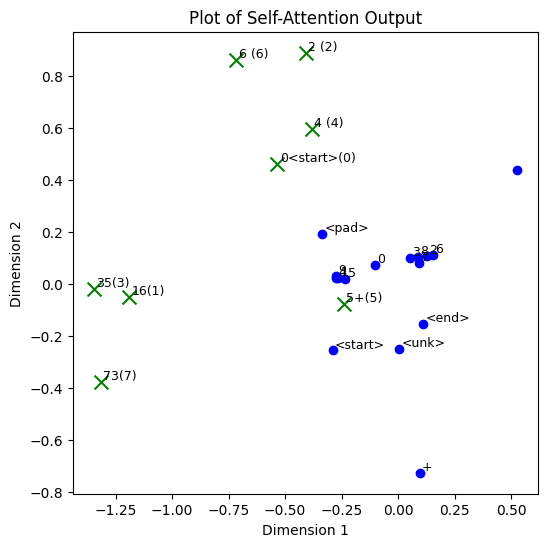

[[[-2.1258175   0.6488015   0.31302923  0.41796002]]

 [[-1.7987692  -0.735183    1.4349998   0.7955955 ]]

 [[ 1.4557238   0.36145812 -0.3810732  -1.6998347 ]]

 [[-1.4942532  -0.95522773  0.76223034  1.7415789 ]]

 [[-1.1211946   1.0762863  -0.39100888 -0.30226243]]

 [[-1.0392662  -1.2523347   0.83928543  1.6650074 ]]

 [[-1.0751256   1.0784591   0.00853578 -0.8822406 ]]

 [[-1.8398792  -0.70072323  1.4125456   0.81107837]]]
(8, 1, 4)
[[-2.1258175   0.6488015 ]
 [-1.7987692  -0.735183  ]
 [ 1.4557238   0.36145812]
 [-1.4942532  -0.95522773]
 [-1.1211946   1.0762863 ]
 [-1.0392662  -1.2523347 ]
 [-1.0751256   1.0784591 ]
 [-1.8398792  -0.70072323]]


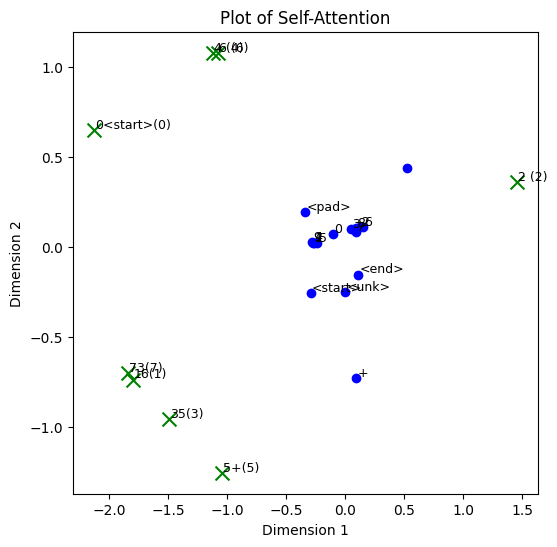

QV.shape: torch.Size([1, 8, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 8, 15])
AV.shape: torch.Size([1, 8, 4])
[[[-1.3597916  -4.0643935   4.119234    1.1729885 ]
  [ 0.08248008 -3.964843    3.9375293   2.4382308 ]
  [-0.89386857  2.4340458  -3.2278292  -1.8042374 ]
  [ 1.3249836  -2.7141607   3.5957298   2.4819233 ]
  [-1.6689588  -1.992281    1.893126   -0.23100922]
  [ 1.7323211  -1.9223354   2.7731407   2.4047205 ]
  [-2.1968527  -2.3121305   1.6845331  -0.31568488]
  [ 0.04911227 -4.0249453   4.0115047   2.4374354 ]]]
(1, 8, 4)
[[-1.3597916  -4.0643935 ]
 [ 0.08248008 -3.964843  ]
 [-0.89386857  2.4340458 ]
 [ 1.3249836  -2.7141607 ]
 [-1.6689588  -1.992281  ]
 [ 1.7323211  -1.9223354 ]
 [-2.1968527  -2.3121305 ]
 [ 0.04911227 -4.0249453 ]]


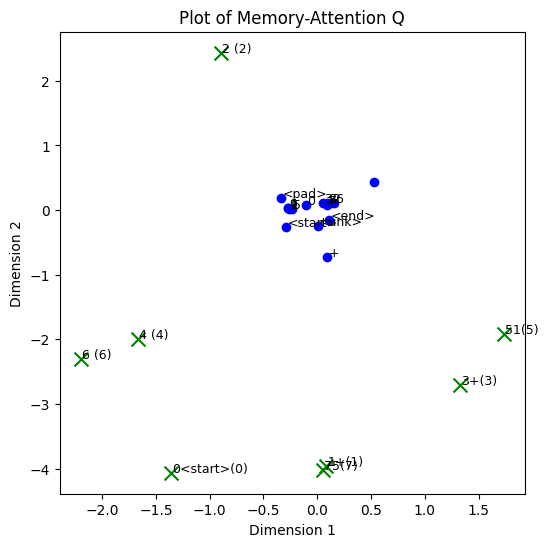

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

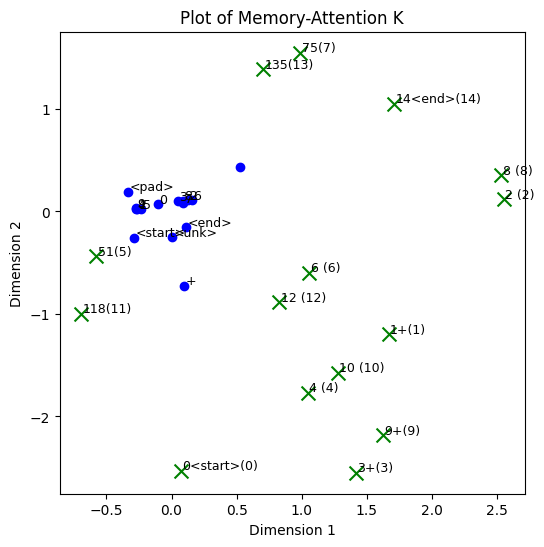

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

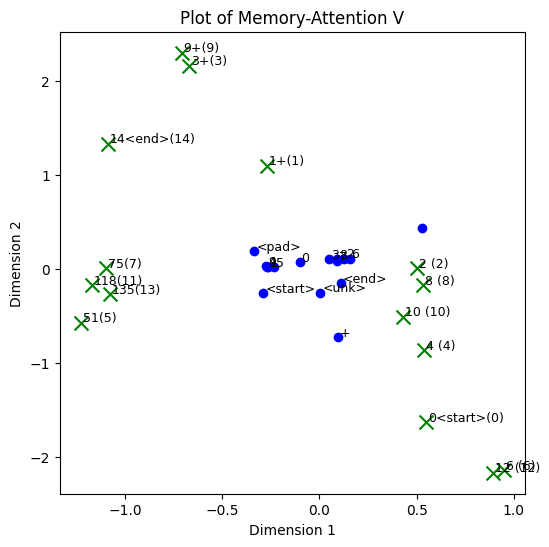

[[-0.57609636  1.8430971   2.0721393   0.6504702 ]
 [-0.66356254  2.136384    2.3283722   0.6758728 ]
 [-0.8302101  -0.14803752  1.0151924   0.16352162]
 [-0.67132264  2.1637163   2.3665009   0.67433023]
 [-0.3487684   0.02817226  0.34553716  0.1749665 ]
 [-0.6637941   2.1464124   2.3702385   0.6707924 ]
 [-0.2999968  -0.29364097  0.01569209  0.08605651]
 [-0.66375566  2.1368084   2.3279288   0.6760614 ]]
(8, 4)
[[-0.57609636  1.8430971 ]
 [-0.66356254  2.136384  ]
 [-0.8302101  -0.14803752]
 [-0.67132264  2.1637163 ]
 [-0.3487684   0.02817226]
 [-0.6637941   2.1464124 ]
 [-0.2999968  -0.29364097]
 [-0.66375566  2.1368084 ]]


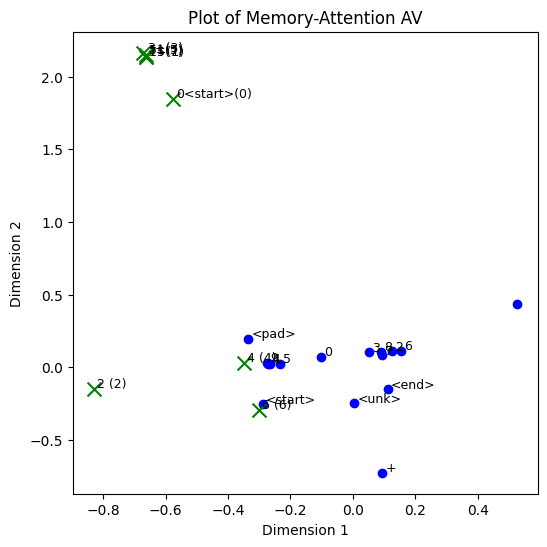

[[[-0.5336987   0.4604654   1.1361632  -0.0221316 ]]

 [[-1.1900059  -0.04982644  1.5476799   0.8915237 ]]

 [[-0.40662846  0.88957787  1.5621889  -0.530425  ]]

 [[-1.3452634  -0.01993099  1.3369646   1.1360008 ]]

 [[-0.38127485  0.59438     1.170624   -0.28624958]]

 [[-0.23986307 -0.07566951  0.25503027  0.17739479]]

 [[-0.71498466  0.8608084   1.8289082  -0.2286302 ]]

 [[-1.3142943  -0.3756455   1.4419985   1.2382116 ]]]
(8, 1, 4)
[[-0.5336987   0.4604654 ]
 [-1.1900059  -0.04982644]
 [-0.40662846  0.88957787]
 [-1.3452634  -0.01993099]
 [-0.38127485  0.59438   ]
 [-0.23986307 -0.07566951]
 [-0.71498466  0.8608084 ]
 [-1.3142943  -0.3756455 ]]


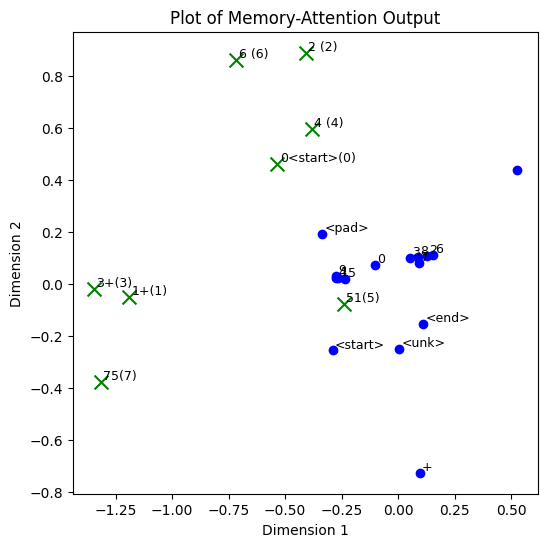

[[[-1.6449203   0.47698584  0.41477183  0.620944  ]]

 [[-1.6900028   0.19378534  0.63726807  0.6980967 ]]

 [[ 0.02263853  0.26969185  1.1434247  -1.2446681 ]]

 [[-1.6537687   0.12829444  0.4649473   0.859418  ]]

 [[-1.4310492   0.92318624  0.58211505 -0.04775805]]

 [[-1.6530253   0.07441578  0.489788    0.88044524]]

 [[-0.6915823   0.61519057  1.1788721  -0.93086034]]

 [[-1.689363    0.19935507  0.6307536   0.6985446 ]]]
(8, 1, 4)
[[-1.6449203   0.47698584]
 [-1.6900028   0.19378534]
 [ 0.02263853  0.26969185]
 [-1.6537687   0.12829444]
 [-1.4310492   0.92318624]
 [-1.6530253   0.07441578]
 [-0.6915823   0.61519057]
 [-1.689363    0.19935507]]


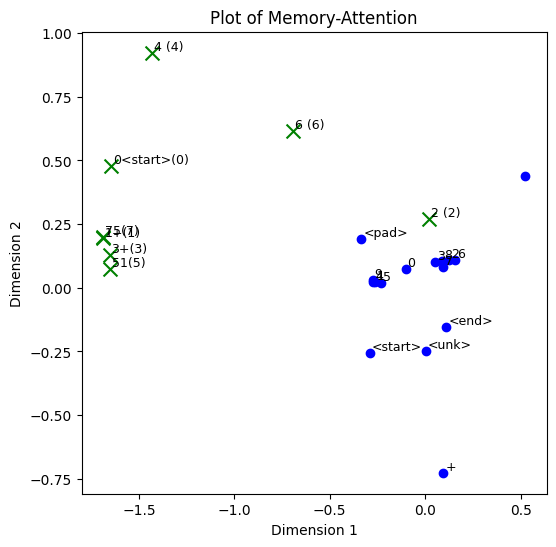

AfterLinear.shape: torch.Size([8, 1, 4])
AfterAddTGT.shape: torch.Size([8, 1, 4])
AfterAddTGT: tensor([[[-0.7089,  4.0421, -4.7873,  1.8759]],

        [[-2.8747,  3.1650, -3.6695,  3.3032]],

        [[-0.7078,  2.5672,  3.0284, -4.3226]],

        [[-2.7240,  2.8023, -3.7359,  3.5413]],

        [[ 0.8109,  4.6407, -4.7443,  0.1038]],

        [[-3.1068,  2.4787, -3.3864,  3.7882]],

        [[-0.3174,  5.9288, -2.6336, -2.0358]],

        [[-2.8197,  3.1948, -3.7121,  3.2742]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  0.5367, -14.0786, -17.5297, -11.1065, -13.5013,  -8.1395, -14.9944,  -6.1127, -16.2371,
          -9.0200,  -1.1524,  -2.2058,  -1.9660,  -0.0407,   3.8263,  13.0776]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 8
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15],
        [14],
        [15],
        [ 3],
        [15]], device=

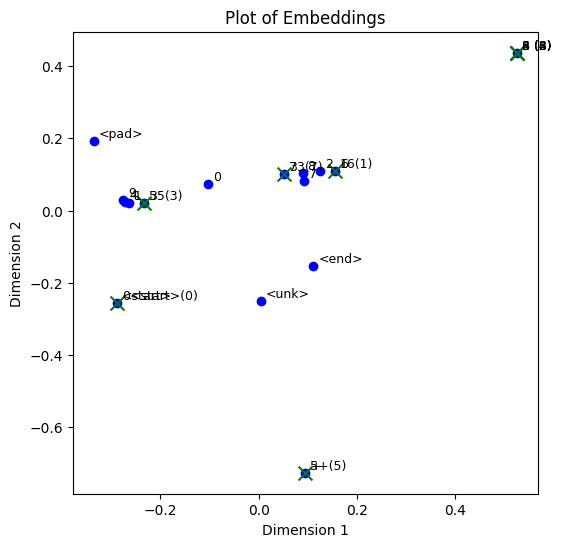

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]

 [[ 0.29346734  0.22062886 -1.1892636   0.41529012]]

 [[-0.768994   -1.168677   -0.41812384  0.06390113]]

 [[ 0.77085435  1.8344427  -1.1692889   0.41429055]]

 [[ 0.7590668   0.956551    1.3100457   0.77085614]]

 [[ 2.039628    0.7287724  -1.1493382   0.4128917 ]]]
(9, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]
 [ 0.29346734  0.22062886]
 [-0.768994   -1.168677  ]
 [ 0.77085435  1.8344427 ]
 [ 0.7590668   0.956551  ]
 [ 2.039628    0.7287724 ]]


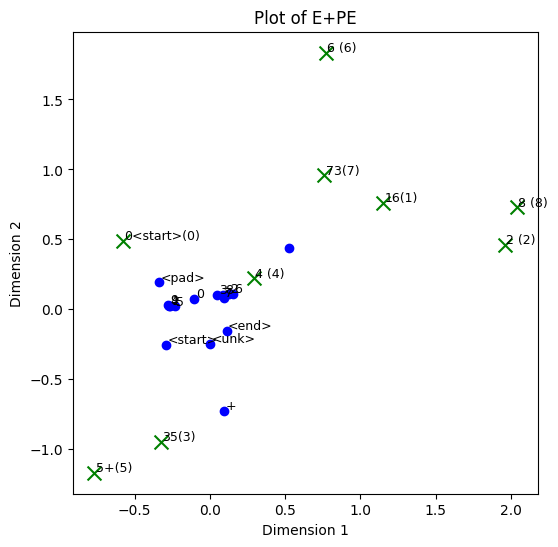

SelfAttention Layer
QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 9, 4])
WV.shape: torch.Size([1, 9, 4])
attn_weight.shape: torch.Size([1, 9, 9])
AV.shape: torch.Size([1, 9, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]
  [ 0.965866    0.07053957  1.4842246  -0.3846688 ]
  [-0.83484656  1.4373012   0.5792201  -0.5744088 ]
  [ 2.4699285  -1.335511    1.4578295   0.2476317 ]
  [ 0.26438832 -2.173289    0.09268427  1.0571992 ]
  [ 2.1719797  -1.2294121   2.203474   -0.70533437]]]
(1, 9, 4)
[[ 0.7114342   0.2834468 ]
 [ 0.505927   -2.0341296 ]
 [ 1.9474189  -0.9667186 ]
 [-2.532358   -1.0347031 ]
 [ 0.965866    0.07053957]
 [-0.83484656  1.4373012 ]
 [ 2.4699285  -1.335511  ]
 [ 0.26438832 -2.173289  ]
 [ 2.1719797  -1.2294121 ]]


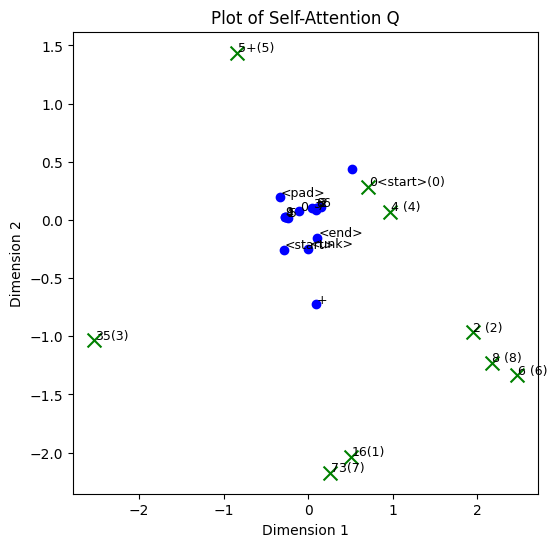

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]
  [ 0.33235416  0.45209563  0.41340655 -0.4876575 ]
  [ 0.3828183   1.4692954  -0.64528066 -1.9975775 ]
  [ 0.95665556 -1.2246394   1.414116    1.4234873 ]
  [ 0.03392431 -2.040095   -0.02586579  2.6158478 ]
  [-0.9441848  -0.3112424   0.8461021   1.504194  ]]]
(1, 9, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]
 [ 0.33235416  0.45209563]
 [ 0.3828183   1.4692954 ]
 [ 0.95665556 -1.2246394 ]
 [ 0.03392431 -2.040095  ]
 [-0.9441848  -0.3112424 ]]


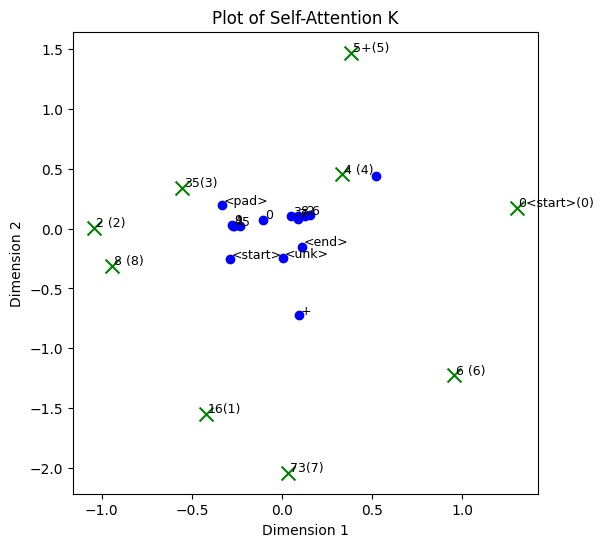

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]
  [-0.22209424  0.71188325 -0.25376043 -0.5252558 ]
  [ 0.5861341   0.13321787  0.69309384  0.43203232]
  [-1.1467686   0.8873743  -0.9800878  -0.97567254]
  [-1.0836861  -1.5115368  -1.0895604  -0.61330616]
  [-0.54917705  0.58775806 -1.089325   -1.4237993 ]]]
(1, 9, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]
 [-0.22209424  0.71188325]
 [ 0.5861341   0.13321787]
 [-1.1467686   0.8873743 ]
 [-1.0836861  -1.5115368 ]
 [-0.54917705  0.58775806]]


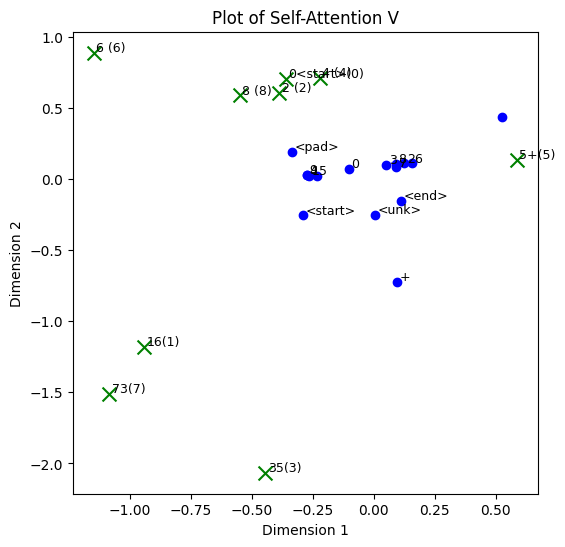

[[[-0.5495532   0.26107836 -0.57836413 -0.66090536]
  [-0.9842255  -0.5847214  -1.0306802  -0.81170833]
  [-0.74131763  0.64081883 -0.5840854  -0.63153374]
  [-0.7764126  -0.40618598 -1.069113   -1.0349942 ]
  [-0.53572845  0.4484554  -0.48892376 -0.58722633]
  [-0.08122005  0.08603948 -0.18599343 -0.38432002]
  [-0.9518287   0.39887312 -0.8362089  -0.78965515]
  [-1.0005903  -0.9253857  -1.0698345  -0.77732384]
  [-0.8148538   0.63810927 -0.6562421  -0.68367994]]]
(1, 9, 4)
[[-0.5495532   0.26107836]
 [-0.9842255  -0.5847214 ]
 [-0.74131763  0.64081883]
 [-0.7764126  -0.40618598]
 [-0.53572845  0.4484554 ]
 [-0.08122005  0.08603948]
 [-0.9518287   0.39887312]
 [-1.0005903  -0.9253857 ]
 [-0.8148538   0.63810927]]


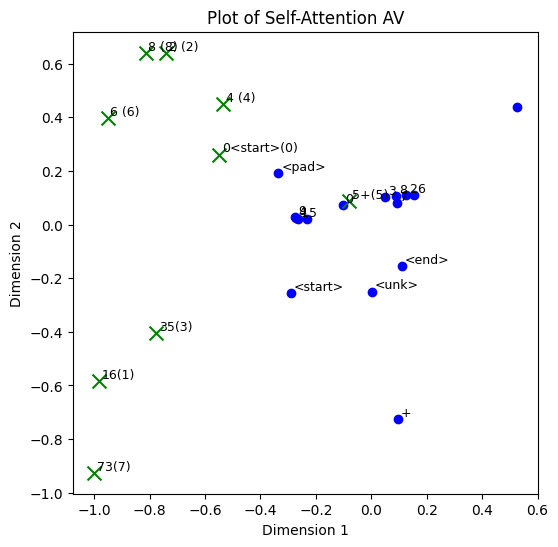

[[[-6.0629082e-01  5.7266510e-01  1.1726394e+00 -1.4776699e-03]]

 [[-1.1941510e+00  3.5644442e-02  1.5455244e+00  8.5500801e-01]]

 [[-4.2806268e-01  9.0717685e-01  1.5607967e+00 -5.1260448e-01]]

 [[-1.3267237e+00  3.7842998e-01  1.3786006e+00  9.0248710e-01]]

 [[-4.4439906e-01  6.6569936e-01  1.1944544e+00 -2.5260910e-01]]

 [[-3.3788025e-01  8.3628148e-02  3.7407660e-01  1.7834161e-01]]

 [[-7.2648299e-01  8.7609100e-01  1.8222201e+00 -2.2001161e-01]]

 [[-1.3124845e+00 -2.9509053e-01  1.4446146e+00  1.1953293e+00]]

 [[-4.9234447e-01  9.6536577e-01  1.6785429e+00 -5.0178081e-01]]]
(9, 1, 4)
[[-0.6062908   0.5726651 ]
 [-1.194151    0.03564444]
 [-0.42806268  0.90717685]
 [-1.3267237   0.37842998]
 [-0.44439906  0.66569936]
 [-0.33788025  0.08362815]
 [-0.726483    0.876091  ]
 [-1.3124845  -0.29509053]
 [-0.49234447  0.96536577]]


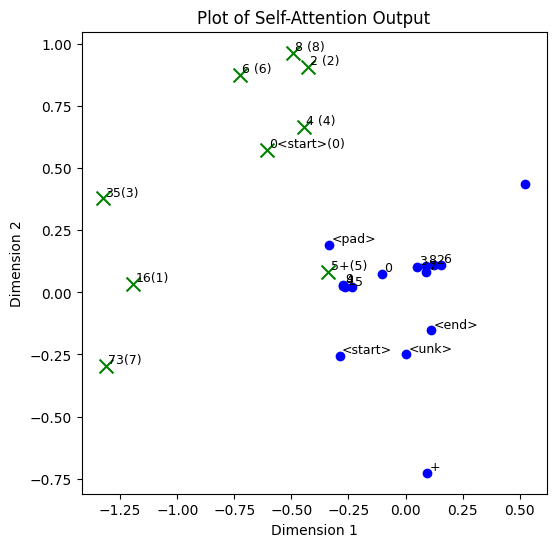

[[[-2.1174786   0.6619645   0.32104182  0.37833503]]

 [[-1.8504523  -0.6745601   1.4414895   0.74149823]]

 [[ 1.4248629   0.38646117 -0.394542   -1.6913491 ]]

 [[-1.6269767  -0.8667815   0.7946146   1.6881119 ]]

 [[-1.2792499   1.0542179  -0.3123272  -0.21775569]]

 [[-1.3524958  -1.0981585   0.95740855  1.5696669 ]]

 [[-1.0835633   1.0790755   0.00273145 -0.86725706]]

 [[-1.8716264  -0.66021675  1.4211606   0.76651895]]

 [[ 1.1088843   0.55430776 -0.28942376 -1.788331  ]]]
(9, 1, 4)
[[-2.1174786   0.6619645 ]
 [-1.8504523  -0.6745601 ]
 [ 1.4248629   0.38646117]
 [-1.6269767  -0.8667815 ]
 [-1.2792499   1.0542179 ]
 [-1.3524958  -1.0981585 ]
 [-1.0835633   1.0790755 ]
 [-1.8716264  -0.66021675]
 [ 1.1088843   0.55430776]]


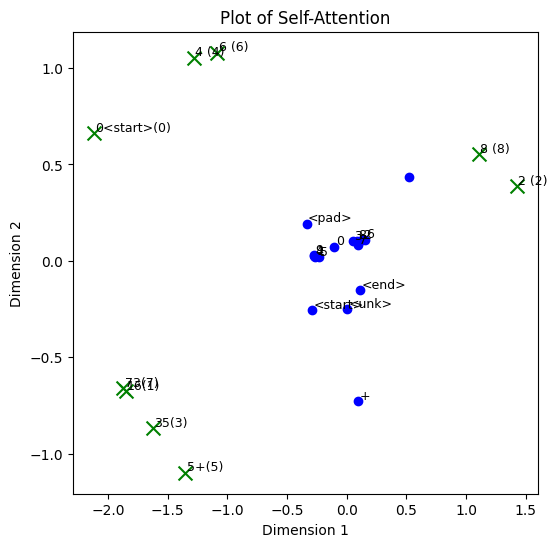

QV.shape: torch.Size([1, 9, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 9, 15])
AV.shape: torch.Size([1, 9, 4])
[[[-1.400666   -4.0655155   4.0912676   1.148312  ]
  [-0.0408889  -4.0829663   4.0108085   2.4128585 ]
  [-0.92138356  2.386032   -3.172697   -1.8041073 ]
  [ 1.1323309  -2.9998157   3.8197725   2.4970114 ]
  [-1.676303   -2.3090696   2.2250803  -0.06198492]
  [ 1.3414783  -2.6105099   3.3231492   2.5026648 ]
  [-2.1883254  -2.320115    1.7038928  -0.3078822 ]
  [-0.03958725 -4.103653    4.0533137   2.417431  ]
  [-1.3241574   1.6995226  -2.6214085  -1.7189313 ]]]
(1, 9, 4)
[[-1.400666   -4.0655155 ]
 [-0.0408889  -4.0829663 ]
 [-0.92138356  2.386032  ]
 [ 1.1323309  -2.9998157 ]
 [-1.676303   -2.3090696 ]
 [ 1.3414783  -2.6105099 ]
 [-2.1883254  -2.320115  ]
 [-0.03958725 -4.103653  ]
 [-1.3241574   1.6995226 ]]


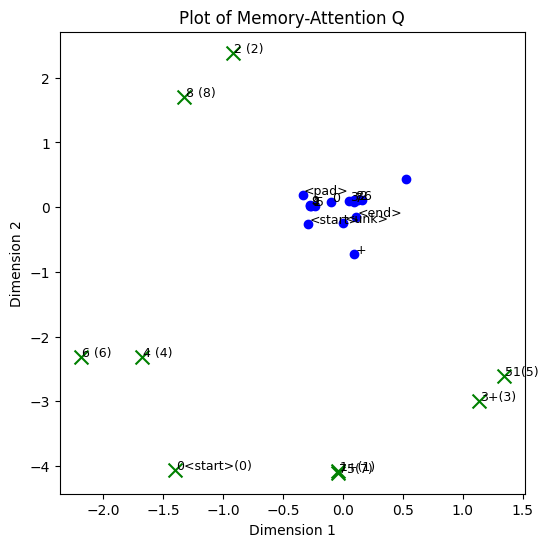

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

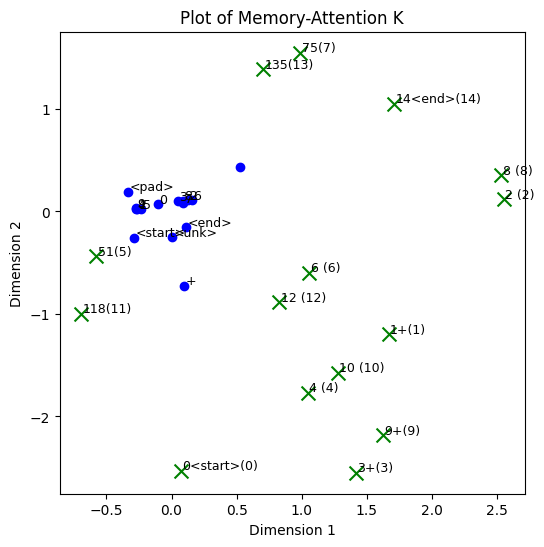

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

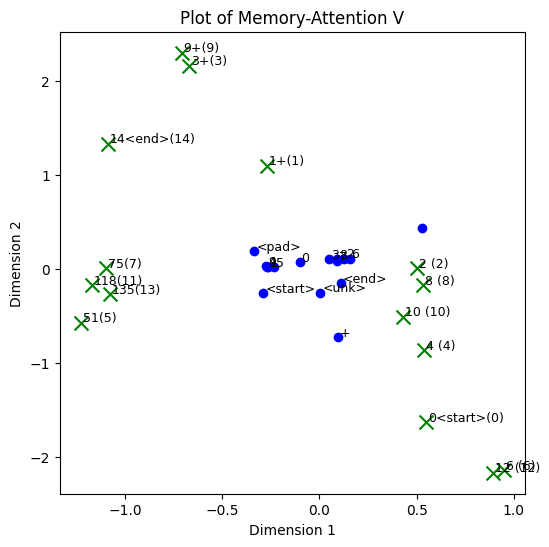

[[-0.57023853  1.822924    2.0546396   0.64845717]
 [-0.66239965  2.1324642   2.323689    0.67590874]
 [-0.8290845  -0.15341902  1.0075661   0.16197532]
 [-0.671746    2.1639042   2.362142    0.67520714]
 [-0.328758    0.29523402  0.628262    0.29350376]
 [-0.6697167   2.1596987   2.36605     0.6736811 ]
 [-0.29859063 -0.28131253  0.02955624  0.09236459]
 [-0.66281885  2.133702    2.3244221   0.67604995]
 [-0.7637059  -0.26255918  0.87987286  0.14584863]]
(9, 4)
[[-0.57023853  1.822924  ]
 [-0.66239965  2.1324642 ]
 [-0.8290845  -0.15341902]
 [-0.671746    2.1639042 ]
 [-0.328758    0.29523402]
 [-0.6697167   2.1596987 ]
 [-0.29859063 -0.28131253]
 [-0.66281885  2.133702  ]
 [-0.7637059  -0.26255918]]


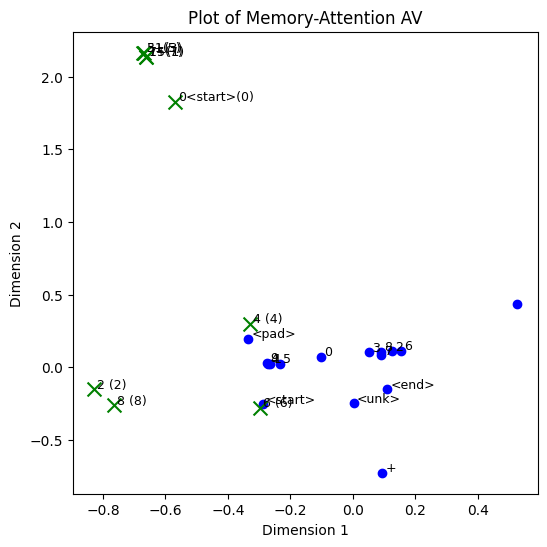

[[[-6.0629082e-01  5.7266510e-01  1.1726394e+00 -1.4776699e-03]]

 [[-1.1941510e+00  3.5644442e-02  1.5455244e+00  8.5500801e-01]]

 [[-4.2806268e-01  9.0717685e-01  1.5607967e+00 -5.1260448e-01]]

 [[-1.3267237e+00  3.7842998e-01  1.3786006e+00  9.0248710e-01]]

 [[-4.4439906e-01  6.6569936e-01  1.1944544e+00 -2.5260910e-01]]

 [[-3.3788025e-01  8.3628148e-02  3.7407660e-01  1.7834161e-01]]

 [[-7.2648299e-01  8.7609100e-01  1.8222201e+00 -2.2001161e-01]]

 [[-1.3124845e+00 -2.9509053e-01  1.4446146e+00  1.1953293e+00]]

 [[-4.9234447e-01  9.6536577e-01  1.6785429e+00 -5.0178081e-01]]]
(9, 1, 4)
[[-0.6062908   0.5726651 ]
 [-1.194151    0.03564444]
 [-0.42806268  0.90717685]
 [-1.3267237   0.37842998]
 [-0.44439906  0.66569936]
 [-0.33788025  0.08362815]
 [-0.726483    0.876091  ]
 [-1.3124845  -0.29509053]
 [-0.49234447  0.96536577]]


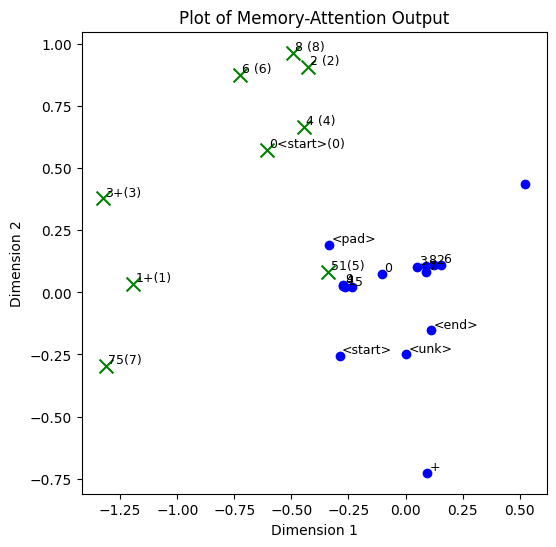

[[[-1.6451545   0.4811017   0.41890916  0.6145413 ]]

 [[-1.6904856   0.20645042  0.6392612   0.68699604]]

 [[ 0.0135025   0.28735885  1.1341858  -1.2430415 ]]

 [[-1.6574092   0.14521863  0.4724775   0.8431618 ]]

 [[-1.5600268   0.7824385   0.47109896  0.26366794]]

 [[-1.6628505   0.10583842  0.5148802   0.84378076]]

 [[-0.7379046   0.6388743   1.1670743  -0.8999438 ]]

 [[-1.6898453   0.20811056  0.6333955   0.68996155]]

 [[ 0.04283334  0.23728588  1.1575044  -1.2482479 ]]]
(9, 1, 4)
[[-1.6451545   0.4811017 ]
 [-1.6904856   0.20645042]
 [ 0.0135025   0.28735885]
 [-1.6574092   0.14521863]
 [-1.5600268   0.7824385 ]
 [-1.6628505   0.10583842]
 [-0.7379046   0.6388743 ]
 [-1.6898453   0.20811056]
 [ 0.04283334  0.23728588]]


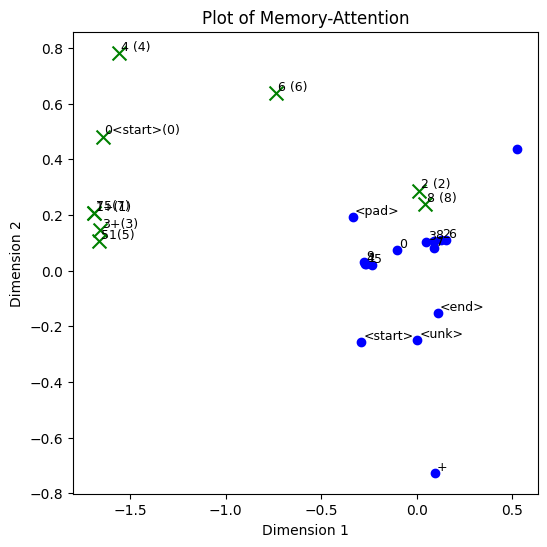

AfterLinear.shape: torch.Size([9, 1, 4])
AfterAddTGT.shape: torch.Size([9, 1, 4])
AfterAddTGT: tensor([[[-0.6985,  4.0536, -4.7883,  1.8589]],

        [[-2.8033,  3.2340, -3.7268,  3.2426]],

        [[-0.8237,  2.6435,  3.0210, -4.2837]],

        [[-2.6489,  2.8952, -3.8022,  3.4666]],

        [[ 0.4072,  4.4647, -4.8676,  0.6946]],

        [[-3.0078,  2.6656, -3.5017,  3.6630]],

        [[-0.1952,  5.8765, -2.9129, -1.8276]],

        [[-2.7744,  3.2421, -3.7482,  3.2326]],

        [[-0.4238,  2.3526,  3.0582, -4.4061]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[-8.9906, 12.4746,  5.9132, -5.3023,  8.8349, 14.5127,  9.3647, 11.8054,  1.3463,  2.5209,
         -0.1390,  0.2278,  0.8584, -2.8265,  7.3176, -6.8364]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 5

------------------

iter: 9
ys: tensor([[12],
        [ 6],
        [15],
        [ 5],
        [15],
        [14],
        [15],
    

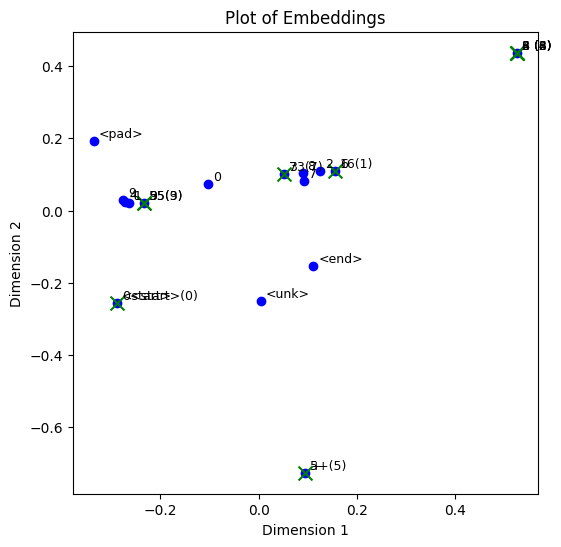

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]

 [[ 0.29346734  0.22062886 -1.1892636   0.41529012]]

 [[-0.768994   -1.168677   -0.41812384  0.06390113]]

 [[ 0.77085435  1.8344427  -1.1692889   0.41429055]]

 [[ 0.7590668   0.956551    1.3100457   0.77085614]]

 [[ 2.039628    0.7287724  -1.1493382   0.4128917 ]]

 [[-0.05408508 -0.87081254  0.71443367  2.6296563 ]]]
(10, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]
 [ 0.29346734  0.22062886]
 [-0.768994   -1.168677  ]
 [ 0.77085435  1.8344427 ]
 [ 0.7590668   0.956551  ]
 [ 2.039628    0.7287724 ]
 [-0.05408508 -0.87081254]]


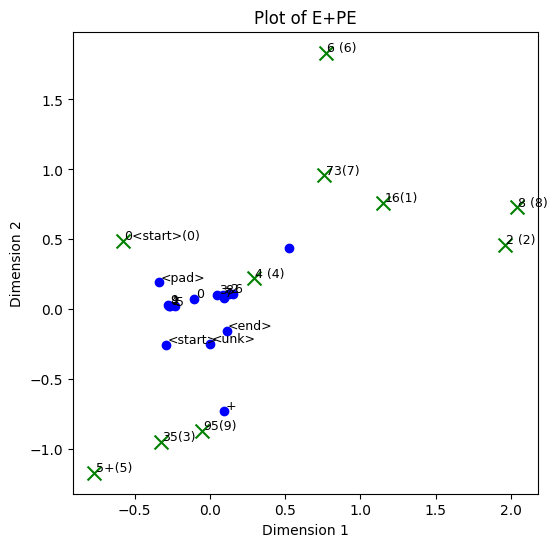

SelfAttention Layer
QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 10, 4])
WV.shape: torch.Size([1, 10, 4])
attn_weight.shape: torch.Size([1, 10, 10])
AV.shape: torch.Size([1, 10, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]
  [ 0.965866    0.07053957  1.4842246  -0.3846688 ]
  [-0.83484656  1.4373012   0.5792201  -0.5744088 ]
  [ 2.4699285  -1.335511    1.4578295   0.2476317 ]
  [ 0.26438832 -2.173289    0.09268427  1.0571992 ]
  [ 2.1719797  -1.2294121   2.203474   -0.70533437]
  [-2.371125   -1.2616495   0.9559436   1.2083375 ]]]
(1, 10, 4)
[[ 0.7114342   0.2834468 ]
 [ 0.505927   -2.0341296 ]
 [ 1.9474189  -0.9667186 ]
 [-2.532358   -1.0347031 ]
 [ 0.965866    0.07053957]
 [-0.83484656  1.4373012 ]
 [ 2.4699285  -1.335511  ]
 [ 0.26438832 -2.173289  ]
 [ 2.1719797  -1.2294121 ]
 [-2.371125   -1.2616495 ]]


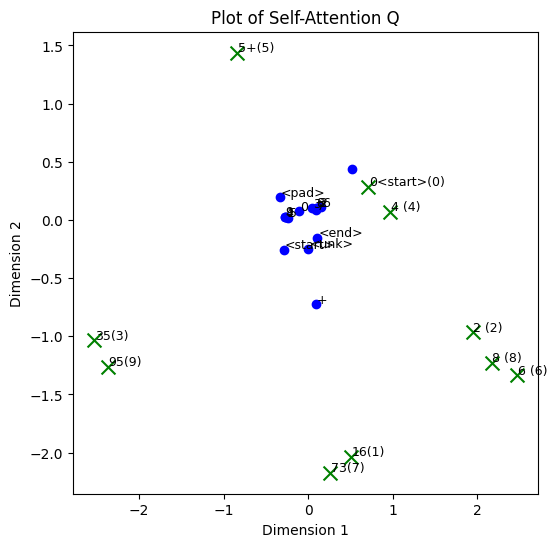

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]
  [ 0.33235416  0.45209563  0.41340655 -0.4876575 ]
  [ 0.3828183   1.4692954  -0.64528066 -1.9975775 ]
  [ 0.95665556 -1.2246394   1.414116    1.4234873 ]
  [ 0.03392431 -2.040095   -0.02586579  2.6158478 ]
  [-0.9441848  -0.3112424   0.8461021   1.504194  ]
  [-0.7582805   0.18767633 -1.574228   -0.4617222 ]]]
(1, 10, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]
 [ 0.33235416  0.45209563]
 [ 0.3828183   1.4692954 ]
 [ 0.95665556 -1.2246394 ]
 [ 0.03392431 -2.040095  ]
 [-0.9441848  -0.3112424 ]
 [-0.7582805   0.18767633]]


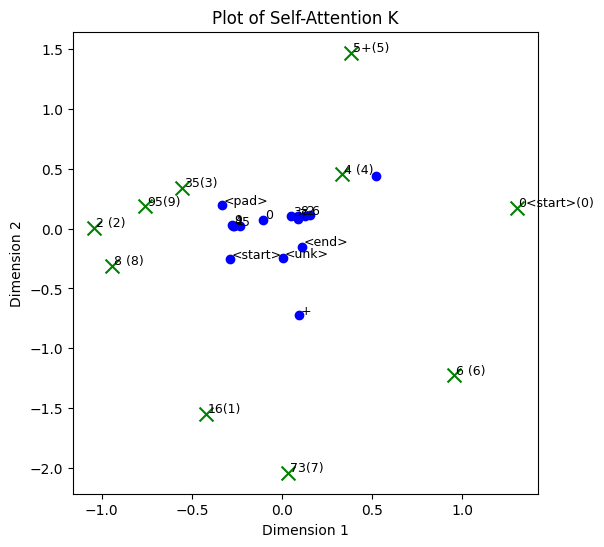

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]
  [-0.22209424  0.71188325 -0.25376043 -0.5252558 ]
  [ 0.5861341   0.13321787  0.69309384  0.43203232]
  [-1.1467686   0.8873743  -0.9800878  -0.97567254]
  [-1.0836861  -1.5115368  -1.0895604  -0.61330616]
  [-0.54917705  0.58775806 -1.089325   -1.4237993 ]
  [-0.5017034  -2.127848   -0.92400056 -0.79294485]]]
(1, 10, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]
 [-0.22209424  0.71188325]
 [ 0.5861341   0.13321787]
 [-1.1467686   0.8873743 ]
 [-1.0836861  -1.5115368 ]
 [-0.54917705  0.58775806]
 [-0.5017034  -2.127848  ]]


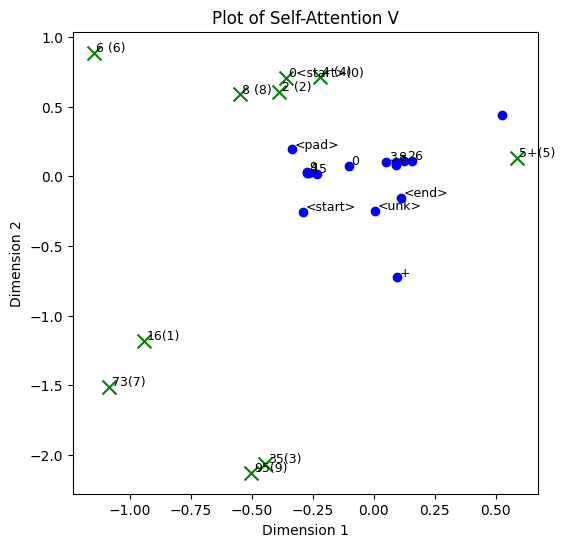

[[[-0.54790395  0.1787382  -0.59027725 -0.66545635]
  [-0.98064435 -0.5961738  -1.0298884  -0.81156904]
  [-0.74048096  0.63115185 -0.5852723  -0.63209724]
  [-0.77225953 -0.4322143  -1.0669191  -1.0313349 ]
  [-0.5350891   0.4000385  -0.49710026 -0.59109247]
  [-0.12287605 -0.13328348 -0.25910553 -0.42480123]
  [-0.95070225  0.39254966 -0.8364285  -0.78966343]
  [-0.9967831  -0.9345621  -1.0687214  -0.777443  ]
  [-0.81404746  0.6309878  -0.65693146 -0.68396133]
  [-0.8029364  -0.5042049  -1.0713657  -1.0012811 ]]]
(1, 10, 4)
[[-0.54790395  0.1787382 ]
 [-0.98064435 -0.5961738 ]
 [-0.74048096  0.63115185]
 [-0.77225953 -0.4322143 ]
 [-0.5350891   0.4000385 ]
 [-0.12287605 -0.13328348]
 [-0.95070225  0.39254966]
 [-0.9967831  -0.9345621 ]
 [-0.81404746  0.6309878 ]
 [-0.8029364  -0.5042049 ]]


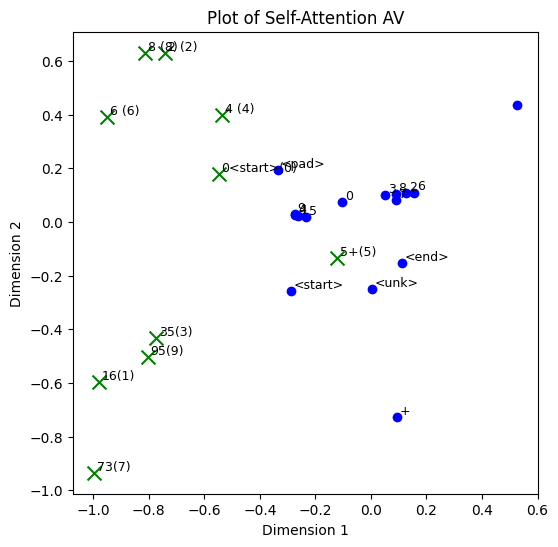

[[[-0.64477164  0.5022423   1.1435778   0.09180735]]

 [[-1.198074    0.02446645  1.5364993   0.8687378 ]]

 [[-0.43258312  0.898875    1.5564976  -0.50137   ]]

 [[-1.3327104   0.35047755  1.36274     0.92973757]]

 [[-0.46842304  0.62555337  1.178199   -0.19702639]]

 [[-0.4750734  -0.07033461  0.36965847  0.42864925]]

 [[-0.7289762   0.8702184   1.8184845  -0.21269132]]

 [[-1.315615   -0.30406052  1.4361045   1.2068499 ]]

 [[-0.49551234  0.9590943   1.6750693  -0.4935243 ]]

 [[-1.3369454   0.2626758   1.3730357   0.9745846 ]]]
(10, 1, 4)
[[-0.64477164  0.5022423 ]
 [-1.198074    0.02446645]
 [-0.43258312  0.898875  ]
 [-1.3327104   0.35047755]
 [-0.46842304  0.62555337]
 [-0.4750734  -0.07033461]
 [-0.7289762   0.8702184 ]
 [-1.315615   -0.30406052]
 [-0.49551234  0.9590943 ]
 [-1.3369454   0.2626758 ]]


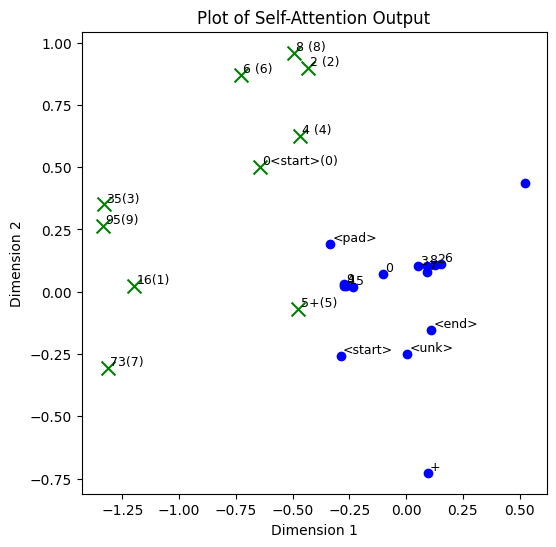

[[[-2.1539772e+00  5.9881824e-01  2.9933304e-01  5.4274577e-01]]

 [[-1.8486595e+00 -6.8157244e-01  1.4320960e+00  7.6333940e-01]]

 [[ 1.4315730e+00  3.8427365e-01 -4.0407580e-01 -1.6817535e+00]]

 [[-1.6168768e+00 -8.7200475e-01  7.8616345e-01  1.6977614e+00]]

 [[-1.3705232e+00  1.0154688e+00 -3.5057023e-01 -1.6480930e-02]]

 [[-1.3086859e+00 -1.0951205e+00  8.2137448e-01  1.7030849e+00]]

 [[-1.0881400e+00  1.0793487e+00 -2.1562092e-04 -8.5930091e-01]]

 [[-1.8707517e+00 -6.6421545e-01  1.4152113e+00  7.7990705e-01]]

 [[ 1.1125013e+00  5.5411291e-01 -2.9581937e-01 -1.7830442e+00]]

 [[-1.5440875e+00 -9.2799872e-01  7.9016852e-01  1.7099720e+00]]]
(10, 1, 4)
[[-2.1539772   0.59881824]
 [-1.8486595  -0.68157244]
 [ 1.431573    0.38427365]
 [-1.6168768  -0.87200475]
 [-1.3705232   1.0154688 ]
 [-1.3086859  -1.0951205 ]
 [-1.08814     1.0793487 ]
 [-1.8707517  -0.66421545]
 [ 1.1125013   0.5541129 ]
 [-1.5440875  -0.9279987 ]]


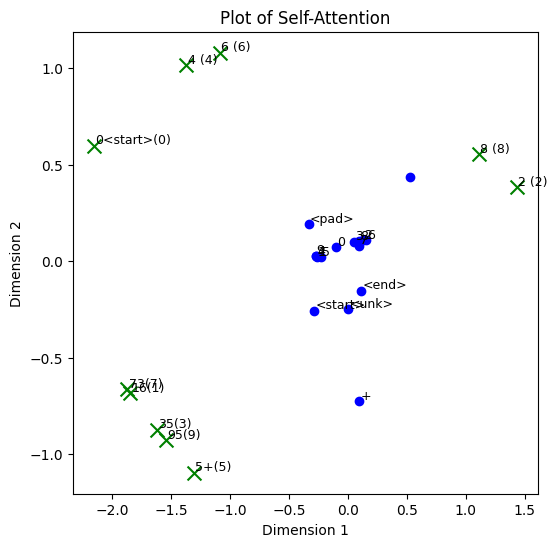

QV.shape: torch.Size([1, 10, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 10, 15])
AV.shape: torch.Size([1, 10, 4])
[[[-1.2269462  -4.0709834   4.213356    1.2617624 ]
  [-0.01437806 -4.0674615   4.0136776   2.4205887 ]
  [-0.90646535  2.4070928  -3.183249   -1.8068887 ]
  [ 1.1513989  -2.9729495   3.8034453   2.4946058 ]
  [-1.5179676  -2.3971477   2.454947    0.07528379]
  [ 1.495894   -2.4091768   3.2638988   2.4705327 ]
  [-2.183826   -2.3246129   1.7143754  -0.30359498]
  [-0.02366995 -4.0944643   4.0554285   2.4220364 ]
  [-1.3166239   1.7116224  -2.6273437  -1.7215068 ]
  [ 1.2453389  -2.833945    3.6791487   2.4933445 ]]]
(1, 10, 4)
[[-1.2269462  -4.0709834 ]
 [-0.01437806 -4.0674615 ]
 [-0.90646535  2.4070928 ]
 [ 1.1513989  -2.9729495 ]
 [-1.5179676  -2.3971477 ]
 [ 1.495894   -2.4091768 ]
 [-2.183826   -2.3246129 ]
 [-0.02366995 -4.0944643 ]
 [-1.3166239   1.7116224 ]
 [ 1.2453389  -2.833945  ]]


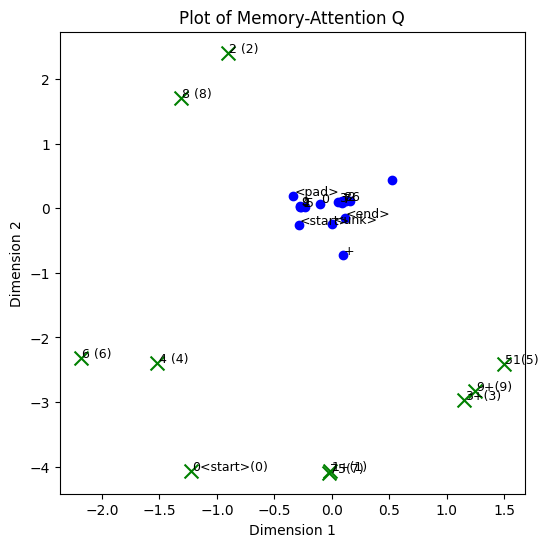

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

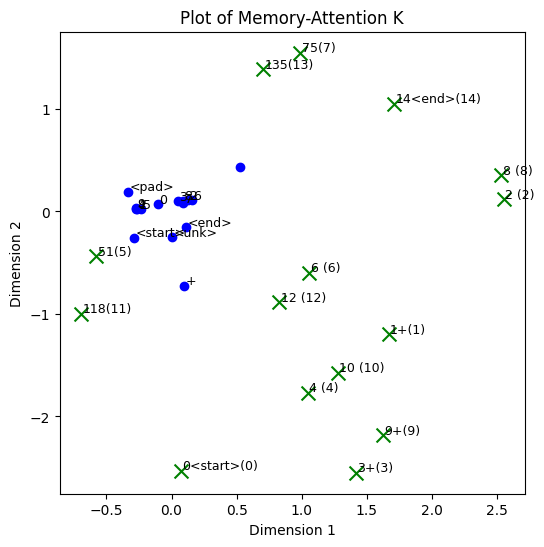

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

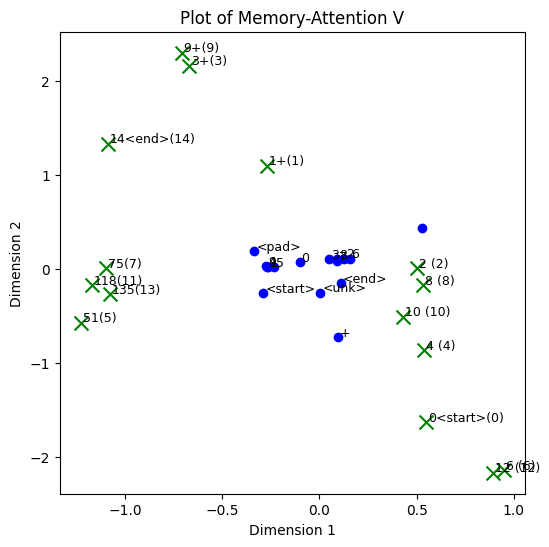

[[-0.5939337   1.9042492   2.1250193   0.6564963 ]
 [-0.6628376   2.1338599   2.3250136   0.6759661 ]
 [-0.830912   -0.15051709  1.0104611   0.16214895]
 [-0.6717421   2.16398     2.3625872   0.6751344 ]
 [-0.35395515  0.59336674  0.9258611   0.38417447]
 [-0.6695613   2.1600394   2.3694882   0.67311907]
 [-0.29782325 -0.27455166  0.03715196  0.09581408]
 [-0.6630797   2.1345325   2.3252077   0.6760844 ]
 [-0.76565206 -0.2599604   0.88272107  0.14612281]
 [-0.67153466  2.1638947   2.3647523   0.67470014]]
(10, 4)
[[-0.5939337   1.9042492 ]
 [-0.6628376   2.1338599 ]
 [-0.830912   -0.15051709]
 [-0.6717421   2.16398   ]
 [-0.35395515  0.59336674]
 [-0.6695613   2.1600394 ]
 [-0.29782325 -0.27455166]
 [-0.6630797   2.1345325 ]
 [-0.76565206 -0.2599604 ]
 [-0.67153466  2.1638947 ]]


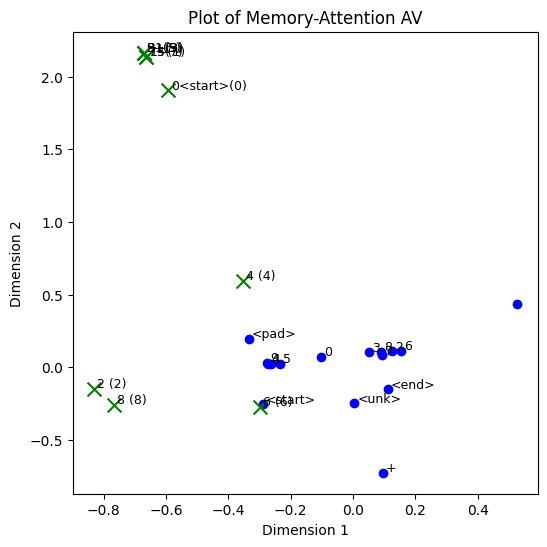

[[[-0.64477164  0.5022423   1.1435778   0.09180735]]

 [[-1.198074    0.02446645  1.5364993   0.8687378 ]]

 [[-0.43258312  0.898875    1.5564976  -0.50137   ]]

 [[-1.3327104   0.35047755  1.36274     0.92973757]]

 [[-0.46842304  0.62555337  1.178199   -0.19702639]]

 [[-0.4750734  -0.07033461  0.36965847  0.42864925]]

 [[-0.7289762   0.8702184   1.8184845  -0.21269132]]

 [[-1.315615   -0.30406052  1.4361045   1.2068499 ]]

 [[-0.49551234  0.9590943   1.6750693  -0.4935243 ]]

 [[-1.3369454   0.2626758   1.3730357   0.9745846 ]]]
(10, 1, 4)
[[-0.64477164  0.5022423 ]
 [-1.198074    0.02446645]
 [-0.43258312  0.898875  ]
 [-1.3327104   0.35047755]
 [-0.46842304  0.62555337]
 [-0.4750734  -0.07033461]
 [-0.7289762   0.8702184 ]
 [-1.315615   -0.30406052]
 [-0.49551234  0.9590943 ]
 [-1.3369454   0.2626758 ]]


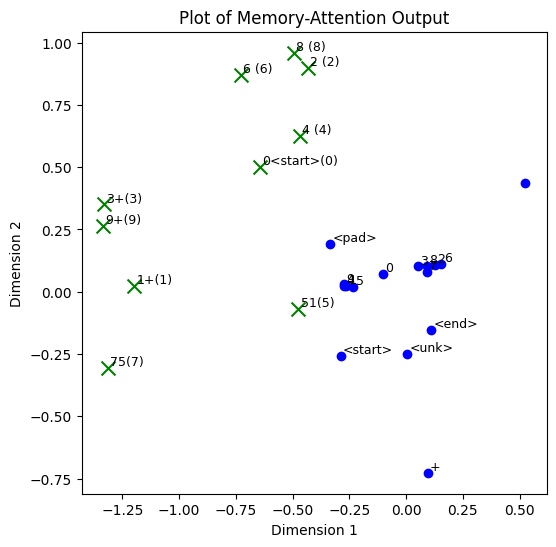

[[[-1.6447256   0.46221015  0.40493944  0.64036626]]

 [[-1.6901373   0.20443183  0.63647807  0.69055426]]

 [[ 0.01175466  0.29313654  1.1302652  -1.2428355 ]]

 [[-1.6568145   0.14410491  0.47045466  0.84517926]]

 [[-1.5921226   0.6890372   0.35932255  0.45570844]]

 [[-1.6547065   0.10353329  0.48089504  0.8664628 ]]

 [[-0.76282007  0.6511527   1.1603475  -0.882643  ]]

 [[-1.6896228   0.20692904  0.6316511   0.6921229 ]]

 [[ 0.03951456  0.2427373   1.1551249  -1.2477038 ]]

 [[-1.6559821   0.13376096  0.4715548   0.85163325]]]
(10, 1, 4)
[[-1.6447256   0.46221015]
 [-1.6901373   0.20443183]
 [ 0.01175466  0.29313654]
 [-1.6568145   0.14410491]
 [-1.5921226   0.6890372 ]
 [-1.6547065   0.10353329]
 [-0.76282007  0.6511527 ]
 [-1.6896228   0.20692904]
 [ 0.03951456  0.2427373 ]
 [-1.6559821   0.13376096]]


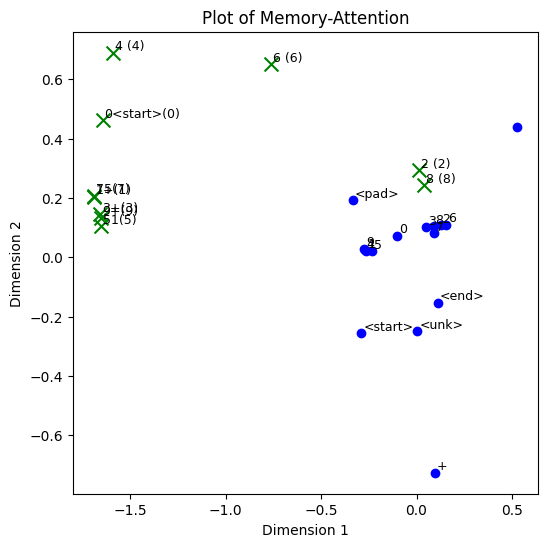

AfterLinear.shape: torch.Size([10, 1, 4])
AfterAddTGT.shape: torch.Size([10, 1, 4])
AfterAddTGT: tensor([[[-0.7566,  4.0041, -4.7789,  1.9380]],

        [[-2.8068,  3.2228, -3.7235,  3.2515]],

        [[-0.8330,  2.6737,  3.0019, -4.2829]],

        [[-2.6492,  2.8892, -3.8012,  3.4709]],

        [[ 0.2220,  4.2869, -4.9326,  1.0534]],

        [[-2.9154,  2.6579, -3.5710,  3.6597]],

        [[-0.1384,  5.8441, -3.0440, -1.7231]],

        [[-2.7761,  3.2355, -3.7465,  3.2378]],

        [[-0.4824,  2.3988,  3.0517, -4.3901]],

        [[-2.7126,  2.8323, -3.7484,  3.5193]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  1.2244, -14.6864, -17.0655, -10.1723, -13.7517,  -9.0926, -14.9169,  -6.6541, -15.5057,
          -8.9420,  -1.0927,  -2.2108,  -2.0259,   0.4214,   2.9480,  13.1554]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 15

------------------

iter: 10
ys: tensor([[12],
        [ 6],
     

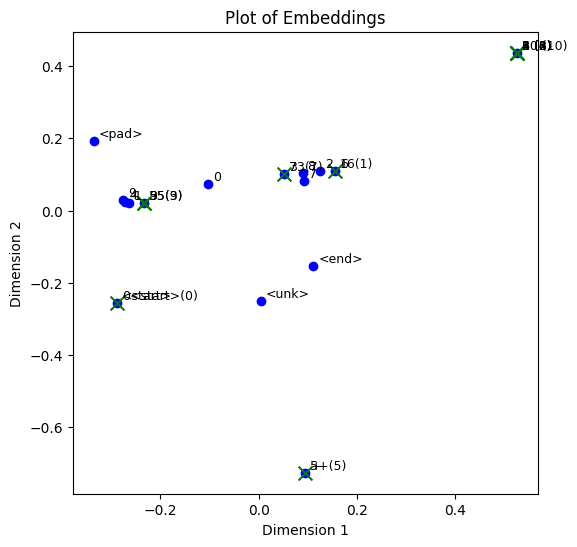

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]

 [[ 0.29346734  0.22062886 -1.1892636   0.41529012]]

 [[-0.768994   -1.168677   -0.41812384  0.06390113]]

 [[ 0.77085435  1.8344427  -1.1692889   0.41429055]]

 [[ 0.7590668   0.956551    1.3100457   0.77085614]]

 [[ 2.039628    0.7287724  -1.1493382   0.4128917 ]]

 [[-0.05408508 -0.87081254  0.71443367  2.6296563 ]]

 [[ 0.5062487   0.03520095 -1.1294196   0.4110942 ]]]
(11, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]
 [ 0.29346734  0.22062886]
 [-0.768994   -1.168677  ]
 [ 0.77085435  1.8344427 ]
 [ 0.7590668   0.956551  ]
 [ 2.039628    0.7287724 ]
 [-0.05408508 -0.87081254]
 [ 0.5062487   0.03520095]]


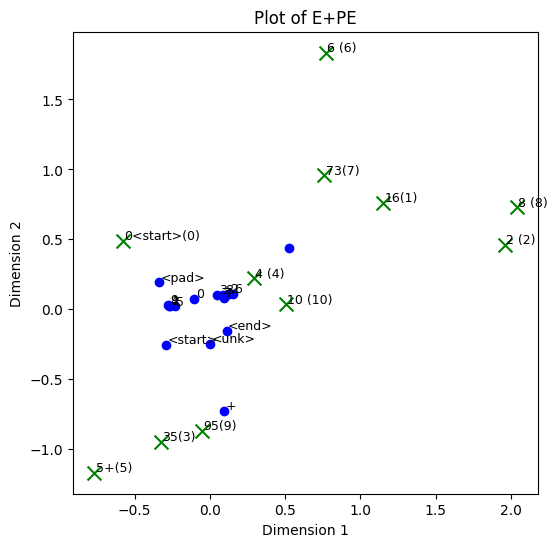

SelfAttention Layer
QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 11, 4])
WV.shape: torch.Size([1, 11, 4])
attn_weight.shape: torch.Size([1, 11, 11])
AV.shape: torch.Size([1, 11, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]
  [ 0.965866    0.07053957  1.4842246  -0.3846688 ]
  [-0.83484656  1.4373012   0.5792201  -0.5744088 ]
  [ 2.4699285  -1.335511    1.4578295   0.2476317 ]
  [ 0.26438832 -2.173289    0.09268427  1.0571992 ]
  [ 2.1719797  -1.2294121   2.203474   -0.70533437]
  [-2.371125   -1.2616495   0.9559436   1.2083375 ]
  [ 0.8889238   0.06215561  1.571501   -0.5230212 ]]]
(1, 11, 4)
[[ 0.7114342   0.2834468 ]
 [ 0.505927   -2.0341296 ]
 [ 1.9474189  -0.9667186 ]
 [-2.532358   -1.0347031 ]
 [ 0.965866    0.07053957]
 [-0.83484656  1.4373012 ]
 [ 2.4699285  -1.335511  ]
 [ 0.26438832 -2.173289  ]
 [ 2

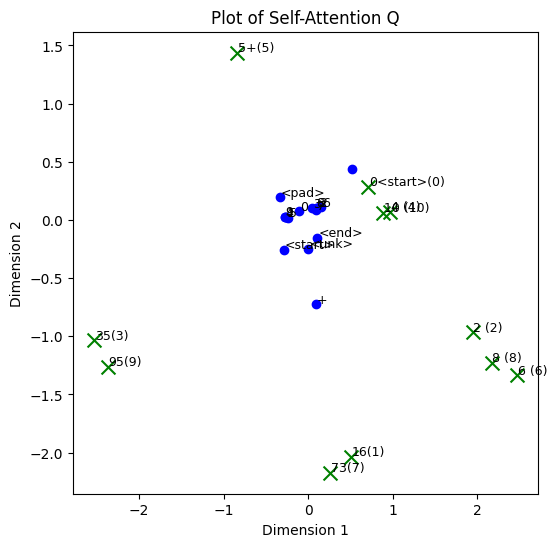

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]
  [ 0.33235416  0.45209563  0.41340655 -0.4876575 ]
  [ 0.3828183   1.4692954  -0.64528066 -1.9975775 ]
  [ 0.95665556 -1.2246394   1.414116    1.4234873 ]
  [ 0.03392431 -2.040095   -0.02586579  2.6158478 ]
  [-0.9441848  -0.3112424   0.8461021   1.504194  ]
  [-0.7582805   0.18767633 -1.574228   -0.4617222 ]
  [ 0.00811601  0.5674353   0.30112606 -0.4269424 ]]]
(1, 11, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]
 [ 0.33235416  0.45209563]
 [ 0.3828183   1.4692954 ]
 [ 0.95665556 -1.2246394 ]
 [ 0.03392431 -2.040095  ]
 [-0.9441848  -0.3112424 ]
 [-0.7582805   0.18767633]
 [ 0.00811601  0.5674353 ]]


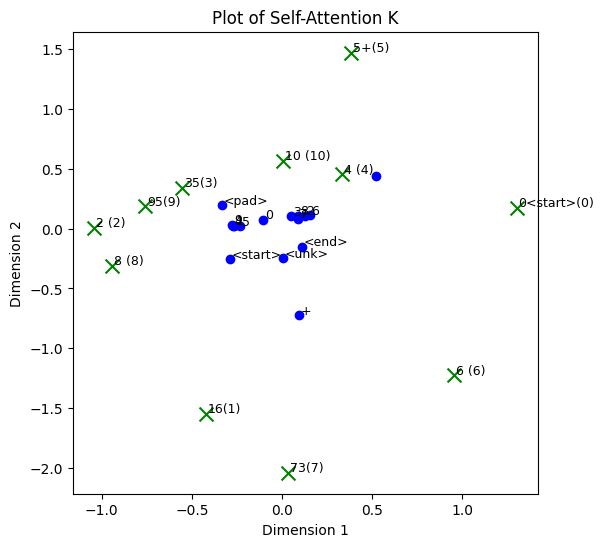

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]
  [-0.22209424  0.71188325 -0.25376043 -0.5252558 ]
  [ 0.5861341   0.13321787  0.69309384  0.43203232]
  [-1.1467686   0.8873743  -0.9800878  -0.97567254]
  [-1.0836861  -1.5115368  -1.0895604  -0.61330616]
  [-0.54917705  0.58775806 -1.089325   -1.4237993 ]
  [-0.5017034  -2.127848   -0.92400056 -0.79294485]
  [-0.12820074  0.6159197  -0.27609378 -0.5903069 ]]]
(1, 11, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]
 [-0.22209424  0.71188325]
 [ 0.5861341   0.13321787]
 [-1.1467686   0.8873743 ]
 [-1.0836861  -1.5115368 ]
 [-0.54917705  0.58775806]
 [-0.5017034  -2.127848  ]
 [-0.12820074  0.6159197 ]]


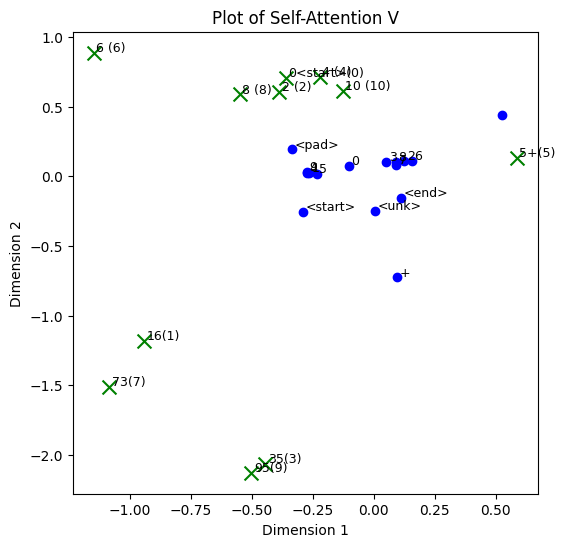

[[[-0.5063024   0.22207226 -0.559135   -0.6580075 ]
  [-0.97077185 -0.5821361  -1.0211583  -0.8090066 ]
  [-0.7115477   0.630432   -0.570662   -0.6301225 ]
  [-0.76526695 -0.42083454 -1.058333   -1.0265466 ]
  [-0.49471012  0.42146218 -0.4751679  -0.5910145 ]
  [-0.12361477 -0.02934173 -0.2614624  -0.4477629 ]
  [-0.934798    0.39686882 -0.82559365 -0.78580856]
  [-0.9914222  -0.9249927  -1.0638295  -0.77628803]
  [-0.7898689   0.6304567  -0.6435056  -0.68065965]
  [-0.7963972  -0.4933493  -1.0636584  -0.99729824]
  [-0.46661177  0.4354171  -0.44503513 -0.5703692 ]]]
(1, 11, 4)
[[-0.5063024   0.22207226]
 [-0.97077185 -0.5821361 ]
 [-0.7115477   0.630432  ]
 [-0.76526695 -0.42083454]
 [-0.49471012  0.42146218]
 [-0.12361477 -0.02934173]
 [-0.934798    0.39686882]
 [-0.9914222  -0.9249927 ]
 [-0.7898689   0.6304567 ]
 [-0.7963972  -0.4933493 ]
 [-0.46661177  0.4354171 ]]


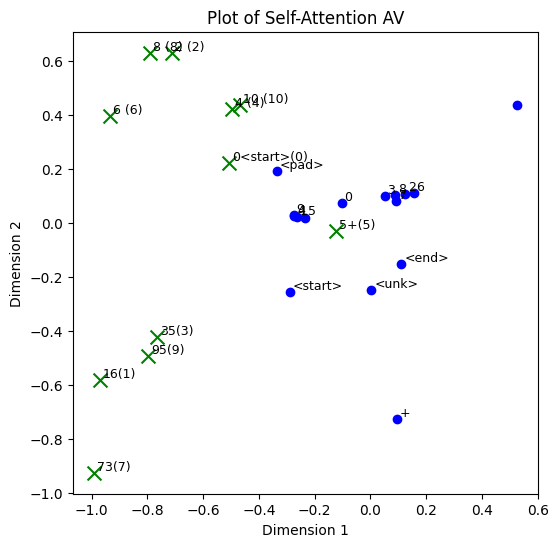

[[[-0.613286    0.5276071   1.0974703   0.05588888]]

 [[-1.1879872   0.03296331  1.5265615   0.8555432 ]]

 [[-0.42759964  0.89222443  1.5150037  -0.49046308]]

 [[-1.3217927   0.35490355  1.3553102   0.9167057 ]]

 [[-0.45440075  0.63871074  1.1286012  -0.2043239 ]]

 [[-0.45454744  0.04460451  0.41249418  0.33164328]]

 [[-0.72120583  0.8680512   1.7964396  -0.2138104 ]]

 [[-1.3095144  -0.29750463  1.431428    1.1977316 ]]

 [[-0.48957604  0.9520099   1.6399338  -0.48566413]]

 [[-1.3271587   0.26747754  1.3663037   0.9625174 ]]

 [[-0.42336747  0.6272149   1.0877309  -0.22304691]]]
(11, 1, 4)
[[-0.613286    0.5276071 ]
 [-1.1879872   0.03296331]
 [-0.42759964  0.89222443]
 [-1.3217927   0.35490355]
 [-0.45440075  0.63871074]
 [-0.45454744  0.04460451]
 [-0.72120583  0.8680512 ]
 [-1.3095144  -0.29750463]
 [-0.48957604  0.9520099 ]
 [-1.3271587   0.26747754]
 [-0.42336747  0.6272149 ]]


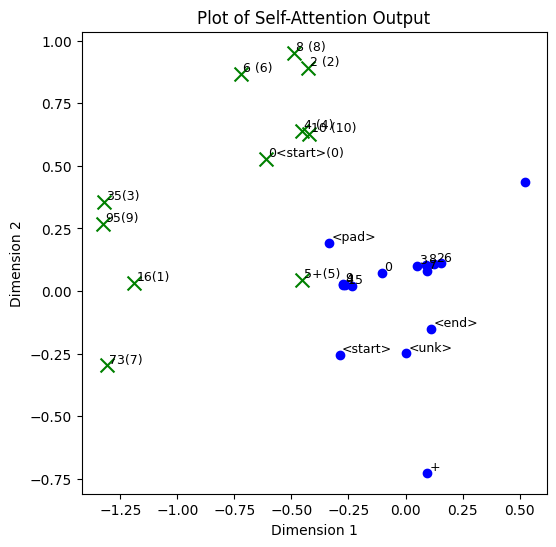

[[[-2.117307    0.64181703  0.25209206  0.501777  ]]

 [[-1.8514054  -0.6767414   1.435297    0.7541173 ]]

 [[ 1.449595    0.38243645 -0.44870943 -1.6370548 ]]

 [[-1.6163199  -0.87232524  0.7858103   1.6981947 ]]

 [[-1.2655301   1.0250365  -0.43938032 -0.01594201]]

 [[-1.4123614  -1.0482723   0.9006252   1.6247234 ]]

 [[-1.0739478   1.082291   -0.01654764 -0.85607994]]

 [[-1.8723427  -0.66137546  1.4171569   0.7743783 ]]

 [[ 1.1335633   0.55220073 -0.33187228 -1.7526109 ]]

 [[-1.5435324  -0.92830944  0.7898542   1.7103401 ]]

 [[-0.7181716   1.0429113  -0.73788023 -0.18134777]]]
(11, 1, 4)
[[-2.117307    0.64181703]
 [-1.8514054  -0.6767414 ]
 [ 1.449595    0.38243645]
 [-1.6163199  -0.87232524]
 [-1.2655301   1.0250365 ]
 [-1.4123614  -1.0482723 ]
 [-1.0739478   1.082291  ]
 [-1.8723427  -0.66137546]
 [ 1.1335633   0.55220073]
 [-1.5435324  -0.92830944]
 [-0.7181716   1.0429113 ]]


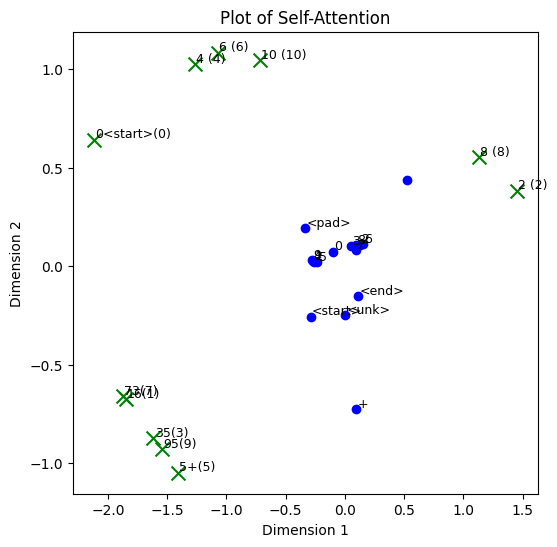

QV.shape: torch.Size([1, 11, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 11, 15])
AV.shape: torch.Size([1, 11, 4])
[[[-1.2695029  -3.9877114   4.121587    1.1792727 ]
  [-0.02803218 -4.077331    4.0158362   2.4170082 ]
  [-0.85077655  2.4803278  -3.2088466  -1.8174412 ]
  [ 1.1523759  -2.9715626   3.8025336   2.4945018 ]
  [-1.4555291  -2.148369    2.2473679  -0.02729318]
  [ 1.3242569  -2.6742704   3.4375703   2.5041792 ]
  [-2.173401   -2.2875535   1.6865039  -0.31905016]
  [-0.03178459 -4.1002917   4.0566306   2.4199035 ]
  [-1.2726052   1.7812982  -2.6617615  -1.7356732 ]
  [ 1.2462461  -2.8326042   3.6782248   2.4932268 ]
  [-1.271295   -0.99696165  1.1397612  -0.5389429 ]]]
(1, 11, 4)
[[-1.2695029  -3.9877114 ]
 [-0.02803218 -4.077331  ]
 [-0.85077655  2.4803278 ]
 [ 1.1523759  -2.9715626 ]
 [-1.4555291  -2.148369  ]
 [ 1.3242569  -2.6742704 ]
 [-2.173401   -2.2875535 ]
 [-0.03178459 -4.1002917 ]
 [-1.2726052   1.7812982

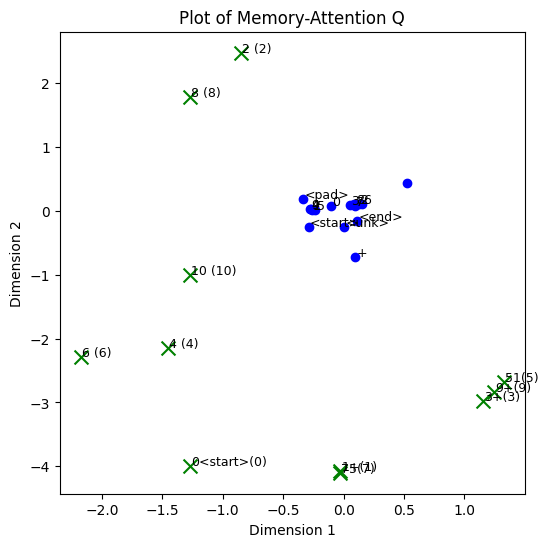

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

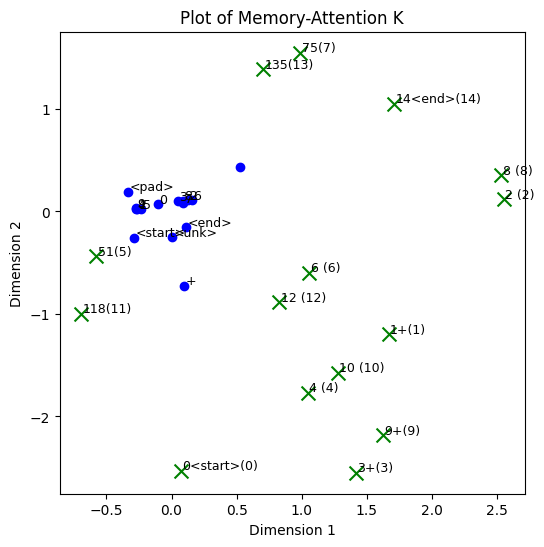

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

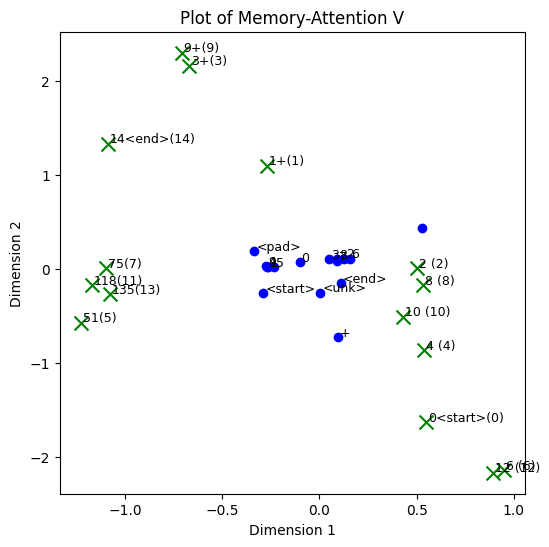

[[-0.58225733  1.863226    2.0901537   0.65197957]
 [-0.6626482   2.1332474   2.3243933   0.6759489 ]
 [-0.837716   -0.14030072  1.0201161   0.16246194]
 [-0.6717417   2.1639836   2.3626103   0.67513067]
 [-0.35605758  0.43735495  0.76921153  0.32424435]
 [-0.6704954   2.1616268   2.3661473   0.67401594]
 [-0.30451313 -0.28631306  0.02162778  0.08520379]
 [-0.6629679   2.1341715   2.324843    0.67607427]
 [-0.77642906 -0.2453991   0.89860296  0.14761873]
 [-0.6715329   2.163894    2.3647726   0.6746961 ]
 [-0.46664494 -0.27962357  0.05170574 -0.01605147]]
(11, 4)
[[-0.58225733  1.863226  ]
 [-0.6626482   2.1332474 ]
 [-0.837716   -0.14030072]
 [-0.6717417   2.1639836 ]
 [-0.35605758  0.43735495]
 [-0.6704954   2.1616268 ]
 [-0.30451313 -0.28631306]
 [-0.6629679   2.1341715 ]
 [-0.77642906 -0.2453991 ]
 [-0.6715329   2.163894  ]
 [-0.46664494 -0.27962357]]


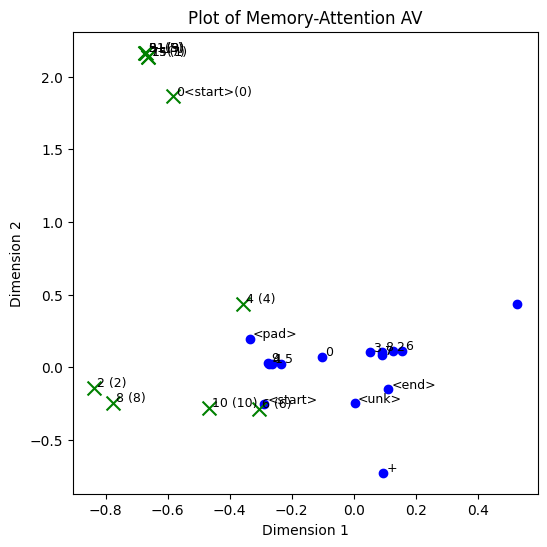

[[[-0.613286    0.5276071   1.0974703   0.05588888]]

 [[-1.1879872   0.03296331  1.5265615   0.8555432 ]]

 [[-0.42759964  0.89222443  1.5150037  -0.49046308]]

 [[-1.3217927   0.35490355  1.3553102   0.9167057 ]]

 [[-0.45440075  0.63871074  1.1286012  -0.2043239 ]]

 [[-0.45454744  0.04460451  0.41249418  0.33164328]]

 [[-0.72120583  0.8680512   1.7964396  -0.2138104 ]]

 [[-1.3095144  -0.29750463  1.431428    1.1977316 ]]

 [[-0.48957604  0.9520099   1.6399338  -0.48566413]]

 [[-1.3271587   0.26747754  1.3663037   0.9625174 ]]

 [[-0.42336747  0.6272149   1.0877309  -0.22304691]]]
(11, 1, 4)
[[-0.613286    0.5276071 ]
 [-1.1879872   0.03296331]
 [-0.42759964  0.89222443]
 [-1.3217927   0.35490355]
 [-0.45440075  0.63871074]
 [-0.45454744  0.04460451]
 [-0.72120583  0.8680512 ]
 [-1.3095144  -0.29750463]
 [-0.48957604  0.9520099 ]
 [-1.3271587   0.26747754]
 [-0.42336747  0.6272149 ]]


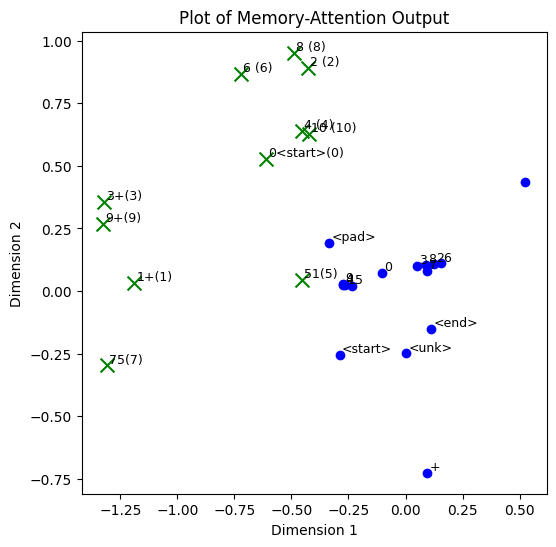

[[[-1.6421285e+00  4.7377929e-01  3.9765748e-01  6.3508481e-01]]

 [[-1.6902666e+00  2.0561562e-01  6.3743389e-01  6.8895787e-01]]

 [[ 1.2676729e-03  3.2336959e-01  1.1103669e+00 -1.2411137e+00]]

 [[-1.6567874e+00  1.4403953e-01  4.7037029e-01  8.4527647e-01]]

 [[-1.5746944e+00  7.3777795e-01  3.5234144e-01  4.0846387e-01]]

 [[-1.6603400e+00  1.1367449e-01  4.9971151e-01  8.4795260e-01]]

 [[-7.1677774e-01  6.4162922e-01  1.1590736e+00 -9.1364807e-01]]

 [[-1.6897022e+00  2.0762794e-01  6.3222903e-01  6.9117188e-01]]

 [[ 2.1227086e-02  2.7311692e-01  1.1413982e+00 -1.2444683e+00]]

 [[-1.6559572e+00  1.3369824e-01  4.7148037e-01  8.5172200e-01]]

 [[-7.0405281e-01  1.0964245e+00  5.6847268e-01 -7.9508936e-01]]]
(11, 1, 4)
[[-1.6421285e+00  4.7377929e-01]
 [-1.6902666e+00  2.0561562e-01]
 [ 1.2676729e-03  3.2336959e-01]
 [-1.6567874e+00  1.4403953e-01]
 [-1.5746944e+00  7.3777795e-01]
 [-1.6603400e+00  1.1367449e-01]
 [-7.1677774e-01  6.4162922e-01]
 [-1.6897022e+00  2.0762794e-01]

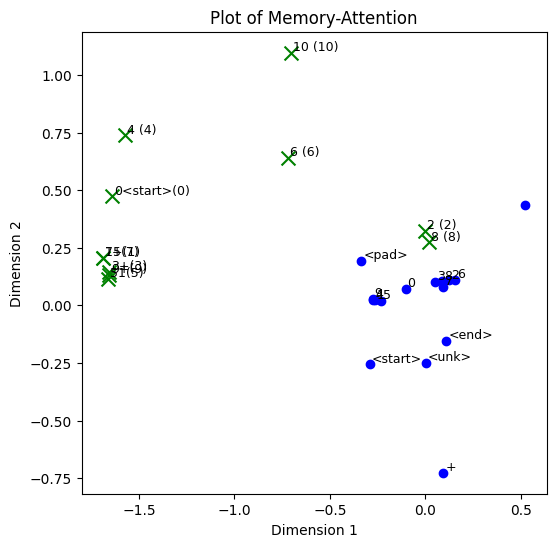

AfterLinear.shape: torch.Size([11, 1, 4])
AfterAddTGT.shape: torch.Size([11, 1, 4])
AfterAddTGT: tensor([[[-0.6889,  4.0218, -4.7982,  1.8866]],

        [[-2.8026,  3.2293, -3.7270,  3.2461]],

        [[-0.8961,  2.7991,  2.9316, -4.2678]],

        [[-2.6493,  2.8888, -3.8011,  3.4711]],

        [[ 0.3925,  4.3213, -4.9357,  0.8890]],

        [[-2.9156,  2.7148, -3.5808,  3.6225]],

        [[-0.1012,  5.8528, -2.8991, -1.8979]],

        [[-2.7736,  3.2393, -3.7485,  3.2346]],

        [[-0.7231,  2.5864,  3.0206, -4.3185]],

        [[-2.7128,  2.8320, -3.7483,  3.5195]],

        [[ 2.0140,  4.5815, -4.2594, -1.2884]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[ -2.6928,   4.1718, -15.0771, -13.6102,   4.1962,   4.8511, -13.3750,  -6.0968, -14.9846,
           4.5002,  -2.3866,  -2.6794,  -1.9430, -14.4919,  15.3980,   2.4972]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
predicted: 14

-----------------

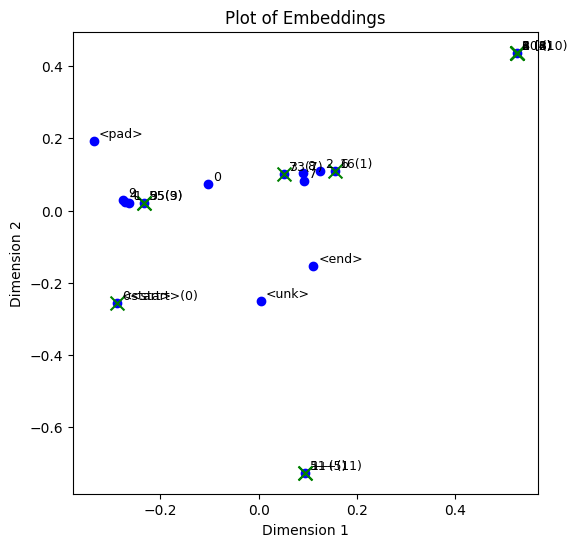

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]

 [[ 0.29346734  0.22062886 -1.1892636   0.41529012]]

 [[-0.768994   -1.168677   -0.41812384  0.06390113]]

 [[ 0.77085435  1.8344427  -1.1692889   0.41429055]]

 [[ 0.7590668   0.956551    1.3100457   0.77085614]]

 [[ 2.039628    0.7287724  -1.1493382   0.4128917 ]]

 [[-0.05408508 -0.87081254  0.71443367  2.6296563 ]]

 [[ 0.5062487   0.03520095 -1.1294196   0.4110942 ]]

 [[-0.8100599  -1.4479135  -0.3583247   0.05910695]]]
(12, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]
 [ 0.29346734  0.22062886]
 [-0.768994   -1.168677  ]
 [ 0.77085435  1.8344427 ]
 [ 0.7590668   0.956551  ]
 [ 2.039628    0.7287724 ]
 [-0.05408508 -0.87081254]
 [ 0.5062487   0.03520095]
 [-0.8100599  -1.4479135 ]]


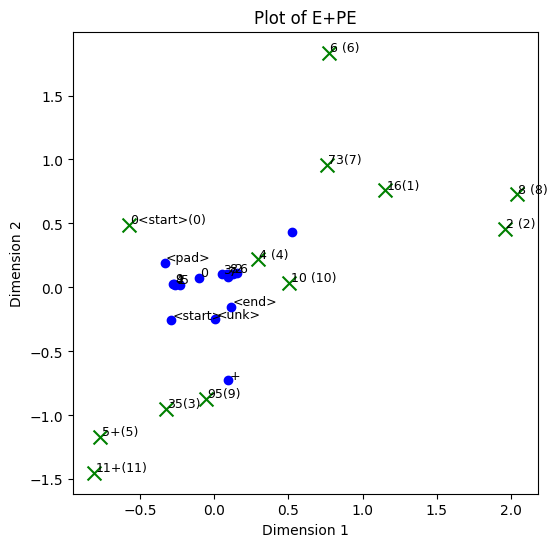

SelfAttention Layer
QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 12, 4])
WV.shape: torch.Size([1, 12, 4])
attn_weight.shape: torch.Size([1, 12, 12])
AV.shape: torch.Size([1, 12, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]
  [ 0.965866    0.07053957  1.4842246  -0.3846688 ]
  [-0.83484656  1.4373012   0.5792201  -0.5744088 ]
  [ 2.4699285  -1.335511    1.4578295   0.2476317 ]
  [ 0.26438832 -2.173289    0.09268427  1.0571992 ]
  [ 2.1719797  -1.2294121   2.203474   -0.70533437]
  [-2.371125   -1.2616495   0.9559436   1.2083375 ]
  [ 0.8889238   0.06215561  1.571501   -0.5230212 ]
  [-1.1054897   1.6296978   0.560847   -0.6739373 ]]]
(1, 12, 4)
[[ 0.7114342   0.2834468 ]
 [ 0.505927   -2.0341296 ]
 [ 1.9474189  -0.9667186 ]
 [-2.532358   -1.0347031 ]
 [ 0.965866    0.07053957]
 [-0.83484656  1.4373012 ]
 [ 2.4

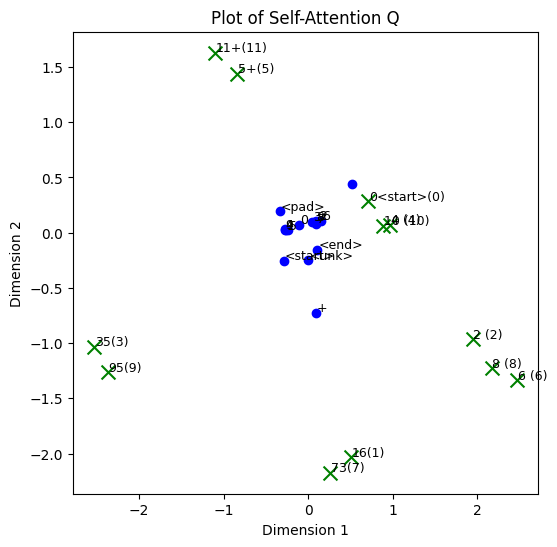

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]
  [ 0.33235416  0.45209563  0.41340655 -0.4876575 ]
  [ 0.3828183   1.4692954  -0.64528066 -1.9975775 ]
  [ 0.95665556 -1.2246394   1.414116    1.4234873 ]
  [ 0.03392431 -2.040095   -0.02586579  2.6158478 ]
  [-0.9441848  -0.3112424   0.8461021   1.504194  ]
  [-0.7582805   0.18767633 -1.574228   -0.4617222 ]
  [ 0.00811601  0.5674353   0.30112606 -0.4269424 ]
  [ 0.23054767  1.7115372  -0.8339966  -2.2399285 ]]]
(1, 12, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]
 [ 0.33235416  0.45209563]
 [ 0.3828183   1.4692954 ]
 [ 0.95665556 -1.2246394 ]
 [ 0.03392431 -2.040095  ]
 [-0.9441848  -0.3112424 ]
 [-0.7582805   0.18767633]
 [ 0.00811601  0.5674353 ]
 [ 0.23054767  1.7115372 ]]


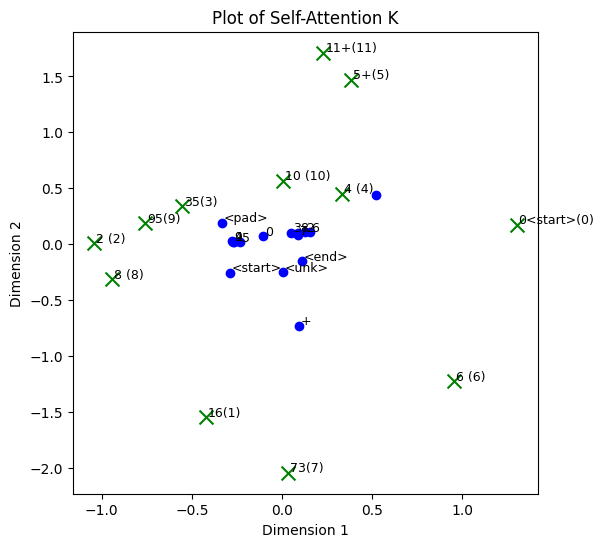

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]
  [-0.22209424  0.71188325 -0.25376043 -0.5252558 ]
  [ 0.5861341   0.13321787  0.69309384  0.43203232]
  [-1.1467686   0.8873743  -0.9800878  -0.97567254]
  [-1.0836861  -1.5115368  -1.0895604  -0.61330616]
  [-0.54917705  0.58775806 -1.089325   -1.4237993 ]
  [-0.5017034  -2.127848   -0.92400056 -0.79294485]
  [-0.12820074  0.6159197  -0.27609378 -0.5903069 ]
  [ 0.73836803  0.04797788  0.79878056  0.50163907]]]
(1, 12, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]
 [-0.22209424  0.71188325]
 [ 0.5861341   0.13321787]
 [-1.1467686   0.8873743 ]
 [-1.0836861  -1.5115368 ]
 [-0.54917705  0.58775806]
 [-0.5017034  -2.127848  ]
 [-0.12820074  0.6159197 ]
 [ 0.73836803  0.04797788]]


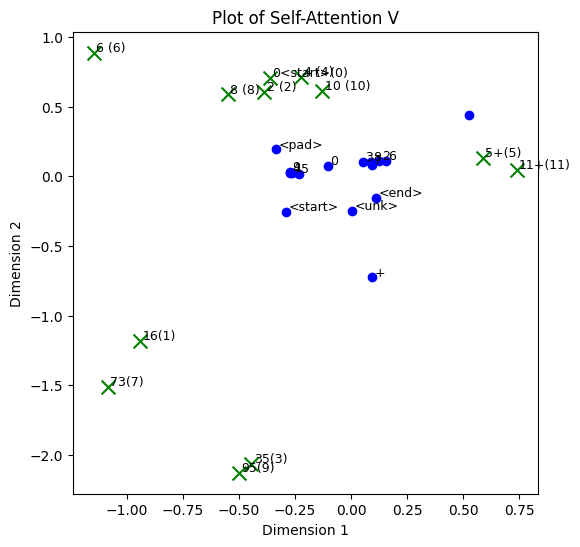

[[[-0.42386687  0.21054183 -0.4691991  -0.58120316]
  [-0.96834135 -0.58124006 -1.0185703  -0.8071427 ]
  [-0.68299025  0.6189601  -0.5436896  -0.60783136]
  [-0.76392096 -0.42041487 -1.0566707  -1.0251788 ]
  [-0.41380644  0.3969575  -0.39158276 -0.51932424]
  [ 0.09919386 -0.00935591  0.01259327 -0.20235781]
  [-0.9278987   0.39543018 -0.8188956  -0.78049976]
  [-0.990269   -0.92434394 -1.0625877  -0.7754361 ]
  [-0.77166307  0.62351763 -0.6263236  -0.66657495]
  [-0.7953187  -0.4929689  -1.0623496  -0.9962449 ]
  [-0.3790954   0.40727782 -0.35469815 -0.49251044]
  [ 0.15319036 -0.03679281  0.07085493 -0.1493911 ]]]
(1, 12, 4)
[[-0.42386687  0.21054183]
 [-0.96834135 -0.58124006]
 [-0.68299025  0.6189601 ]
 [-0.76392096 -0.42041487]
 [-0.41380644  0.3969575 ]
 [ 0.09919386 -0.00935591]
 [-0.9278987   0.39543018]
 [-0.990269   -0.92434394]
 [-0.77166307  0.62351763]
 [-0.7953187  -0.4929689 ]
 [-0.3790954   0.40727782]
 [ 0.15319036 -0.03679281]]


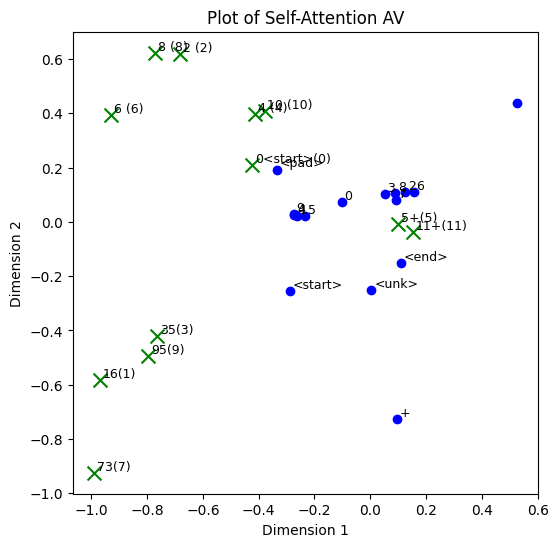

[[[-0.5297609   0.4328005   0.95547414  0.04671829]]

 [[-1.1853765   0.03163108  1.5229023   0.8542091 ]]

 [[-0.40641797  0.8568492   1.4645529  -0.4824294 ]]

 [[-1.3200296   0.3537769   1.3531604   0.9158113 ]]

 [[-0.3820818   0.5375017   0.9858912  -0.19633584]]

 [[-0.16959932 -0.20055544  0.03537127  0.2245744 ]]

 [[-0.71556056  0.8607447   1.7847166  -0.21326919]]

 [[-1.3082094  -0.29790887  1.4297764   1.196878  ]]

 [[-0.476026    0.929901    1.6079304  -0.48086214]]

 [[-1.3257709   0.26665446  1.3646083   0.9617829 ]]

 [[-0.3455672   0.5160155   0.9327251  -0.21284463]]

 [[-0.12049685 -0.28306434 -0.06515561  0.23828506]]]
(12, 1, 4)
[[-0.5297609   0.4328005 ]
 [-1.1853765   0.03163108]
 [-0.40641797  0.8568492 ]
 [-1.3200296   0.3537769 ]
 [-0.3820818   0.5375017 ]
 [-0.16959932 -0.20055544]
 [-0.71556056  0.8607447 ]
 [-1.3082094  -0.29790887]
 [-0.476026    0.929901  ]
 [-1.3257709   0.26665446]
 [-0.3455672   0.5160155 ]
 [-0.12049685 -0.28306434]]


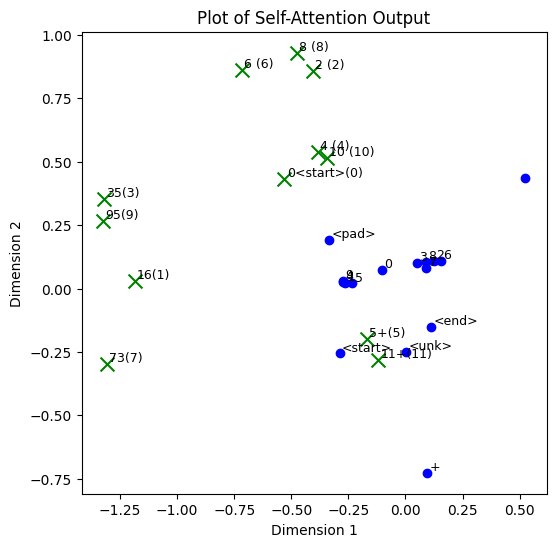

[[[-2.064888    0.6585229   0.12171022  0.5976477 ]]

 [[-1.850416   -0.67797554  1.4351372   0.75531715]]

 [[ 1.50663     0.3517389  -0.49504083 -1.5825179 ]]

 [[-1.6155236  -0.87279195  0.785333    1.6987909 ]]

 [[-0.946843    0.9829718  -0.75069296  0.1537298 ]]

 [[-0.7431305  -1.3189013   0.5692004   1.8406032 ]]

 [[-1.0664105   1.0837876  -0.02517008 -0.85433316]]

 [[-1.872083   -0.66167307  1.4171786   0.77456677]]

 [[ 1.1736635   0.5370538  -0.36220142 -1.7274368 ]]

 [[-1.5428613  -0.9286817   0.7894628   1.7107947 ]]

 [[-0.10990921  0.8456335  -1.1498891   0.08520772]]

 [[-0.4403345  -1.4503624   0.5878009   1.7282873 ]]]
(12, 1, 4)
[[-2.064888    0.6585229 ]
 [-1.850416   -0.67797554]
 [ 1.50663     0.3517389 ]
 [-1.6155236  -0.87279195]
 [-0.946843    0.9829718 ]
 [-0.7431305  -1.3189013 ]
 [-1.0664105   1.0837876 ]
 [-1.872083   -0.66167307]
 [ 1.1736635   0.5370538 ]
 [-1.5428613  -0.9286817 ]
 [-0.10990921  0.8456335 ]
 [-0.4403345  -1.4503624 ]]


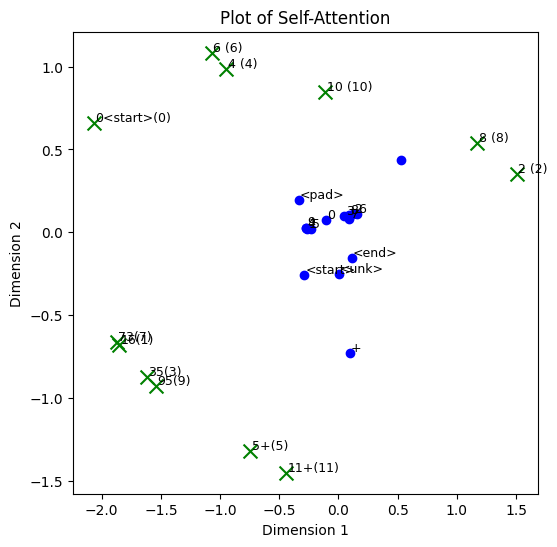

QV.shape: torch.Size([1, 12, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 12, 15])
AV.shape: torch.Size([1, 12, 4])
[[[-1.1541108  -3.7850065   4.0341268   1.1218207 ]
  [-0.02546679 -4.0749984   4.0144877   2.4175873 ]
  [-0.74230164  2.6312685  -3.3007107  -1.8297002 ]
  [ 1.1537559  -2.9696028   3.801228    2.4943607 ]
  [-1.0602041  -1.317303    1.671027   -0.24817309]
  [ 2.1341138  -1.1553746   2.2487805   2.2310393 ]
  [-2.1677883  -2.2678895   1.6717273  -0.32718286]
  [-0.03124904 -4.0997543   4.056244    2.4200172 ]
  [-1.21301     1.8820511  -2.730797   -1.7523338 ]
  [ 1.2473497  -2.8309734   3.6771088   2.493081  ]
  [-0.49829942  0.46821147  0.06020943 -0.83576953]
  [ 2.304762   -0.6289913   1.670654    2.1022239 ]]]
(1, 12, 4)
[[-1.1541108  -3.7850065 ]
 [-0.02546679 -4.0749984 ]
 [-0.74230164  2.6312685 ]
 [ 1.1537559  -2.9696028 ]
 [-1.0602041  -1.317303  ]
 [ 2.1341138  -1.1553746 ]
 [-2.1677883  -2.2678895 ]

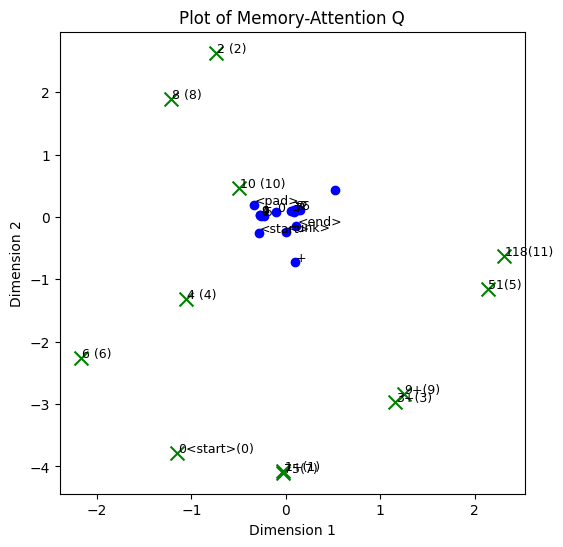

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

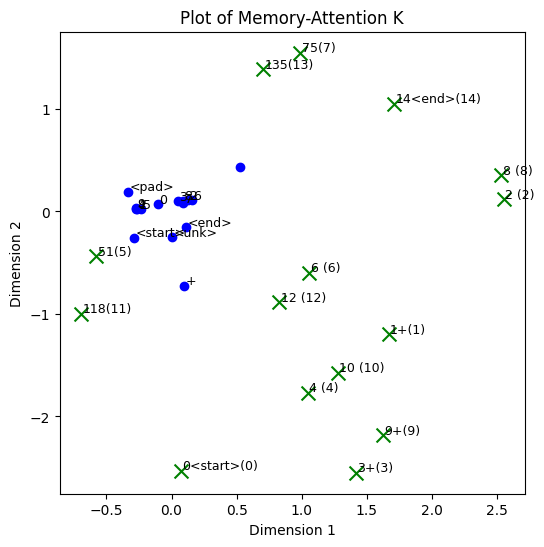

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

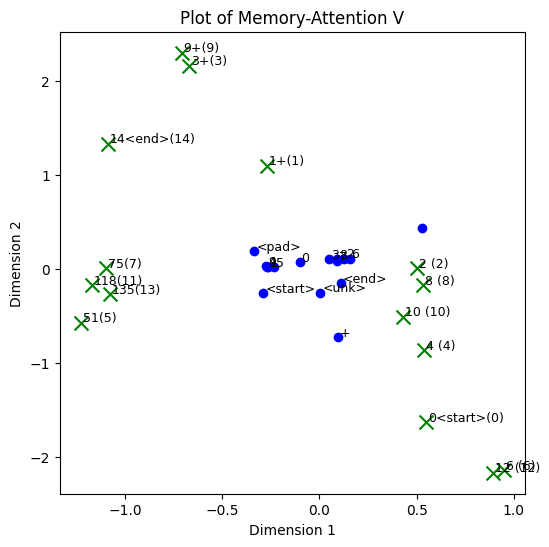

[[-0.58138335  1.8572466   2.0866106   0.650029  ]
 [-0.6626751   2.133337    2.3244956   0.6759491 ]
 [-0.84634185 -0.12213995  1.0402448   0.16463512]
 [-0.6717409   2.1639879   2.3626423   0.6751252 ]
 [-0.4055122   0.14841333  0.4962166   0.18477605]
 [-0.645686    2.1026328   2.3630583   0.66635346]
 [-0.30811906 -0.2923672   0.01357792  0.07961159]
 [-0.66297257  2.1341875   2.3248627   0.67607397]
 [-0.789161   -0.22661102  0.92022204  0.15014441]
 [-0.6715308   2.1638937   2.3647974   0.67469126]
 [-0.54648656 -0.33540562  0.55882263  0.08423108]
 [-0.60039055  1.9921228   2.3296728   0.6619645 ]]
(12, 4)
[[-0.58138335  1.8572466 ]
 [-0.6626751   2.133337  ]
 [-0.84634185 -0.12213995]
 [-0.6717409   2.1639879 ]
 [-0.4055122   0.14841333]
 [-0.645686    2.1026328 ]
 [-0.30811906 -0.2923672 ]
 [-0.66297257  2.1341875 ]
 [-0.789161   -0.22661102]
 [-0.6715308   2.1638937 ]
 [-0.54648656 -0.33540562]
 [-0.60039055  1.9921228 ]]


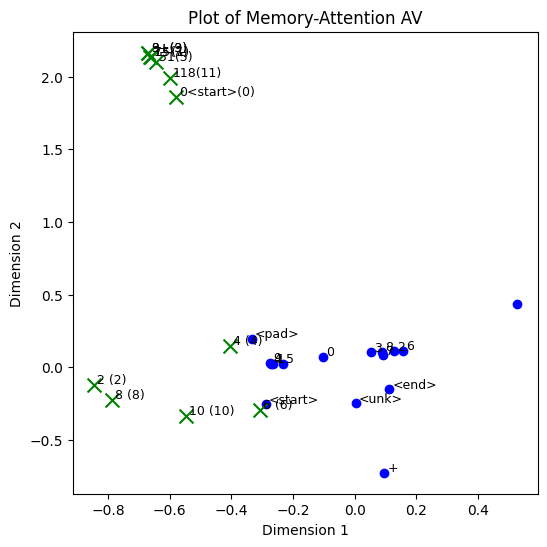

[[[-0.5297609   0.4328005   0.95547414  0.04671829]]

 [[-1.1853765   0.03163108  1.5229023   0.8542091 ]]

 [[-0.40641797  0.8568492   1.4645529  -0.4824294 ]]

 [[-1.3200296   0.3537769   1.3531604   0.9158113 ]]

 [[-0.3820818   0.5375017   0.9858912  -0.19633584]]

 [[-0.16959932 -0.20055544  0.03537127  0.2245744 ]]

 [[-0.71556056  0.8607447   1.7847166  -0.21326919]]

 [[-1.3082094  -0.29790887  1.4297764   1.196878  ]]

 [[-0.476026    0.929901    1.6079304  -0.48086214]]

 [[-1.3257709   0.26665446  1.3646083   0.9617829 ]]

 [[-0.3455672   0.5160155   0.9327251  -0.21284463]]

 [[-0.12049685 -0.28306434 -0.06515561  0.23828506]]]
(12, 1, 4)
[[-0.5297609   0.4328005 ]
 [-1.1853765   0.03163108]
 [-0.40641797  0.8568492 ]
 [-1.3200296   0.3537769 ]
 [-0.3820818   0.5375017 ]
 [-0.16959932 -0.20055544]
 [-0.71556056  0.8607447 ]
 [-1.3082094  -0.29790887]
 [-0.476026    0.929901  ]
 [-1.3257709   0.26665446]
 [-0.3455672   0.5160155 ]
 [-0.12049685 -0.28306434]]


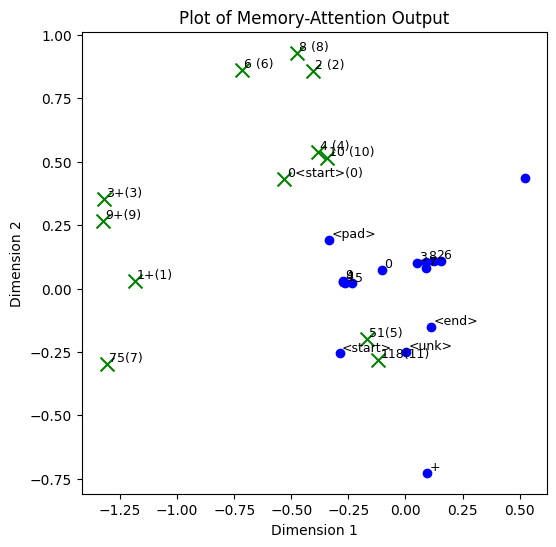

[[[-1.6354275e+00  4.7707194e-01  3.6604050e-01  6.5269530e-01]]

 [[-1.6902562e+00  2.0535398e-01  6.3738179e-01  6.8919575e-01]]

 [[-6.3129800e-04  3.4395733e-01  1.0928584e+00 -1.2411901e+00]]

 [[-1.6567504e+00  1.4394470e-01  4.7025624e-01  8.4541219e-01]]

 [[-1.5014367e+00  8.7140447e-01  2.3438044e-01  3.3812550e-01]]

 [[-1.6327976e+00  5.1906697e-02  4.2629996e-01  9.3271953e-01]]

 [[-6.9224715e-01  6.3625735e-01  1.1579864e+00 -9.2959964e-01]]

 [[-1.6897017e+00  2.0756833e-01  6.3223350e-01  6.9121408e-01]]

 [[ 5.5902875e-03  2.9733235e-01  1.1307962e+00 -1.2412585e+00]]

 [[-1.6559267e+00  1.3362314e-01  4.7138751e-01  8.5183072e-01]]

 [[-1.1180280e+00  1.2118968e+00  2.3735534e-01 -2.5870273e-01]]

 [[-1.6295660e+00  3.8951621e-03  4.4479984e-01  9.5223486e-01]]]
(12, 1, 4)
[[-1.6354275e+00  4.7707194e-01]
 [-1.6902562e+00  2.0535398e-01]
 [-6.3129800e-04  3.4395733e-01]
 [-1.6567504e+00  1.4394470e-01]
 [-1.5014367e+00  8.7140447e-01]
 [-1.6327976e+00  5.1906697e-02]

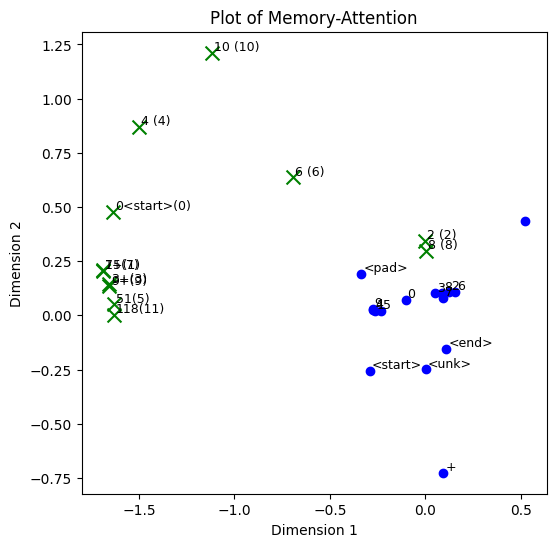

AfterLinear.shape: torch.Size([12, 1, 4])
AfterAddTGT.shape: torch.Size([12, 1, 4])
AfterAddTGT: tensor([[[-0.6111,  4.0029, -4.8274,  1.8663]],

        [[-2.8040,  3.2279, -3.7259,  3.2473]],

        [[-0.4075,  3.2952,  2.2808, -4.4570]],

        [[-2.6495,  2.8883, -3.8009,  3.4715]],

        [[ 0.9030,  4.3002, -4.9542,  0.5075]],

        [[-3.0359,  2.3562, -3.4148,  3.8579]],

        [[-0.0813,  5.8542, -2.8167, -1.9934]],

        [[-2.7740,  3.2390, -3.7482,  3.2349]],

        [[-0.9307,  2.6608,  3.0529, -4.2409]],

        [[-2.7129,  2.8316, -3.7481,  3.5198]],

        [[ 1.8131,  4.3617, -4.6912, -0.5346]],

        [[-3.3459,  2.0372, -3.0739,  4.0496]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  1.8551, -16.7313, -14.8950,  -8.0134, -15.6305, -10.8416, -12.9637,  -5.7040, -13.2949,
         -10.5472,  -0.6796,  -1.9024,  -1.8494,   3.6550,  -0.1437,  13.6027]], device='cuda:0',
       grad_fn=<

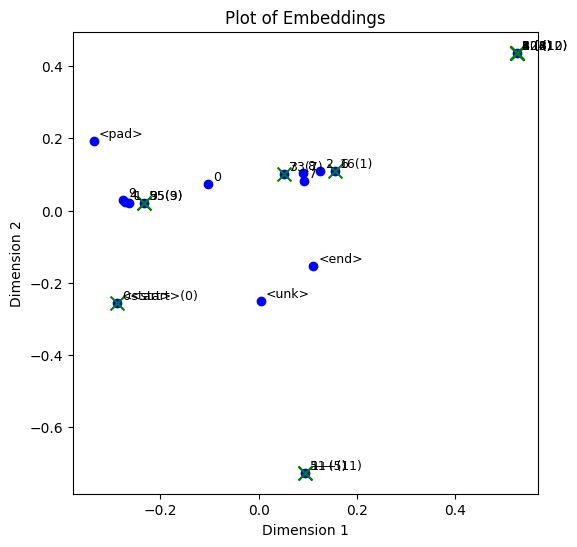

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]

 [[ 0.29346734  0.22062886 -1.1892636   0.41529012]]

 [[-0.768994   -1.168677   -0.41812384  0.06390113]]

 [[ 0.77085435  1.8344427  -1.1692889   0.41429055]]

 [[ 0.7590668   0.956551    1.3100457   0.77085614]]

 [[ 2.039628    0.7287724  -1.1493382   0.4128917 ]]

 [[-0.05408508 -0.87081254  0.71443367  2.6296563 ]]

 [[ 0.5062487   0.03520095 -1.1294196   0.4110942 ]]

 [[-0.8100599  -1.4479135  -0.3583247   0.05910695]]

 [[ 0.5136969   1.7181264  -1.1095407   0.40889865]]]
(13, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]
 [ 0.29346734  0.22062886]
 [-0.768994   -1.168677  ]
 [ 0.77085435  1.8344427 ]
 [ 0.7590668   0.956551  ]
 [ 2.039628    0.7287724 ]
 [-0.05408508 -0.87081254]
 [ 0.5062487   0.

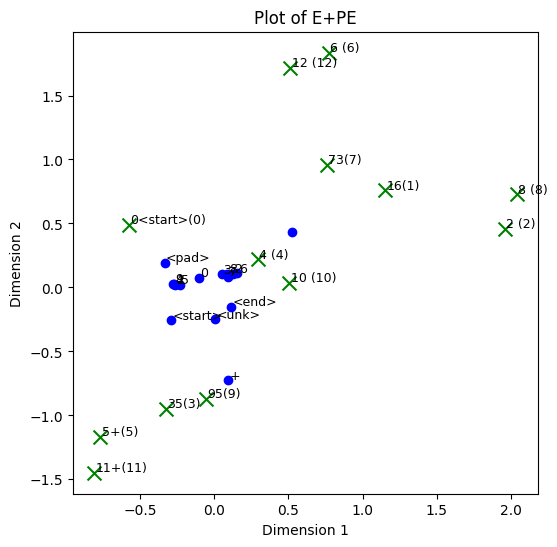

SelfAttention Layer
QV.shape: torch.Size([1, 13, 4])
KV.shape: torch.Size([1, 13, 4])
WV.shape: torch.Size([1, 13, 4])
attn_weight.shape: torch.Size([1, 13, 13])
AV.shape: torch.Size([1, 13, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]
  [ 0.965866    0.07053957  1.4842246  -0.3846688 ]
  [-0.83484656  1.4373012   0.5792201  -0.5744088 ]
  [ 2.4699285  -1.335511    1.4578295   0.2476317 ]
  [ 0.26438832 -2.173289    0.09268427  1.0571992 ]
  [ 2.1719797  -1.2294121   2.203474   -0.70533437]
  [-2.371125   -1.2616495   0.9559436   1.2083375 ]
  [ 0.8889238   0.06215561  1.571501   -0.5230212 ]
  [-1.1054897   1.6296978   0.560847   -0.6739373 ]
  [ 2.2284944  -1.1443617   1.3137699   0.29901758]]]
(1, 13, 4)
[[ 0.7114342   0.2834468 ]
 [ 0.505927   -2.0341296 ]
 [ 1.9474189  -0.9667186 ]
 [-2.532358   -1.0347031 ]
 [ 0.965

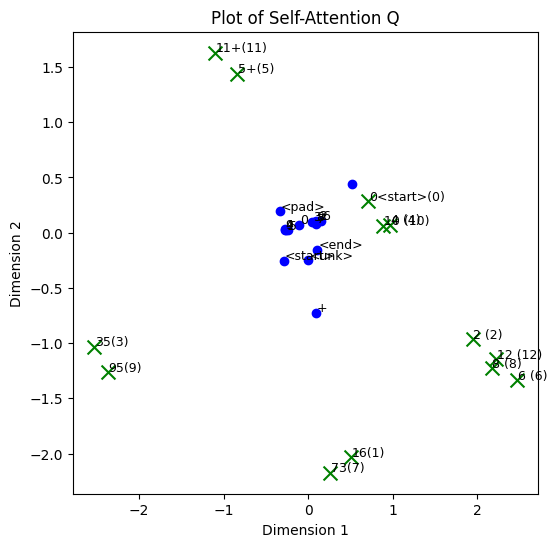

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]
  [ 0.33235416  0.45209563  0.41340655 -0.4876575 ]
  [ 0.3828183   1.4692954  -0.64528066 -1.9975775 ]
  [ 0.95665556 -1.2246394   1.414116    1.4234873 ]
  [ 0.03392431 -2.040095   -0.02586579  2.6158478 ]
  [-0.9441848  -0.3112424   0.8461021   1.504194  ]
  [-0.7582805   0.18767633 -1.574228   -0.4617222 ]
  [ 0.00811601  0.5674353   0.30112606 -0.4269424 ]
  [ 0.23054767  1.7115372  -0.8339966  -2.2399285 ]
  [ 1.1111606  -1.115005    1.30608     1.1468548 ]]]
(1, 13, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]
 [ 0.33235416  0.45209563]
 [ 0.3828183   1.4692954 ]
 [ 0.95665556 -1.2246394 ]
 [ 0.03392431 -2.040095  ]
 [-0.9441848  -0.3112424 ]
 [-0.7582805   0.18767633]
 [ 0.00811601  0.5674353 ]
 [ 0.23054767 

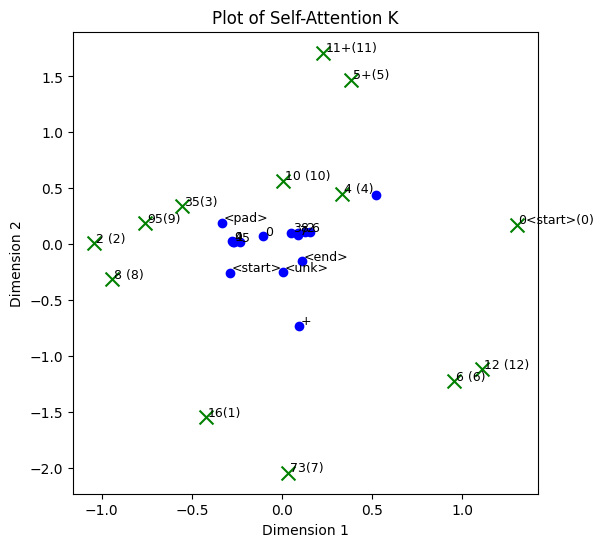

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]
  [-0.22209424  0.71188325 -0.25376043 -0.5252558 ]
  [ 0.5861341   0.13321787  0.69309384  0.43203232]
  [-1.1467686   0.8873743  -0.9800878  -0.97567254]
  [-1.0836861  -1.5115368  -1.0895604  -0.61330616]
  [-0.54917705  0.58775806 -1.089325   -1.4237993 ]
  [-0.5017034  -2.127848   -0.92400056 -0.79294485]
  [-0.12820074  0.6159197  -0.27609378 -0.5903069 ]
  [ 0.73836803  0.04797788  0.79878056  0.50163907]
  [-1.0821503   0.8470211  -0.8472106  -0.8253559 ]]]
(1, 13, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]
 [-0.22209424  0.71188325]
 [ 0.5861341   0.13321787]
 [-1.1467686   0.8873743 ]
 [-1.0836861  -1.5115368 ]
 [-0.54917705  0.58775806]
 [-0.5017034  -2.127848  ]
 [-0.12820074  0.6159197 ]
 [ 0.73836803 

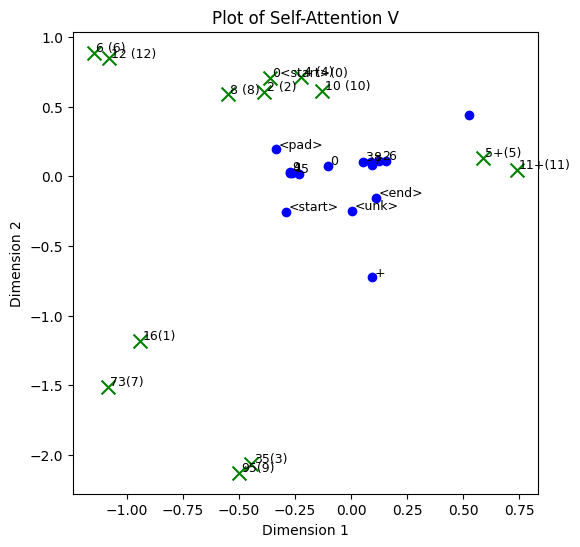

[[[-0.52406603  0.30742222 -0.52673733 -0.61836636]
  [-0.9873824  -0.34228253 -0.9899007  -0.8101899 ]
  [-0.81433696  0.69400537 -0.64356554 -0.6794095 ]
  [-0.7721081  -0.38780743 -1.0512819  -1.0200379 ]
  [-0.53959966  0.4816668  -0.4773393  -0.5769244 ]
  [ 0.08002417  0.00454054 -0.00135878 -0.21246722]
  [-0.98480606  0.5620334  -0.82934177 -0.7970484 ]
  [-0.9991422  -0.75327754 -1.041788   -0.7802569 ]
  [-0.88361466  0.70410573 -0.70596826 -0.72382617]
  [-0.80412334 -0.4518365  -1.0557457  -0.99099934]
  [-0.5049617   0.48600405 -0.44287154 -0.552099  ]
  [ 0.14046459 -0.02768826  0.06139753 -0.15635447]
  [-0.96113193  0.5112704  -0.81999373 -0.7877407 ]]]
(1, 13, 4)
[[-0.52406603  0.30742222]
 [-0.9873824  -0.34228253]
 [-0.81433696  0.69400537]
 [-0.7721081  -0.38780743]
 [-0.53959966  0.4816668 ]
 [ 0.08002417  0.00454054]
 [-0.98480606  0.5620334 ]
 [-0.9991422  -0.75327754]
 [-0.88361466  0.70410573]
 [-0.80412334 -0.4518365 ]
 [-0.5049617   0.48600405]
 [ 0.14046459 

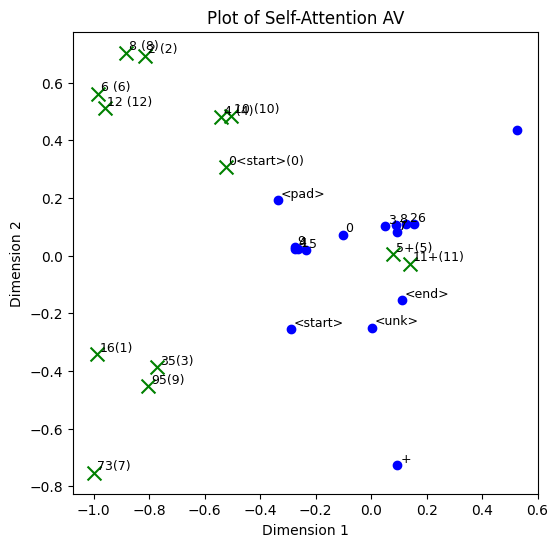

[[[-0.53702724  0.56837344  1.1396718  -0.07227616]]

 [[-1.0836746   0.24776599  1.6304309   0.58831644]]

 [[-0.4627134   1.0103977   1.6952398  -0.5655544 ]]

 [[-1.3009266   0.37872455  1.3740621   0.8733396 ]]

 [[-0.41886243  0.68543565  1.2079327  -0.29772964]]

 [[-0.17621832 -0.17582488  0.06993864  0.20900264]]

 [[-0.66462624  1.0314596   1.9252367  -0.4057653 ]]

 [[-1.2376422  -0.14132616  1.5008376   1.0103059 ]]

 [[-0.5126138   1.0718129   1.8090103  -0.57251227]]

 [[-1.3028018   0.2990949   1.3891959   0.909697  ]]

 [[-0.38708937  0.6605741   1.153445   -0.30633292]]

 [[-0.12520461 -0.26651463 -0.04217561  0.22825836]]

 [[-0.67484426  0.9743712   1.8722463  -0.34764242]]]
(13, 1, 4)
[[-0.53702724  0.56837344]
 [-1.0836746   0.24776599]
 [-0.4627134   1.0103977 ]
 [-1.3009266   0.37872455]
 [-0.41886243  0.68543565]
 [-0.17621832 -0.17582488]
 [-0.66462624  1.0314596 ]
 [-1.2376422  -0.14132616]
 [-0.5126138   1.0718129 ]
 [-1.3028018   0.2990949 ]
 [-0.38708937  0.

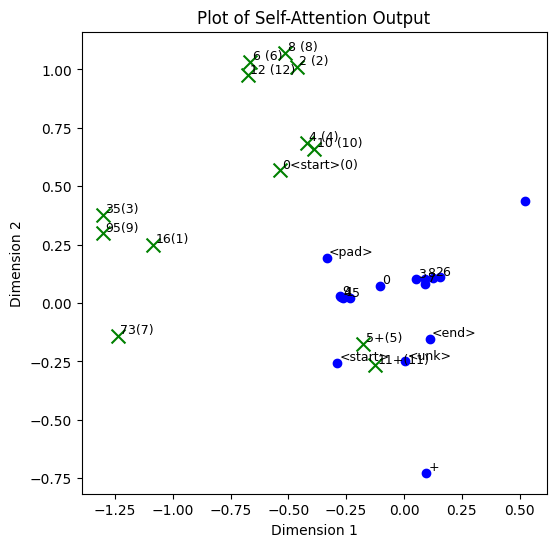

[[[-2.0741014   0.70978     0.2959912   0.29367605]]

 [[-1.8580607  -0.5284152   1.5822753   0.33040175]]

 [[ 1.260226    0.45095432 -0.24723403 -1.82867   ]]

 [[-1.6231978  -0.87087476  0.7983821   1.6858872 ]]

 [[-1.1962821   1.077157   -0.2837024  -0.37311393]]

 [[-0.78818834 -1.3131459   0.6144161   1.8153208 ]]

 [[-0.9745847   1.0658141   0.0775722  -1.0522199 ]]

 [[-1.8900981  -0.5873606   1.493273    0.57334256]]

 [[ 0.96035755  0.58995336 -0.14741988 -1.8886806 ]]

 [[-1.5524607  -0.9264656   0.80561215  1.6951725 ]]

 [[-0.5991737   1.0974778  -0.54117656 -0.645532  ]]

 [[-0.46381596 -1.449046    0.6132939   1.7152076 ]]

 [[-1.201874    1.0437424   0.16216703 -0.9079972 ]]]
(13, 1, 4)
[[-2.0741014   0.70978   ]
 [-1.8580607  -0.5284152 ]
 [ 1.260226    0.45095432]
 [-1.6231978  -0.87087476]
 [-1.1962821   1.077157  ]
 [-0.78818834 -1.3131459 ]
 [-0.9745847   1.0658141 ]
 [-1.8900981  -0.5873606 ]
 [ 0.96035755  0.58995336]
 [-1.5524607  -0.9264656 ]
 [-0.5991737   1.

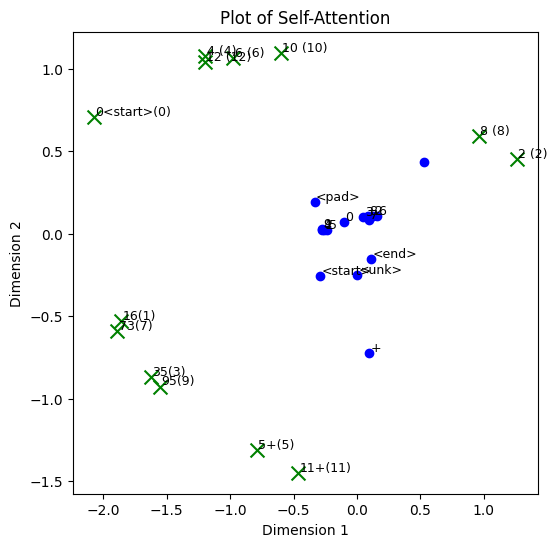

QV.shape: torch.Size([1, 13, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 13, 15])
AV.shape: torch.Size([1, 13, 4])
[[[-1.4838151  -3.9957457   3.976186    1.0514787 ]
  [-0.5318546  -4.305036    3.9018664   2.2288318 ]
  [-1.2000875   1.9488975  -2.896808   -1.7406974 ]
  [ 1.1352103  -2.9955058   3.813064    2.4980466 ]
  [-1.7860461  -2.2169392   2.025122   -0.17123568]
  [ 2.0771005  -1.2739583   2.3300567   2.262387  ]
  [-2.2869227  -2.214256    1.4570539  -0.40219823]
  [-0.28255582 -4.2395134   4.030067    2.3394127 ]
  [-1.538873    1.3073254  -2.3615355  -1.6351975 ]
  [ 1.2247635  -2.8631144   3.6920695   2.4979298 ]
  [-1.673811   -1.0281181   0.7979018  -0.7369365 ]
  [ 2.2761981  -0.6918532   1.7134924   2.1204214 ]
  [-2.2817743  -2.6465693   1.9363806  -0.16814253]]]
(1, 13, 4)
[[-1.4838151  -3.9957457 ]
 [-0.5318546  -4.305036  ]
 [-1.2000875   1.9488975 ]
 [ 1.1352103  -2.9955058 ]
 [-1.7860461  -2.2169392 ]
 

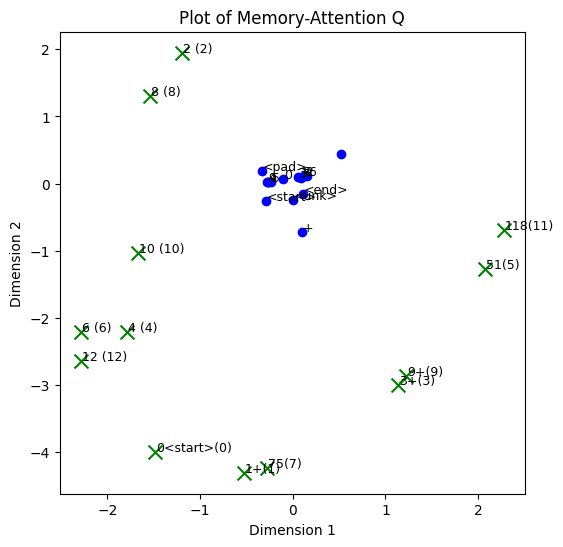

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

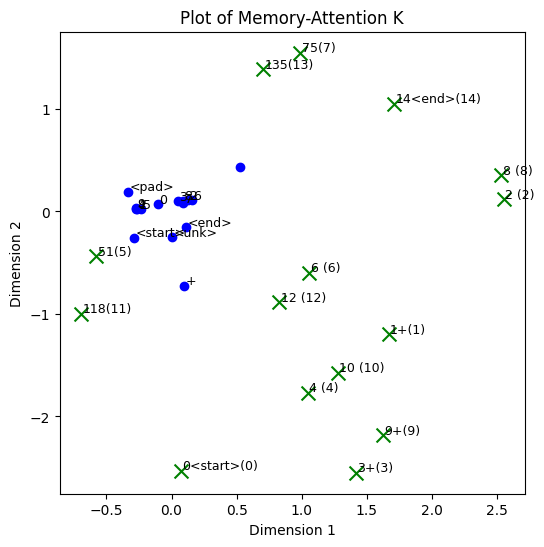

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

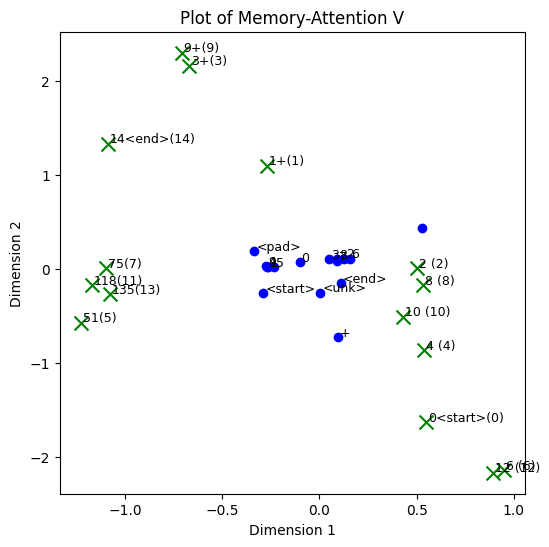

[[-0.5502444   1.7519227   1.99337     0.64055645]
 [-0.6504051   2.0944285   2.2895238   0.67379814]
 [-0.784546   -0.22129394  0.93675244  0.15633917]
 [-0.6717351   2.1638916   2.3622127   0.6751913 ]
 [-0.32347214  0.07497574  0.4003621   0.2135047 ]
 [-0.6500347   2.1132665   2.365646    0.66716003]
 [-0.3211772  -0.41617    -0.12594531  0.01615241]
 [-0.65828806  2.1192768   2.3109503   0.6753867 ]
 [-0.6999911  -0.35253882  0.7663487   0.12871408]
 [-0.6715451   2.1638305   2.3642871   0.6747786 ]
 [-0.5233812  -0.48184615 -0.20958875 -0.14936876]
 [-0.60688746  2.007714    2.3337154   0.6623865 ]
 [-0.24593742 -0.16920283  0.1734317   0.1846914 ]]
(13, 4)
[[-0.5502444   1.7519227 ]
 [-0.6504051   2.0944285 ]
 [-0.784546   -0.22129394]
 [-0.6717351   2.1638916 ]
 [-0.32347214  0.07497574]
 [-0.6500347   2.1132665 ]
 [-0.3211772  -0.41617   ]
 [-0.65828806  2.1192768 ]
 [-0.6999911  -0.35253882]
 [-0.6715451   2.1638305 ]
 [-0.5233812  -0.48184615]
 [-0.60688746  2.007714  ]
 [-0

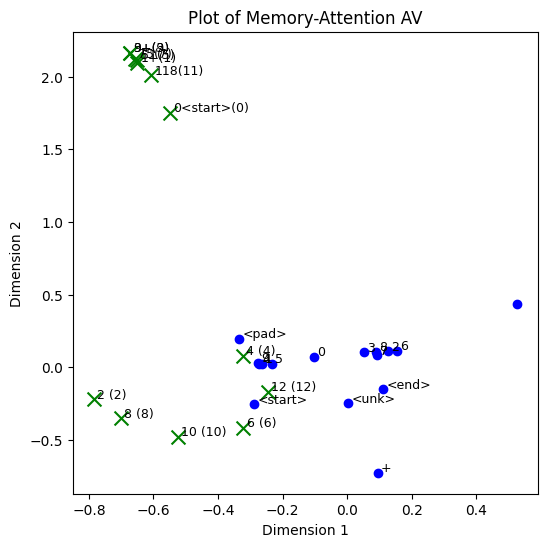

[[[-0.53702724  0.56837344  1.1396718  -0.07227616]]

 [[-1.0836746   0.24776599  1.6304309   0.58831644]]

 [[-0.4627134   1.0103977   1.6952398  -0.5655544 ]]

 [[-1.3009266   0.37872455  1.3740621   0.8733396 ]]

 [[-0.41886243  0.68543565  1.2079327  -0.29772964]]

 [[-0.17621832 -0.17582488  0.06993864  0.20900264]]

 [[-0.66462624  1.0314596   1.9252367  -0.4057653 ]]

 [[-1.2376422  -0.14132616  1.5008376   1.0103059 ]]

 [[-0.5126138   1.0718129   1.8090103  -0.57251227]]

 [[-1.3028018   0.2990949   1.3891959   0.909697  ]]

 [[-0.38708937  0.6605741   1.153445   -0.30633292]]

 [[-0.12520461 -0.26651463 -0.04217561  0.22825836]]

 [[-0.67484426  0.9743712   1.8722463  -0.34764242]]]
(13, 1, 4)
[[-0.53702724  0.56837344]
 [-1.0836746   0.24776599]
 [-0.4627134   1.0103977 ]
 [-1.3009266   0.37872455]
 [-0.41886243  0.68543565]
 [-0.17621832 -0.17582488]
 [-0.66462624  1.0314596 ]
 [-1.2376422  -0.14132616]
 [-0.5126138   1.0718129 ]
 [-1.3028018   0.2990949 ]
 [-0.38708937  0.

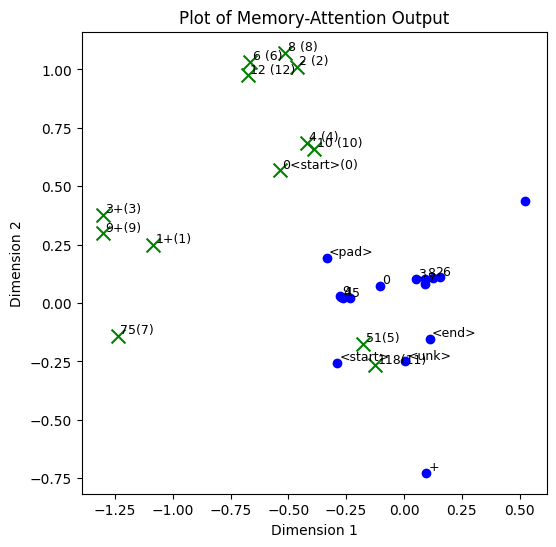

[[[-1.6435317   0.49533296  0.42011997  0.60105455]]

 [[-1.6943172   0.24743967  0.68628347  0.61974686]]

 [[ 0.04688106  0.19959654  1.1867187  -1.2462703 ]]

 [[-1.6575526   0.14451656  0.47338554  0.8430879 ]]

 [[-1.4686394   0.87218386  0.61969376 -0.00655041]]

 [[-1.6363292   0.05525788  0.43688422  0.9244544 ]]

 [[-0.19775134  0.3157808   1.2421297  -1.1725849 ]]

 [[-1.69228     0.22800252  0.6557271   0.65821934]]

 [[ 0.14903046  0.09835204  1.1966846  -1.2630453 ]]

 [[-1.6569299   0.13429911  0.4752752   0.8489754 ]]

 [[ 0.3293645   0.3277274   0.83976895 -1.3039593 ]]

 [[-1.6319108   0.00823679  0.45022798  0.94640756]]

 [[-1.0840503   0.67405885  1.1575513  -0.62277967]]]
(13, 1, 4)
[[-1.6435317   0.49533296]
 [-1.6943172   0.24743967]
 [ 0.04688106  0.19959654]
 [-1.6575526   0.14451656]
 [-1.4686394   0.87218386]
 [-1.6363292   0.05525788]
 [-0.19775134  0.3157808 ]
 [-1.69228     0.22800252]
 [ 0.14903046  0.09835204]
 [-1.6569299   0.13429911]
 [ 0.3293645   0.

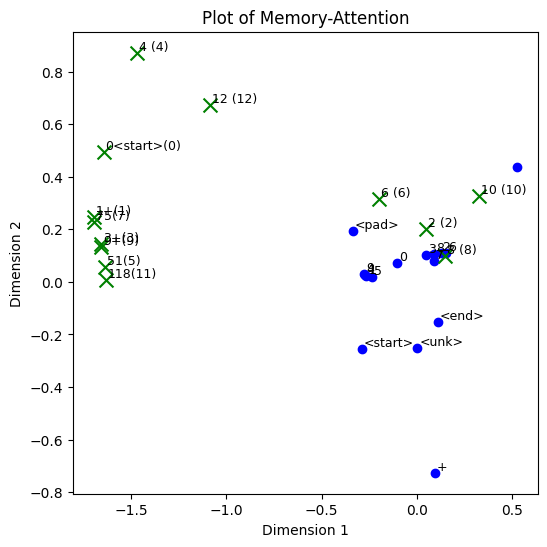

AfterLinear.shape: torch.Size([13, 1, 4])
AfterAddTGT.shape: torch.Size([13, 1, 4])
AfterAddTGT: tensor([[[-0.6365,  4.0819, -4.8020,  1.7981]],

        [[-2.6979,  3.4569, -3.8117,  3.0539]],

        [[-0.4512,  1.7669,  3.4718, -4.2945]],

        [[-2.6558,  2.8914, -3.7969,  3.4703]],

        [[ 0.6038,  4.6675, -4.7440,  0.2504]],

        [[-3.0498,  2.3740, -3.4080,  3.8481]],

        [[-2.4755,  2.2611,  3.7834, -3.3452]],

        [[-2.7223,  3.3501, -3.7912,  3.1421]],

        [[ 3.6565, -3.4895, -3.1549,  2.9583]],

        [[-2.7209,  2.8351, -3.7429,  3.5185]],

        [[ 4.5542,  0.8292, -4.8145,  0.2503]],

        [[-3.3400,  2.0639, -3.0869,  4.0352]],

        [[-0.5881,  5.6869, -3.7061, -0.5995]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[ -4.7502,  -0.4509, -17.9098, -16.8589,  -1.9793,   4.1290, -13.9692,  -3.1488, -18.6848,
          -1.6188,  -2.1063,  -2.3971,  -1.6095, -10.3702,  14.55

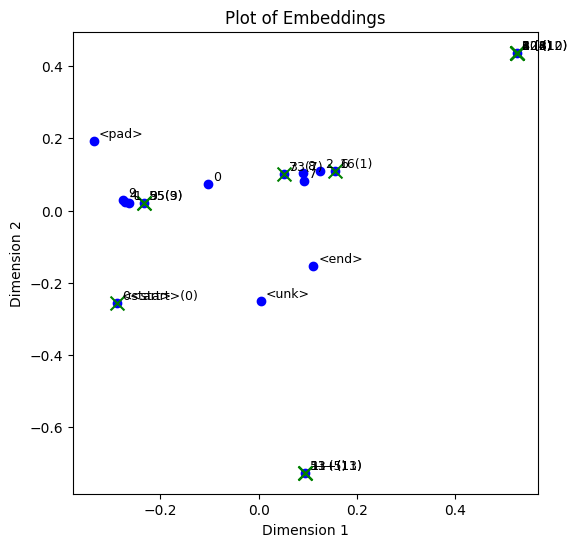

[[[-0.5773521   0.48808908 -0.9953046   0.3460942 ]]

 [[ 1.1514617   0.76001924  0.7813353   0.8718431 ]]

 [[ 1.9595673   0.45812562 -1.2092543   0.41589004]]

 [[-0.32508355 -0.9496748   0.6545506   2.6332536 ]]

 [[ 0.29346734  0.22062886 -1.1892636   0.41529012]]

 [[-0.768994   -1.168677   -0.41812384  0.06390113]]

 [[ 0.77085435  1.8344427  -1.1692889   0.41429055]]

 [[ 0.7590668   0.956551    1.3100457   0.77085614]]

 [[ 2.039628    0.7287724  -1.1493382   0.4128917 ]]

 [[-0.05408508 -0.87081254  0.71443367  2.6296563 ]]

 [[ 0.5062487   0.03520095 -1.1294196   0.4110942 ]]

 [[-0.8100599  -1.4479135  -0.3583247   0.05910695]]

 [[ 0.5136969   1.7181264  -1.1095407   0.40889865]]

 [[ 0.61009735 -0.5448924  -0.33846885  0.05671275]]]
(14, 1, 4)
[[-0.5773521   0.48808908]
 [ 1.1514617   0.76001924]
 [ 1.9595673   0.45812562]
 [-0.32508355 -0.9496748 ]
 [ 0.29346734  0.22062886]
 [-0.768994   -1.168677  ]
 [ 0.77085435  1.8344427 ]
 [ 0.7590668   0.956551  ]
 [ 2.039628    0.

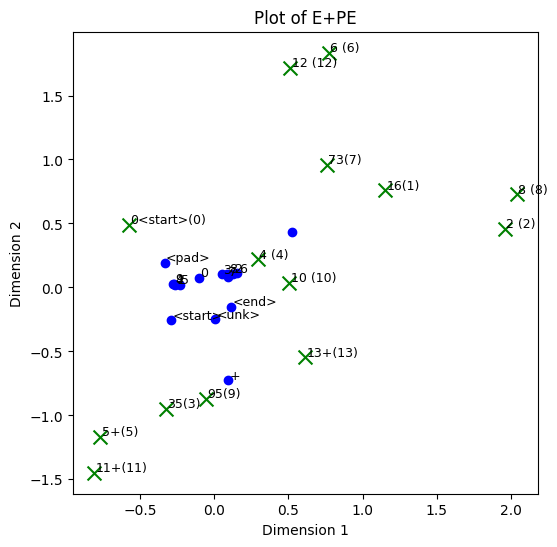

SelfAttention Layer
QV.shape: torch.Size([1, 14, 4])
KV.shape: torch.Size([1, 14, 4])
WV.shape: torch.Size([1, 14, 4])
attn_weight.shape: torch.Size([1, 14, 14])
AV.shape: torch.Size([1, 14, 4])
[[[ 0.7114342   0.2834468   0.88825536  0.07920831]
  [ 0.505927   -2.0341296   0.67983264  0.66483295]
  [ 1.9474189  -0.9667186   2.2453575  -0.8334879 ]
  [-2.532358   -1.0347031   0.88004005  1.2374113 ]
  [ 0.965866    0.07053957  1.4842246  -0.3846688 ]
  [-0.83484656  1.4373012   0.5792201  -0.5744088 ]
  [ 2.4699285  -1.335511    1.4578295   0.2476317 ]
  [ 0.26438832 -2.173289    0.09268427  1.0571992 ]
  [ 2.1719797  -1.2294121   2.203474   -0.70533437]
  [-2.371125   -1.2616495   0.9559436   1.2083375 ]
  [ 0.8889238   0.06215561  1.571501   -0.5230212 ]
  [-1.1054897   1.6296978   0.560847   -0.6739373 ]
  [ 2.2284944  -1.1443617   1.3137699   0.29901758]
  [ 0.2736903   0.23166108  1.0817475  -0.70238096]]]
(1, 14, 4)
[[ 0.7114342   0.2834468 ]
 [ 0.505927   -2.0341296 ]
 [ 1.94741

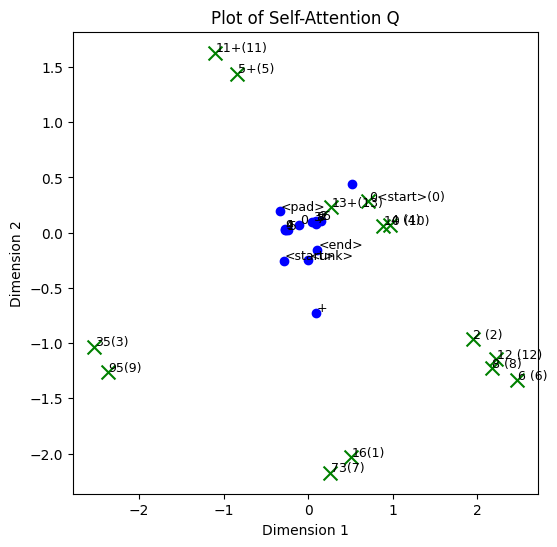

[[[ 1.3043206   0.17599075  0.46306956 -0.8162733 ]
  [-0.42002255 -1.5466874   0.02698152  2.321025  ]
  [-1.0431776   0.00790177  0.69567186  1.1365722 ]
  [-0.55486584  0.34213054 -1.6250391  -0.8156235 ]
  [ 0.33235416  0.45209563  0.41340655 -0.4876575 ]
  [ 0.3828183   1.4692954  -0.64528066 -1.9975775 ]
  [ 0.95665556 -1.2246394   1.414116    1.4234873 ]
  [ 0.03392431 -2.040095   -0.02586579  2.6158478 ]
  [-0.9441848  -0.3112424   0.8461021   1.504194  ]
  [-0.7582805   0.18767633 -1.574228   -0.4617222 ]
  [ 0.00811601  0.5674353   0.30112606 -0.4269424 ]
  [ 0.23054767  1.7115372  -0.8339966  -2.2399285 ]
  [ 1.1111606  -1.115005    1.30608     1.1468548 ]
  [-0.48265994  0.6137756  -0.18392262 -0.17905496]]]
(1, 14, 4)
[[ 1.3043206   0.17599075]
 [-0.42002255 -1.5466874 ]
 [-1.0431776   0.00790177]
 [-0.55486584  0.34213054]
 [ 0.33235416  0.45209563]
 [ 0.3828183   1.4692954 ]
 [ 0.95665556 -1.2246394 ]
 [ 0.03392431 -2.040095  ]
 [-0.9441848  -0.3112424 ]
 [-0.7582805   0

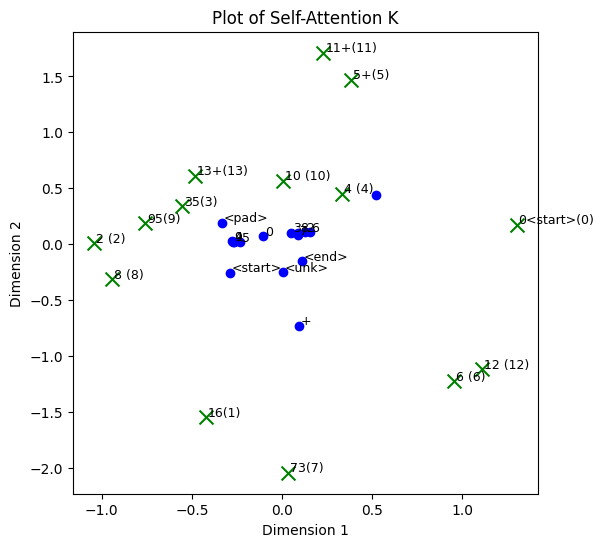

[[[-0.36121717  0.70498306 -0.00340729 -0.08988198]
  [-0.940024   -1.1819144  -1.1625241  -0.8931113 ]
  [-0.38743532  0.60466486 -0.96299666 -1.357928  ]
  [-0.44477102 -2.064874   -0.7902722  -0.66288084]
  [-0.22209424  0.71188325 -0.25376043 -0.5252558 ]
  [ 0.5861341   0.13321787  0.69309384  0.43203232]
  [-1.1467686   0.8873743  -0.9800878  -0.97567254]
  [-1.0836861  -1.5115368  -1.0895604  -0.61330616]
  [-0.54917705  0.58775806 -1.089325   -1.4237993 ]
  [-0.5017034  -2.127848   -0.92400056 -0.79294485]
  [-0.12820074  0.6159197  -0.27609378 -0.5903069 ]
  [ 0.73836803  0.04797788  0.79878056  0.50163907]
  [-1.0821503   0.8470211  -0.8472106  -0.8253559 ]
  [ 0.19716874  0.02992103 -0.04437628 -0.2993724 ]]]
(1, 14, 4)
[[-0.36121717  0.70498306]
 [-0.940024   -1.1819144 ]
 [-0.38743532  0.60466486]
 [-0.44477102 -2.064874  ]
 [-0.22209424  0.71188325]
 [ 0.5861341   0.13321787]
 [-1.1467686   0.8873743 ]
 [-1.0836861  -1.5115368 ]
 [-0.54917705  0.58775806]
 [-0.5017034  -2

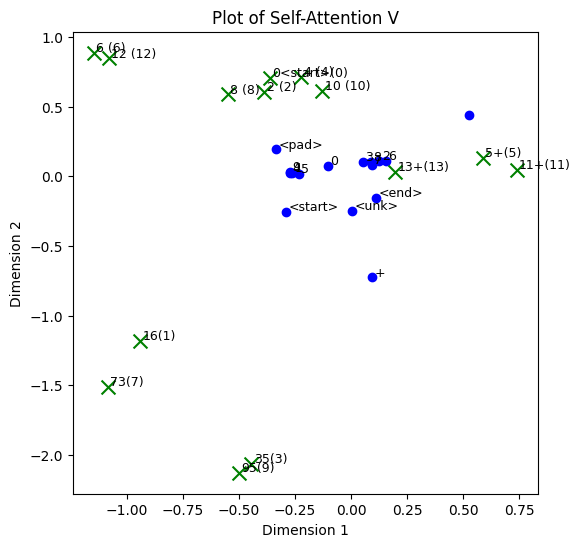

[[[-0.4871115   0.2932036  -0.50202215 -0.6020217 ]
  [-0.9785972  -0.33952218 -0.98288834 -0.8064015 ]
  [-0.8044611   0.68752146 -0.63771534 -0.675699  ]
  [-0.7548875  -0.3803859  -1.0333928  -1.0072341 ]
  [-0.511554    0.46447068 -0.46085823 -0.56635916]
  [ 0.09105215  0.00692985 -0.00540844 -0.22064845]
  [-0.9793312   0.55956864 -0.8257059  -0.7947432 ]
  [-0.99255687 -0.74896634 -1.0362976  -0.7776098 ]
  [-0.87629175  0.69953775 -0.70148563 -0.72095025]
  [-0.789299   -0.4447039  -1.0407721  -0.9807597 ]
  [-0.47743344  0.4681225  -0.42724782 -0.54219043]
  [ 0.14583792 -0.02222917  0.05137432 -0.16990696]
  [-0.9533967   0.5080559  -0.8148141  -0.78447926]
  [-0.23321925  0.26850402 -0.25192732 -0.412045  ]]]
(1, 14, 4)
[[-0.4871115   0.2932036 ]
 [-0.9785972  -0.33952218]
 [-0.8044611   0.68752146]
 [-0.7548875  -0.3803859 ]
 [-0.511554    0.46447068]
 [ 0.09105215  0.00692985]
 [-0.9793312   0.55956864]
 [-0.99255687 -0.74896634]
 [-0.87629175  0.69953775]
 [-0.789299   -0

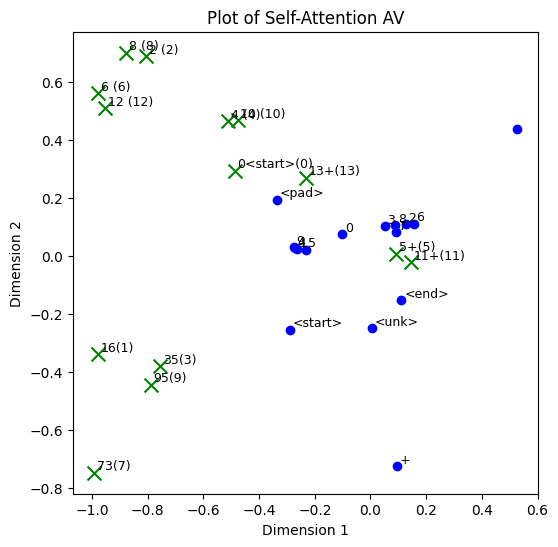

[[[-0.5233294   0.53572774  1.0784124  -0.05354742]]

 [[-1.0776378   0.24541846  1.6179242   0.5861283 ]]

 [[-0.46082887  0.99986124  1.6781423  -0.55716944]]

 [[-1.282605    0.37077412  1.3486564   0.86303335]]

 [[-0.41318408  0.65672636  1.1598234  -0.27523348]]

 [[-0.18501766 -0.16574639  0.05809069  0.2169337 ]]

 [[-0.6627969   1.0263634   1.9160597  -0.40252745]]

 [[-1.232314   -0.14092681  1.4922678   1.0063587 ]]

 [[-0.51096785  1.0640848   1.7963743  -0.56664616]]

 [[-1.2875065   0.29364863  1.3678007   0.90057033]]

 [[-0.38248652  0.631979    1.1060297  -0.28282523]]

 [[-0.1388961  -0.24777584 -0.04347762  0.23441704]]

 [[-0.6721385   0.9674051   1.85937    -0.34336263]]

 [[-0.3066167   0.2955664   0.65766674 -0.06082578]]]
(14, 1, 4)
[[-0.5233294   0.53572774]
 [-1.0776378   0.24541846]
 [-0.46082887  0.99986124]
 [-1.282605    0.37077412]
 [-0.41318408  0.65672636]
 [-0.18501766 -0.16574639]
 [-0.6627969   1.0263634 ]
 [-1.232314   -0.14092681]
 [-0.51096785  1.

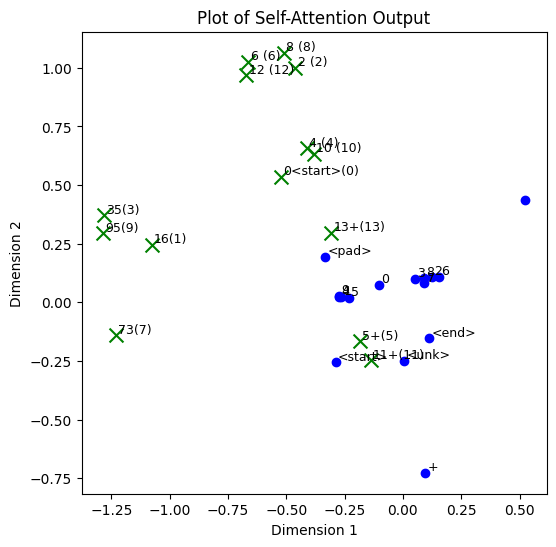

[[[-2.0634973   0.7110119   0.2388171   0.35744366]]

 [[-1.8582412  -0.5297244   1.5813359   0.3338994 ]]

 [[ 1.2772875   0.4466614  -0.26707175 -1.8121386 ]]

 [[-1.6159418  -0.87465817  0.7923865   1.692767  ]]

 [[-1.1592072   1.0699784  -0.38291207 -0.26595193]]

 [[-0.80598634 -1.2990009   0.5967104   1.8338715 ]]

 [[-0.97210175  1.0671127   0.07139003 -1.0484728 ]]

 [[-1.8903439  -0.5871374   1.4931263   0.5734245 ]]

 [[ 0.97219384  0.58828044 -0.16068195 -1.8799433 ]]

 [[-1.5461061  -0.9295865   0.80039716  1.7008458 ]]

 [[-0.52635     1.071869   -0.6865112  -0.48273775]]

 [[-0.4952577  -1.4361174   0.6100453   1.7297647 ]]

 [[-1.1990623   1.0458056   0.15353422 -0.9025203 ]]

 [[ 1.1669047  -1.492399    1.1647472  -0.5415949 ]]]
(14, 1, 4)
[[-2.0634973   0.7110119 ]
 [-1.8582412  -0.5297244 ]
 [ 1.2772875   0.4466614 ]
 [-1.6159418  -0.87465817]
 [-1.1592072   1.0699784 ]
 [-0.80598634 -1.2990009 ]
 [-0.97210175  1.0671127 ]
 [-1.8903439  -0.5871374 ]
 [ 0.97219384  0.

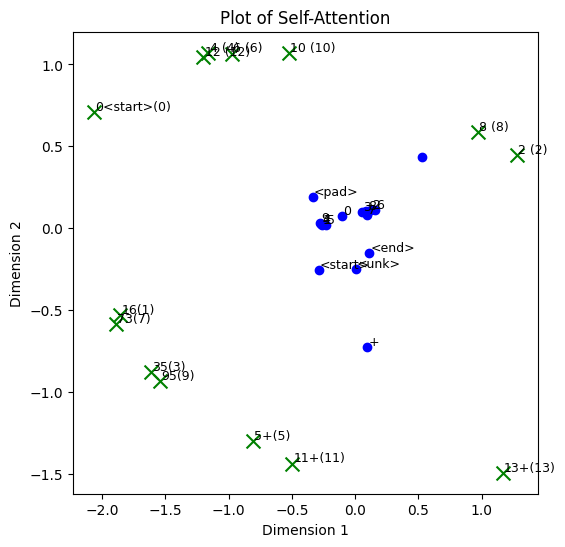

QV.shape: torch.Size([1, 14, 4])
KV.shape: torch.Size([1, 15, 4])
WV.shape: torch.Size([1, 15, 4])
attn_weight.shape: torch.Size([1, 14, 15])
AV.shape: torch.Size([1, 14, 4])
[[[-1.4165598  -3.923481    3.9681127   1.0454267 ]
  [-0.5277946  -4.303756    3.9032907   2.2306852 ]
  [-1.1704984   1.9975045  -2.9255872  -1.7497363 ]
  [ 1.1488779  -2.9762635   3.8013313   2.4963481 ]
  [-1.6547625  -2.0573604   1.9764895  -0.18810195]
  [ 2.0745046  -1.2917683   2.364707    2.2637508 ]
  [-2.2825372  -2.2048979   1.45261    -0.40553573]
  [-0.2827763  -4.239869    4.0305023   2.3393884 ]
  [-1.5217845   1.3399129  -2.3824158  -1.6431037 ]
  [ 1.2362751  -2.8463926   3.6816702   2.496205  ]
  [-1.4544705  -0.75757694  0.69583297 -0.7608302 ]
  [ 2.261708   -0.74486476  1.7743111   2.1348019 ]
  [-2.2759964  -2.6346636   1.9314365  -0.17248586]
  [ 1.1935942   1.373239   -1.9187667   0.5751395 ]]]
(1, 14, 4)
[[-1.4165598  -3.923481  ]
 [-0.5277946  -4.303756  ]
 [-1.1704984   1.9975045 ]
 [ 

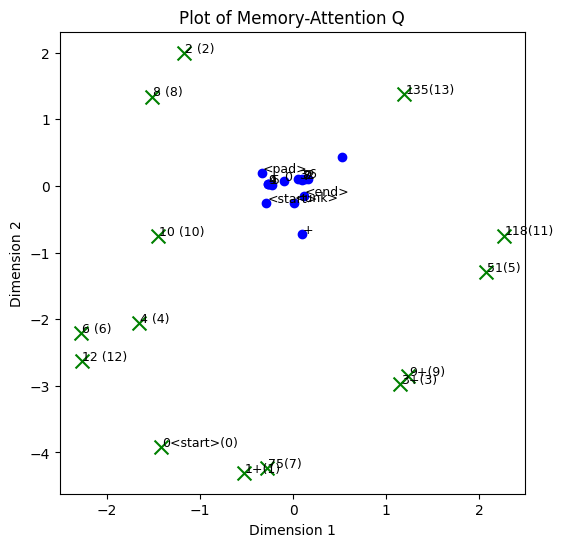

[[ 0.07327791 -2.5288906   1.306968   -1.223968  ]
 [ 1.6685178  -1.1960628   0.91147727 -0.5041745 ]
 [ 2.5529053   0.1212697  -0.5321311  -1.1750104 ]
 [ 1.4143151  -2.549254    2.2894092   0.5687194 ]
 [ 1.0500749  -1.7679434   0.8240719  -0.9760114 ]
 [-0.5777796  -0.4354818   1.7436101  -2.6596646 ]
 [ 1.0594467  -0.5966722  -0.43969667 -2.1219983 ]
 [ 0.99003315  1.5487828   0.24664766 -2.9581008 ]
 [ 2.5344987   0.3552053  -0.7472646  -1.3965459 ]
 [ 1.6255323  -2.184606    2.0425653   0.4757433 ]
 [ 1.2770767  -1.5718046   0.7694122  -0.8833606 ]
 [-0.69651926 -0.9982526   1.4666421  -2.3227859 ]
 [ 0.827808   -0.8843589  -0.18830478 -2.0646005 ]
 [ 0.7052644   1.3896158   0.33063596 -3.0888352 ]
 [ 1.7137104   1.0518332   0.17919093 -1.9104965 ]]
(15, 4)
[[ 0.07327791 -2.5288906 ]
 [ 1.6685178  -1.1960628 ]
 [ 2.5529053   0.1212697 ]
 [ 1.4143151  -2.549254  ]
 [ 1.0500749  -1.7679434 ]
 [-0.5777796  -0.4354818 ]
 [ 1.0594467  -0.5966722 ]
 [ 0.99003315  1.5487828 ]
 [ 2.53449

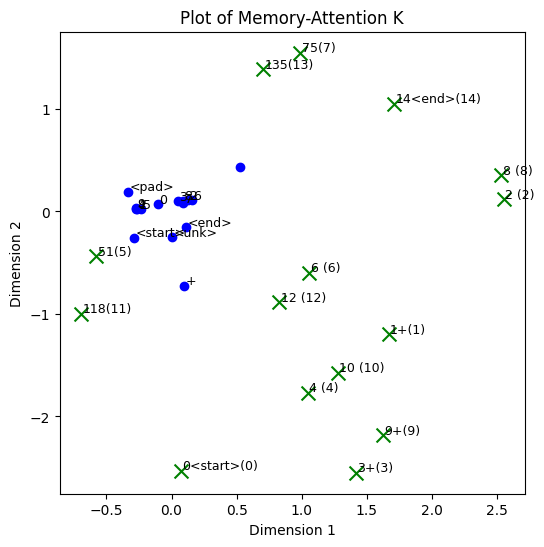

[[ 0.55053616 -1.6242408  -0.8784507   0.43744868]
 [-0.2726183   1.0979435   2.0696685   0.4014243 ]
 [ 0.50437075  0.01104     2.3475986   0.98482716]
 [-0.67276406  2.1595435   2.3104577   0.6872109 ]
 [ 0.53664225 -0.8653494   0.43006748  0.81671643]
 [-1.2280912  -0.5708195  -0.750867   -0.18713427]
 [ 0.94788116 -2.1382895  -0.14966026  0.44638598]
 [-1.0976841   0.01159701  1.0695513   0.15320957]
 [ 0.53420687 -0.17124179  2.253001    0.87299657]
 [-0.71016455  2.2967656   2.5956075   0.648484  ]
 [ 0.42842817 -0.5045368   0.8350924   0.8380319 ]
 [-1.1730464  -0.17384742 -0.64760375 -1.259132  ]
 [ 0.8916114  -2.1635432  -0.38591334  0.38980645]
 [-1.0786531  -0.26864305  0.66120344  0.029836  ]
 [-1.0892184   1.3326768   2.3912103  -0.10224885]]
(15, 4)
[[ 0.55053616 -1.6242408 ]
 [-0.2726183   1.0979435 ]
 [ 0.50437075  0.01104   ]
 [-0.67276406  2.1595435 ]
 [ 0.53664225 -0.8653494 ]
 [-1.2280912  -0.5708195 ]
 [ 0.94788116 -2.1382895 ]
 [-1.0976841   0.01159701]
 [ 0.53420

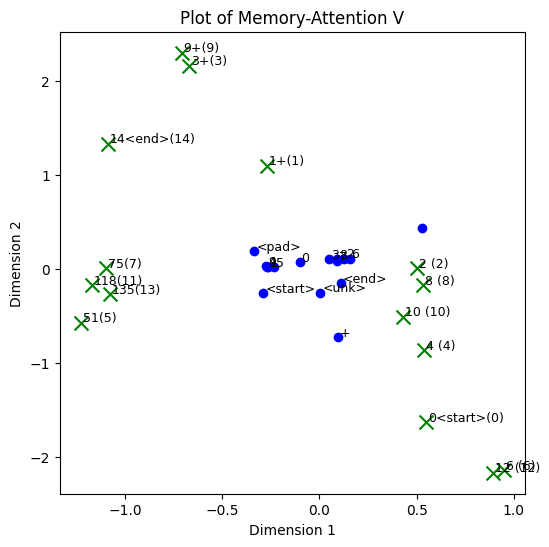

[[-0.55443895  1.7649857   2.0052042   0.6412991 ]
 [-0.6505459   2.094874    2.2899117   0.6738266 ]
 [-0.79087317 -0.21262261  0.9456238   0.15695365]
 [-0.67173237  2.1639464   2.362532    0.67513925]
 [-0.34304285  0.09866942  0.42103967  0.20675424]
 [-0.6511162   2.115967    2.3665793   0.66733253]
 [-0.3231879  -0.41695035 -0.1276926   0.01409529]
 [-0.6582889   2.1192782   2.3109472   0.67538786]
 [-0.70588917 -0.3442873   0.77738345  0.13060458]
 [-0.671529    2.1638417   2.3645475   0.6747303 ]
 [-0.53537524 -0.46760762 -0.13938463 -0.13115741]
 [-0.6132597   2.0231795   2.3384054   0.6628265 ]
 [-0.24783134 -0.17103168  0.170565    0.18223117]
 [ 0.10747306 -0.04305188  1.885783    0.6293434 ]]
(14, 4)
[[-0.55443895  1.7649857 ]
 [-0.6505459   2.094874  ]
 [-0.79087317 -0.21262261]
 [-0.67173237  2.1639464 ]
 [-0.34304285  0.09866942]
 [-0.6511162   2.115967  ]
 [-0.3231879  -0.41695035]
 [-0.6582889   2.1192782 ]
 [-0.70588917 -0.3442873 ]
 [-0.671529    2.1638417 ]
 [-0.53

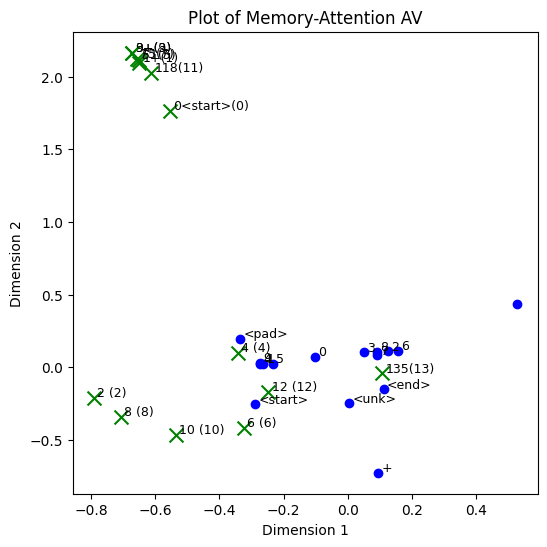

[[[-0.5233294   0.53572774  1.0784124  -0.05354742]]

 [[-1.0776378   0.24541846  1.6179242   0.5861283 ]]

 [[-0.46082887  0.99986124  1.6781423  -0.55716944]]

 [[-1.282605    0.37077412  1.3486564   0.86303335]]

 [[-0.41318408  0.65672636  1.1598234  -0.27523348]]

 [[-0.18501766 -0.16574639  0.05809069  0.2169337 ]]

 [[-0.6627969   1.0263634   1.9160597  -0.40252745]]

 [[-1.232314   -0.14092681  1.4922678   1.0063587 ]]

 [[-0.51096785  1.0640848   1.7963743  -0.56664616]]

 [[-1.2875065   0.29364863  1.3678007   0.90057033]]

 [[-0.38248652  0.631979    1.1060297  -0.28282523]]

 [[-0.1388961  -0.24777584 -0.04347762  0.23441704]]

 [[-0.6721385   0.9674051   1.85937    -0.34336263]]

 [[-0.3066167   0.2955664   0.65766674 -0.06082578]]]
(14, 1, 4)
[[-0.5233294   0.53572774]
 [-1.0776378   0.24541846]
 [-0.46082887  0.99986124]
 [-1.282605    0.37077412]
 [-0.41318408  0.65672636]
 [-0.18501766 -0.16574639]
 [-0.6627969   1.0263634 ]
 [-1.232314   -0.14092681]
 [-0.51096785  1.

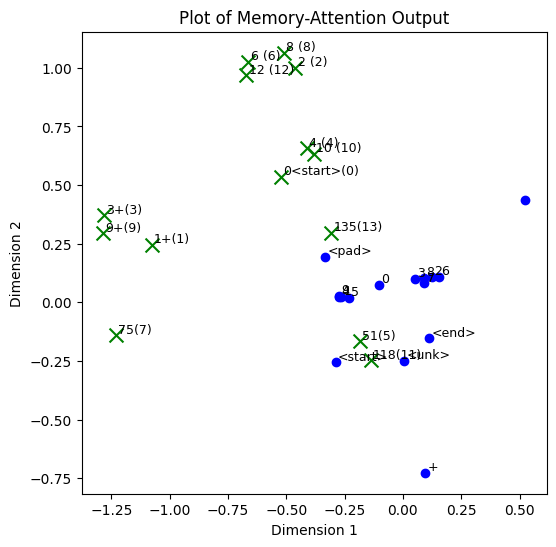

[[[-1.6408716   0.49452305  0.40414098  0.61250776]]

 [[-1.6943048   0.2470779   0.68591297  0.6203225 ]]

 [[ 0.04021183  0.2135299   1.1796088  -1.245592  ]]

 [[-1.6571298   0.14371115  0.47195026  0.8445306 ]]

 [[-1.4840705   0.88404924  0.53483105  0.06700925]]

 [[-1.6353775   0.05809209  0.4318405   0.925563  ]]

 [[-0.1926812   0.3166002   1.2385603  -1.1746448 ]]

 [[-1.6922759   0.22803901  0.65568507  0.6582217 ]]

 [[ 0.1380033   0.11223926  1.1936085  -1.261902  ]]

 [[-1.6565611   0.13363406  0.47402948  0.85019964]]

 [[ 0.2974939   0.44846594  0.7419073  -1.2905815 ]]

 [[-1.632211    0.01424169  0.44737768  0.94431746]]

 [[-1.0802449   0.6775308   1.1543685  -0.62614167]]

 [[-1.1264533  -1.2813252   1.6062864   0.57111025]]]
(14, 1, 4)
[[-1.6408716   0.49452305]
 [-1.6943048   0.2470779 ]
 [ 0.04021183  0.2135299 ]
 [-1.6571298   0.14371115]
 [-1.4840705   0.88404924]
 [-1.6353775   0.05809209]
 [-0.1926812   0.3166002 ]
 [-1.6922759   0.22803901]
 [ 0.1380033   0.

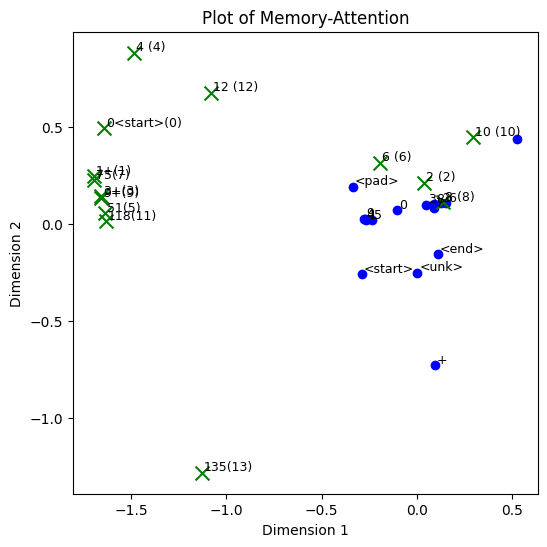

AfterLinear.shape: torch.Size([14, 1, 4])
AfterAddTGT.shape: torch.Size([14, 1, 4])
AfterAddTGT: tensor([[[-0.6089,  4.0669, -4.8141,  1.7994]],

        [[-2.6990,  3.4550, -3.8109,  3.0556]],

        [[-0.5775,  2.0021,  3.3730, -4.2911]],

        [[-2.6561,  2.8870, -3.7961,  3.4734]],

        [[ 0.6986,  4.5790, -4.7986,  0.2976]],

        [[-3.0189,  2.3932, -3.4368,  3.8345]],

        [[-2.4447,  2.2821,  3.7648, -3.3699]],

        [[-2.7219,  3.3503, -3.7914,  3.1419]],

        [[ 4.1365, -3.6319, -2.9853,  2.5231]],

        [[-2.7210,  2.8315, -3.7423,  3.5210]],

        [[ 4.0050,  2.9253, -4.1585, -1.6465]],

        [[-3.3005,  2.1052, -3.1326,  4.0124]],

        [[-0.5493,  5.6801, -3.7152, -0.6169]],

        [[-3.9139, -2.8776,  2.0864,  3.6599]]], device='cuda:0',
       grad_fn=<NativeLayerNormBackward0>)
output.shape: torch.Size([1, 16])
output: tensor([[  3.1932, -14.9145,   5.3513,   6.6541, -13.3441, -11.4763,   5.0164,   2.8645,   5.8042,
         -10.508

In [53]:

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
text = '+ + 1 5 + 8 5'

tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
memory = positional_encoding(embedding_weight[src] * math.sqrt(embedding_size))
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# 分析0
print(f"text: {text}")
print(f"memory: {memory}")
print(f"memory_size: {memory.size()}")
print("\n------------------\n")


for i in range(20):
    tgt_embed = positional_encoding(embedding_weight[ys] * math.sqrt(embedding_size))
    tgt_mask = generate_square_subsequent_mask(ys.size(0)).to(device).type(torch.bool)

    # 分析１
    print(f"iter: {i}")
    print(f"ys: {ys}")
    print(f"tgt_embed: {tgt_embed}")
    now_tgt = convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)
    print(f"now tgt: {now_tgt}")
    print(f"tgt_embed: {tgt_embed}")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=embedding_weight[ys], title="Embeddings")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt_embed, title="E+PE")
    
    # Self-attention
    self_attn_wq, self_attn_wk, self_attn_wv = self_attn_in_proj_weight.chunk(3, dim=0)
    self_attn_bq, self_attn_bk, self_attn_bv = self_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
    KW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
    VW = torch.matmul(tgt_embed.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
    self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(self_attn_weights, VW)
    self_attn_output = torch.matmul(AV, self_attn_out_proj_weight.T) + self_attn_out_proj_bias
    self_attn_output = self_attn_output.permute(1, 0, 2)
    tgt = tgt_embed + self_attn_output
    tgt = loaded_model.decoder_layer.norm1(tgt)

    # 分析2
    print("SelfAttention Layer")
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {self_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Self-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=QW, title="Self-Attention Q")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=KW, title="Self-Attention K")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=VW, title="Self-Attention V")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=AV, title="Self-Attention AV")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=self_attn_output, title="Self-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, title="Self-Attention")

    


    # Attention with the encoder outputs (memory)
    multi_attn_wq, multi_attn_wk, multi_attn_wv = multihead_attn_in_proj_weight.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = multihead_attn_in_proj_bias.chunk(3, dim=0)
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, multihead_attn_out_proj_weight.T) + multihead_attn_out_proj_bias
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt = tgt + multi_attn_output
    tgt = loaded_model.decoder_layer.norm2(tgt)

    # 分析3
    print(f"QV.shape: {QW.shape}")
    print(f"KV.shape: {KW.shape}")
    print(f"WV.shape: {VW.shape}")
    print(f"attn_weight.shape: {multi_attn_weights.shape}")
    print(f"AV.shape: {AV.shape}")
    # Memory-Attentionのベクトルの可視化
    plot_embedding_tgt_2d(ys=ys, tgt_embed=QW, src=src, title="Memory-Attention Q")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=np.squeeze(KW, axis=0), src=src, title="Memory-Attention K")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=np.squeeze(VW, axis=0), src=src, title="Memory-Attention V")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=np.squeeze(AV, axis=0), src=src, title="Memory-Attention AV")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=multi_attn_output, src=src, title="Memory-Attention Output")
    plot_embedding_tgt_2d(ys=ys, tgt_embed=tgt, src=src, title="Memory-Attention")



    # Feedforward network

    # decoder linear1, 2
    tgt2 = tgt.matmul(linear1_weight.T) + linear1_bias
    tgt2 = F.relu(tgt2)
    tgt2 = tgt2.matmul(linear2_weight.T) + linear2_bias
    tgt = tgt + tgt2

    # LayerNorm
    tgt = loaded_model.decoder_layer.norm3(tgt)

    output = tgt.transpose(0, 1)
    output = loaded_model.output(output[:, -1])

    _, next_word = torch.max(output, dim=1)
    next_word = next_word.item()


    # 分析4
    print(f"AfterLinear.shape: {tgt2.shape}")
    print(f"AfterAddTGT.shape: {tgt.shape}")
    print(f"AfterAddTGT: {tgt}")
    print(f"output.shape: {output.shape}")
    print(f"output: {output}")

    ys = torch.cat([ys, torch.ones(1, 1).fill_(next_word).type_as(src.data)], dim=0)
    print(f"predicted: {next_word}")

    print("\n------------------\n")
    
    if next_word == END_IDX:
        break


flat_indexes = [idx for sublist in ys.tolist() for idx in sublist] if isinstance(ys.tolist()[0], list) else ys.tolist()

print(f"Input: {text}")
print(f"Decoded sequence: {convert_indexes_to_text(flat_indexes, vocab_tgt)}")

# Transformerの検算

スクラッチで書くための検算

## Multihead Attention

Multihead Attentionの動作をスクラッチで書きたいので、ここで検算する

参考サイト
https://blog.amedama.jp/entry/pytorch-multi-head-attention-verify

In [30]:
import torch
from torch import nn
import torch.nn.functional as F


In [31]:
edim = 4 # 埋め込み次元
num_heads = 1 # ヘッド数
model = nn.MultiheadAttention(edim, num_heads, bias=True, batch_first=True)

In [ ]:
batch_size = 2
L=5
X = torch.randn(batch_size, L, edim) # 入力

Q = K = V = X # クエリ、キー、バリューは全て入力とする
print(Q.shape)
print(Q)

In [ ]:

attn_output, attn_output_weights = model(Q, K, V)

print(attn_output.shape)
print(attn_output)



In [ ]:
from pprint import pprint
pprint(list(model.named_parameters()))

In [35]:
model_weight = {name: param.data for name, param in model.named_parameters()}
Wi = model_weight['in_proj_weight']
Wo = model_weight['out_proj.weight']
Wbi = model_weight['in_proj_bias']
Wbo = model_weight['out_proj.bias']

In [36]:
Wi_q, Wi_k, Wi_v = Wi.chunk(3, dim=0)
Wbi_q, Wbi_k, Wbi_v = Wbi.chunk(3, dim=0)
QW = torch.matmul(Q, Wi_q.T) + Wbi_q
KW = torch.matmul(K, Wi_k.T) + Wbi_k
VW = torch.matmul(V, Wi_v.T) + Wbi_v

KW_t = KW.transpose(-2, -1)
QK_t = torch.bmm(QW, KW_t)
QK_scaled = QK_t / (edim ** 0.5)
attn_weights_ = F.softmax(QK_scaled, dim=-1)

In [ ]:
print(attn_weights_)
print(attn_output_weights)

In [38]:
AV = torch.matmul(attn_weights_, VW)
attn_output_ = torch.matmul(AV, Wo.T) + Wbo

In [ ]:
print(attn_output_)
print(attn_output)

## nn.Linear

In [ ]:
model = nn.Linear(4, 4)
model

In [ ]:
pprint(list(model.named_parameters()))

In [ ]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


In [ ]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)

## nn.LayerNorm

参考サイト
https://qiita.com/dl_from_scratch/items/133fe741b67ed14f1856

In [ ]:
model = nn.LayerNorm(4)
model

In [ ]:
pprint(list(model.named_parameters()))

In [ ]:
model_weight = {name: param.data for name, param in model.named_parameters()}
W = model_weight['weight']
B = model_weight['bias']

X = torch.randn(4) 
print(X.shape)
print(X)
output = model(X)
print(output.shape)
print(output)


In [ ]:
output_ = X.matmul(W.T) + B
print(output_)
print(output)